# Import Packages

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Read EUMETSAT Product

In [2]:
def read_nc(file_path, mode, var_name):
    # Open the NetCDF file
    try:
        nc_file = nc.Dataset(file_path, 'r')
    except:
        return "Error opening the NetCDF file.", _
    
    # Specify if the file is from EUMETSAT or from the LP
    if mode == "EUM":
        var = nc_file[var_name]
        val = var[:]
        
    elif mode == "LP":
        if var_name == "time_startscan_utc_earthview": # Different!
            var_name = "/data/navigation/time_attitude"
            
        else:
            var_name = "/data/navigation/" + var_name
        
        var = nc_file[var_name]
        val = var[:]
        
        if var_name == "/common/earth_sun_distance_ratio": 
            var_name = "/status/satellite/earth_sun_distance_ratio"
        
    else:
        return "Incorrect 'mode' given as input. Please, specify if it is a NetCDF from 'EUM' or 'LP'.", _
    
    return var, val

def read_common_nc(file_path, mode, var_name):
    # Open the NetCDF file
    try:
        nc_file = nc.Dataset(file_path, 'r')
    except:
        return "Error opening the NetCDF file.", _
    
    # Specify if the file is from EUMETSAT or from the LP
    if mode == "EUM":
        var_name = "/common/" + var_name
    elif mode == "LP":
        var_name = "/status/satellite/" + var_name
        # orbit_end, orbit_start, time_end, time_end_int, time_start, time_start_int
    else:
        return "Incorrect 'mode' given as input. Please, specify if it is a NetCDF from 'EUM' or 'LP'.", _
    
    var = nc_file[var_name]
    val = var[:]

    return var, val

def stats(d1, d2):
    if len(d1) == len(d2):
        # Difference array
        dif = np.subtract(d1, d2, dtype=np.float64)
        # Mean
        mean = np.mean(dif)
        # Min & Max (absolute value)
        minim = dif[dif != 0]
        if len(minim) != 0:
            minim = abs(minim.min())
        else:
            minim = 0
        maxim = abs(dif.max())
        # RMS
        rms = np.sqrt(1/len(d1) * np.sum(np.square(dif)))
    else:
        print("Error when computing stats. Length missmatch:\nLenght First:", len(d1),"\nLenght Second:", len(d2))
        sys.exit("Exit the Status Function due to length missmatch.")
    
    return f'{mean:.3e}', f'{minim:.3e}', f'{maxim:.3e}', f'{rms:.3e}', dif

def stats_nan(d1, d2):
    if len(d1) == len(d2):
        # Difference array
        dif = np.subtract(d1, d2, dtype=np.float64)
        
        # Mean (ignoring NaN)
        mean = np.nanmean(dif)
        
        # Min & Max (absolute value, ignoring NaN)
        minim = np.nanmin(np.abs(dif))
        maxim = np.nanmax(np.abs(dif))
        
        # RMS (ignoring NaN)
        rms = np.sqrt(1/len(d1) * np.nansum(np.square(dif)))
    else:
        print("Error when computing stats. Length mismatch:\nLength First:", len(d1), "\nLength Second:", len(d2))
    
    return f'{mean:.3e}', f'{minim:.3e}', f'{maxim:.3e}', f'{rms:.3e}', dif

def search_nan(d1, d2):
    # Initialize counters
    total_nan, n1, n2 = 0, 0, 0
    # Count NaNs for each dataset
    mask1 = np.isnan(d1)
    n1 = len(mask1[mask1 == True])
    mask2 = np.isnan(d2)
    n2 = len(mask2[mask2 == True])
    # Count all NaNs
    if (n1 != 0) or (n2 != 0):
        total_nan = n1 + n2
        nan_pos = np.sum(np.logical_and(np.isnan(d1), np.isnan(d2)))
        print(" Total NaNs:", total_nan, "\n NaNs in First dataset:", n1, "\n NaNs in Second dataset:", n2, "\n Concurrent NaNs:", nan_pos)
    else:
        print(" No NaNs found!")

# 1. TS-011

## 1.0. Paths to Files

In [3]:
eum_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/EUM EOCFI ref/MwsInr_Scenario011.nc"
lp_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/MWS LP/TS-011/W_XX-EUMETSAT-Darmstadt,SAT,SGA1-MWS-1B-RAD_C_EUMT_20230831125051_L_D_20070912070127_20070912084321_T_N____.nc"

## 1.1. mws_lat

In [4]:
variable = "mws_lat"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lat:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lat:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

lat_eum = var_1
lat_lp = var_2

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lat(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2712, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lat(n_scans, n_fovs)
    long_name: Latitude corresponding to each field of view
    units: degrees_north
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -900000
    valid_max: 900000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lat:
Mean: -4.289e-08 
Minimum: 8.162e-05 
Maximum: 8.233e-05 
RSM: 3.298e-05
--------------------------------------------------------------------------------------------------------------------------

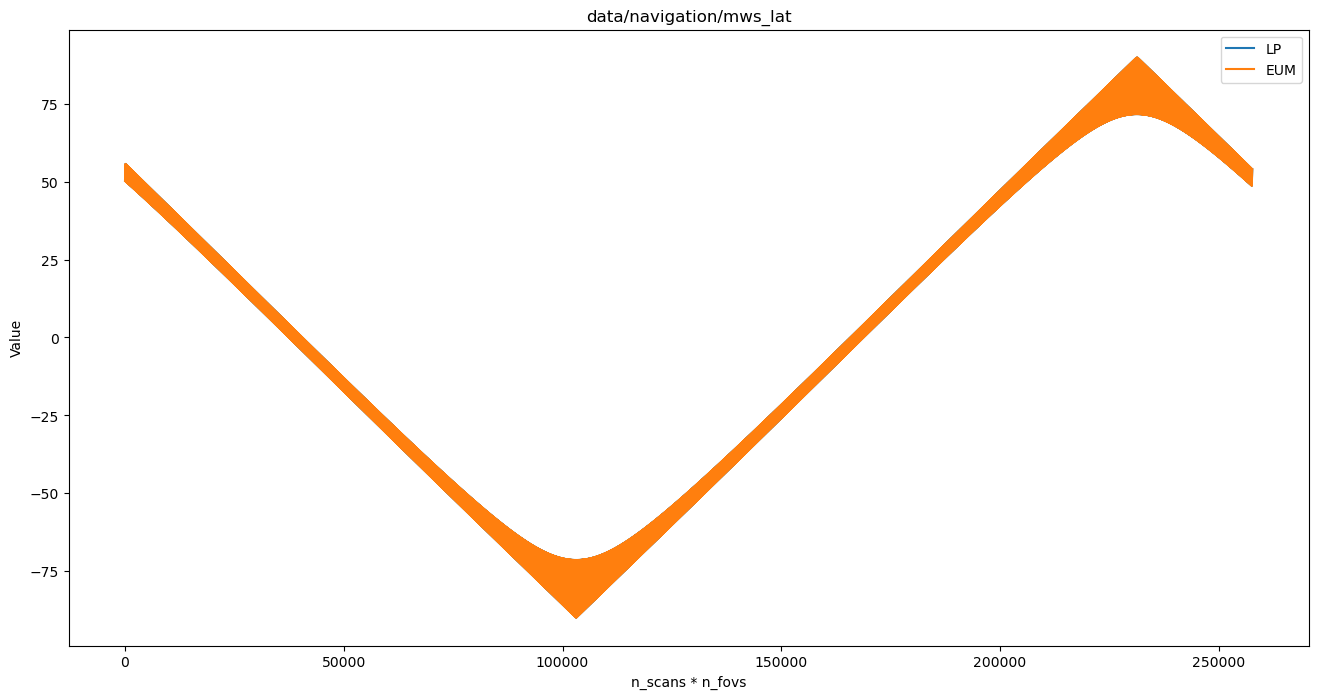

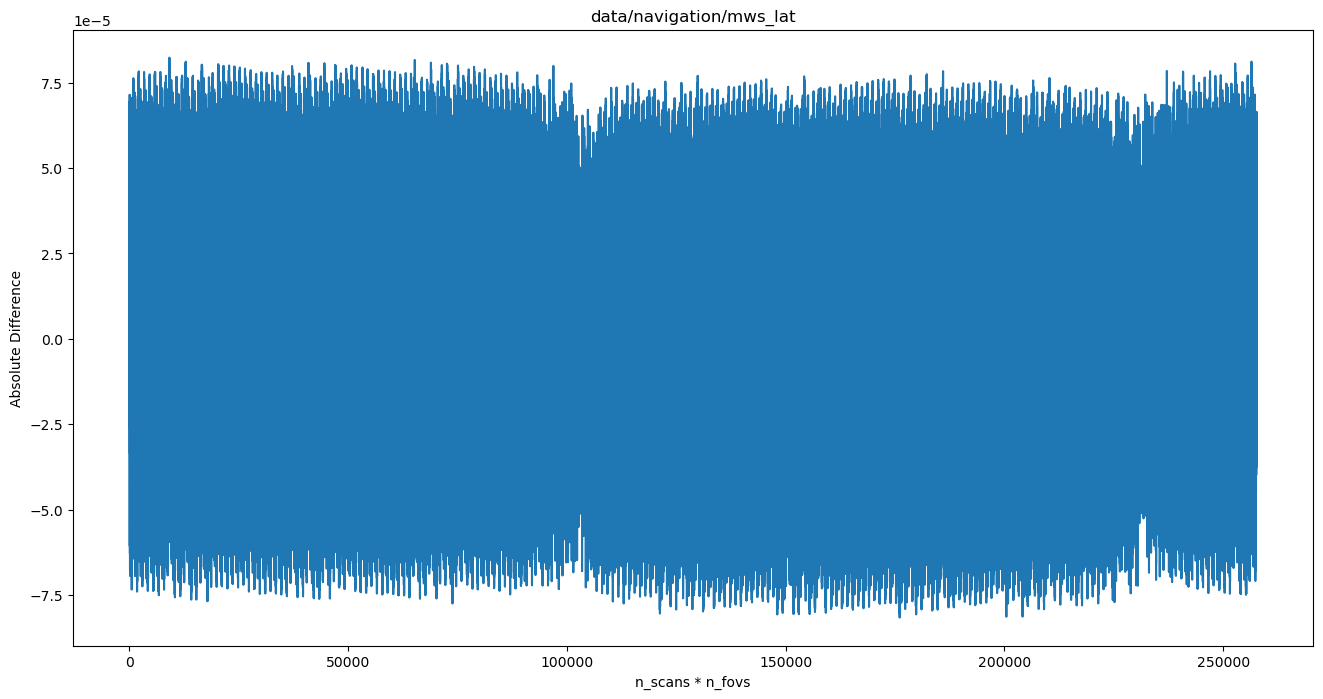

In [5]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lat')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lat')
plt.plot(dif)
plt.show()

## 1.2. mws_lon

In [6]:
variable = "mws_lon"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lon:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lon:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lon(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2712, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lon(n_scans, n_fovs)
    long_name: Longitude corresponding to each field of view
    units: degrees_east
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -1800000
    valid_max: 1800000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lon:
Mean: 2.299e-06 
Minimum: 8.543e-03 
Maximum: 1.189e-02 
RSM: 6.361e-05
-------------------------------------------------------------------------------------------------------------------------

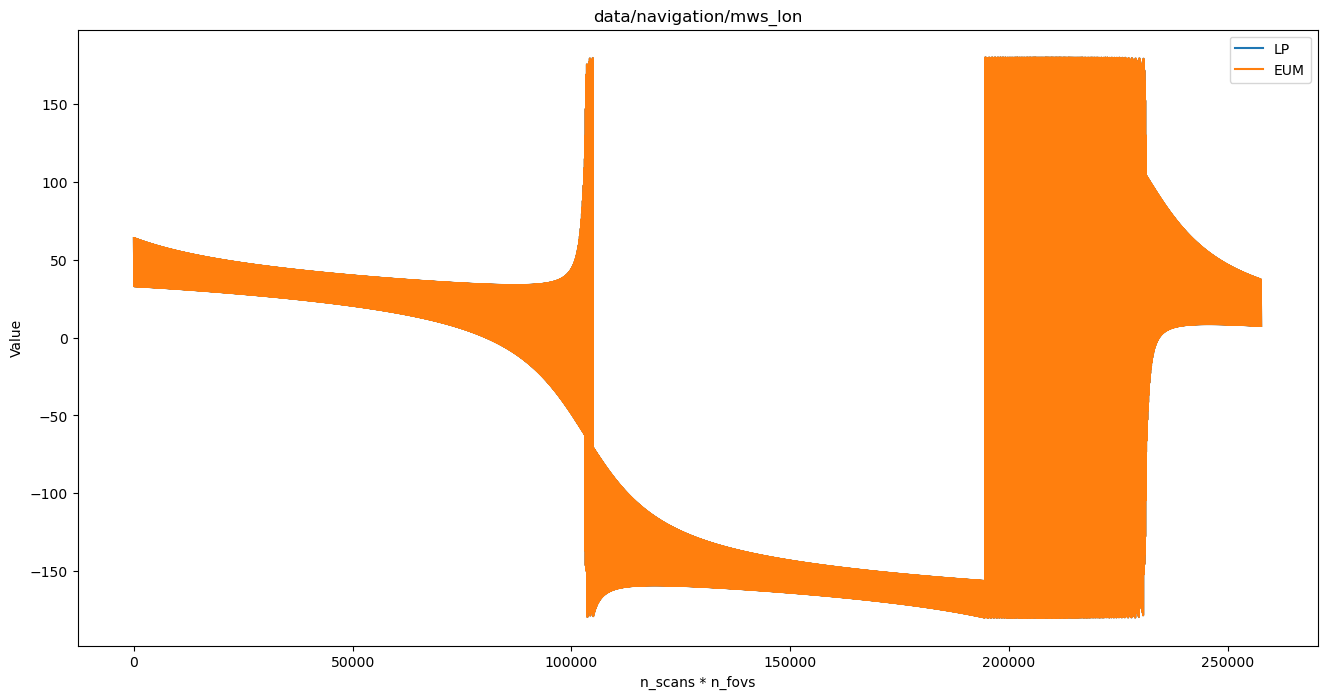

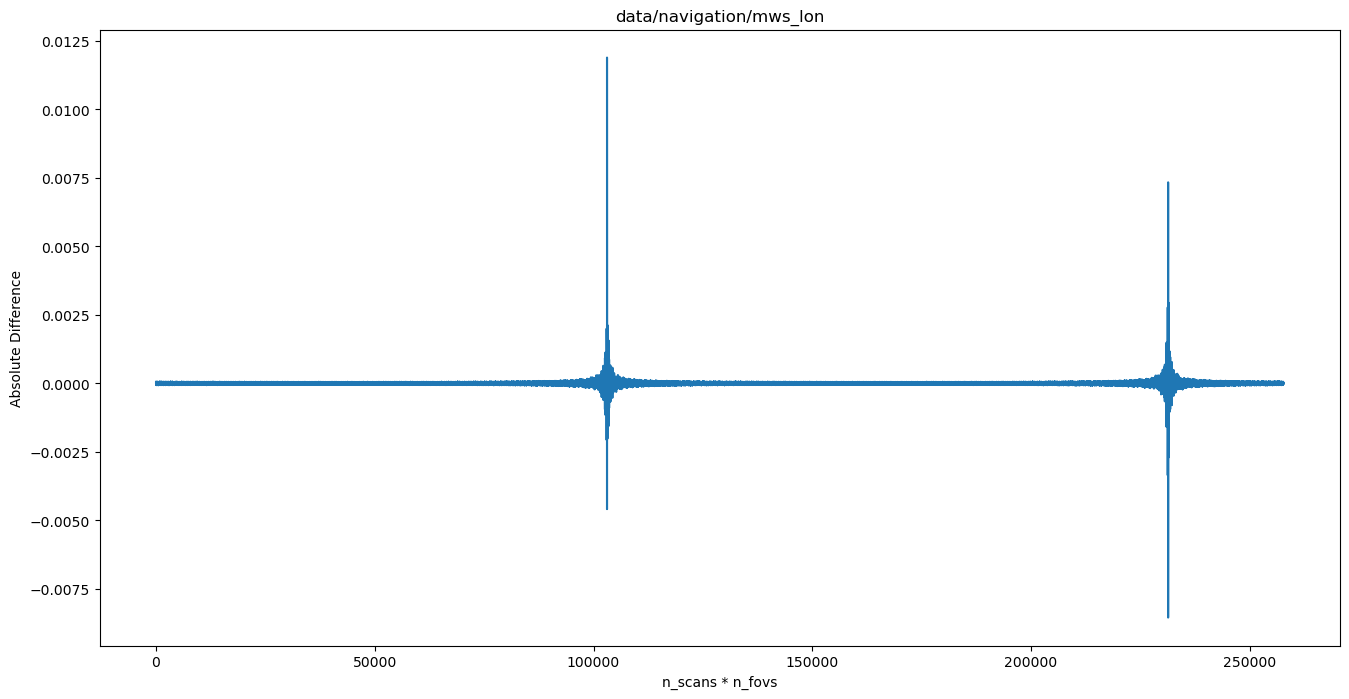

In [7]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lon')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lon')
plt.plot(dif)
plt.show()

## 1.2.1 Distance mws_lat/mws_lon

In [8]:
lon_eum = var_1
lon_lp = var_2

df_eum = pd.DataFrame({'Lon': lon_eum, 'Lat': lat_eum})
df_lp = pd.DataFrame({'Lon': lon_lp, 'Lat': lat_lp})

allowed_error = np.zeros(95)
for i in range(0, 95):
    if (i <= 9) or ((i>=85) and (i<=94)):
        allowed_error[i] = 500
    elif ((i>=10) and (i<=46)) or ((i>=48) and (i<=84)):
        allowed_error[i] = 300
    elif i == 47:
        allowed_error[i] = 200
        
# The desired final length
desired_length = len(df_eum["Lat"])

# Calculate the number of repetitions needed to reach the desired length
num_repetitions = desired_length // len(allowed_error)

# Use tile to repeat the array
repeated_array = np.tile(allowed_error, num_repetitions)

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitude and longitude coordinates.
    
    Parameters:
        lat1, lon1: Latitude and longitude of the first location (in degrees).
        lat2, lon2: Latitude and longitude of the second location (in degrees).
        
    Returns:
        Distance in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in meters (mean radius)
    radius = 6371000  # meters
    
    # Return the distance in meters
    return radius * c

# Example usage
# Assuming df1 and df2 are your Pandas DataFrames with "Lat" and "Lon" columns.
# You can add a new column "Distance" to each DataFrame containing the distance to the reference point (0, 0).

reference_lat = 0  # Replace with your desired reference latitude
reference_lon = 0  # Replace with your desired reference longitude

distance = np.zeros(len(df_eum["Lat"]))
for i in range(len(df_eum["Lat"])):
    distance[i] = haversine_distance(df_eum["Lat"][i], df_eum["Lon"][i], df_lp["Lat"][i], df_lp["Lon"][i])

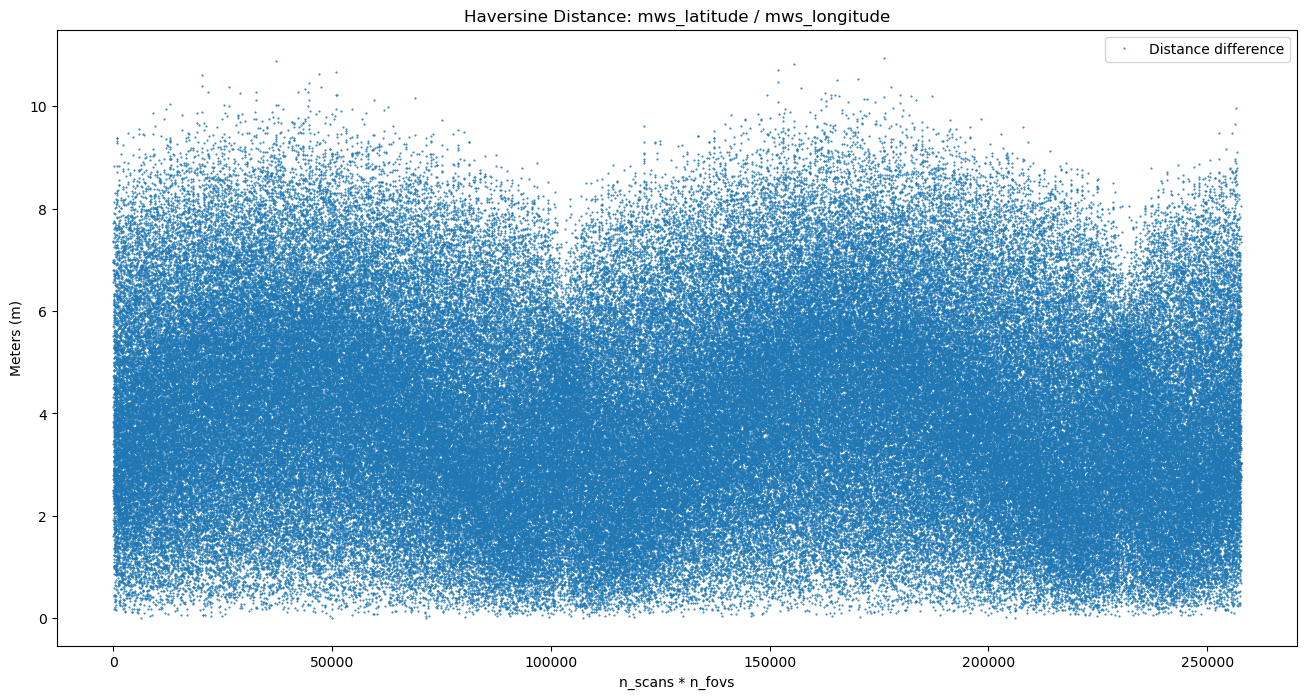

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(distance, ".", markersize="1", label = "Distance difference")
# plt.plot(repeated_array, ".", markersize="1", color = "r", label = "Allowed Abs Error")
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Meters (m)')
plt.title('Haversine Distance: mws_latitude / mws_longitude')
# plt.xticks(range(len(absolute_error_stacked['Rows'].unique())), absolute_error_stacked['Rows'].unique())
# plt.xticks(np.arange(0, 96, step=5))
# plt.tight_layout()
# plt.ylim([0,510])
# plt.xlim([120000,180000])
# plt.xlim([0,250515])
plt.legend(loc='upper right')
# plt.savefig("/home/gsanchez/EPS-SG/pngs/mws_location_TS012_zoom.png")
plt.show()

## 1.3. mws_satellite_azimuth_angle

In [15]:
variable = "satellite_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
variable = "mws_satellite_azimuth_angle"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_satellite_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_satellite_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.02
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 satellite_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2712, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_satellite_azimuth_angle(n_scans, n_fovs)
    long_name: Satellite Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_satellite_azimuth_angle:
Mean: 7.288e-06 
Minimum: 1.071e-02 
Maximum: 1.205e-02 
RSM: 2.874e-03
------------------------------------------------------------------------

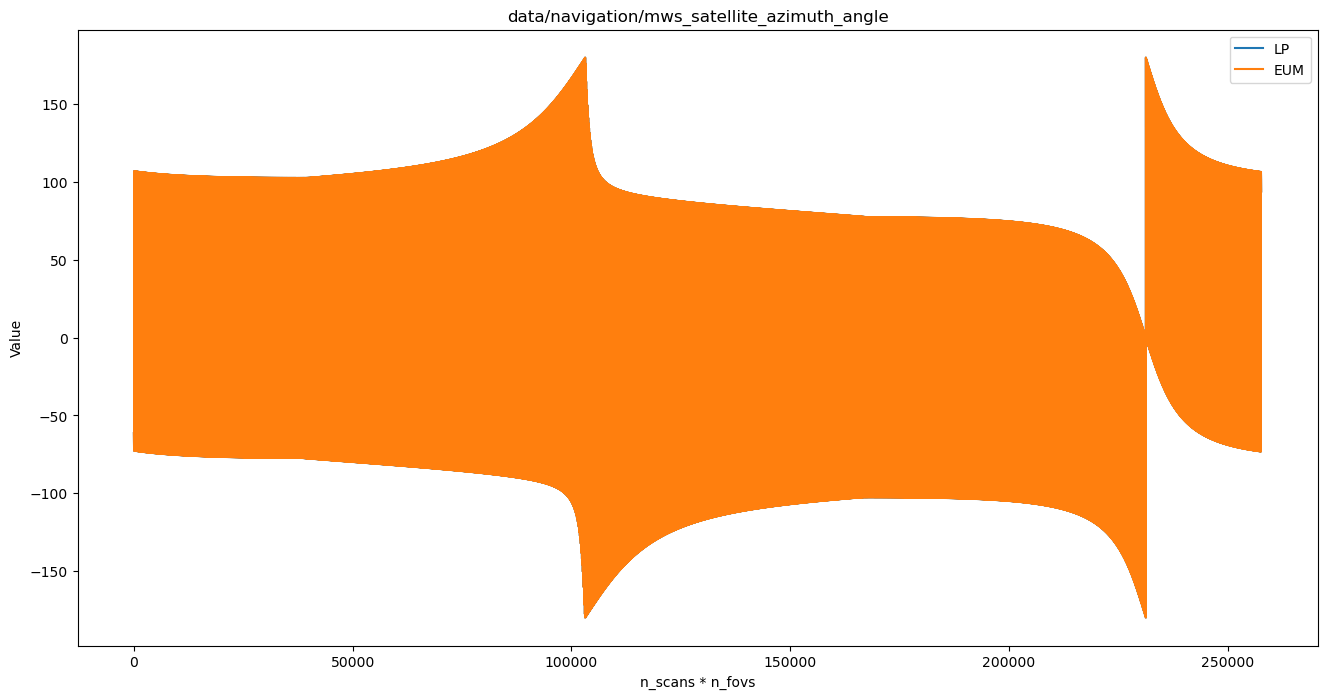

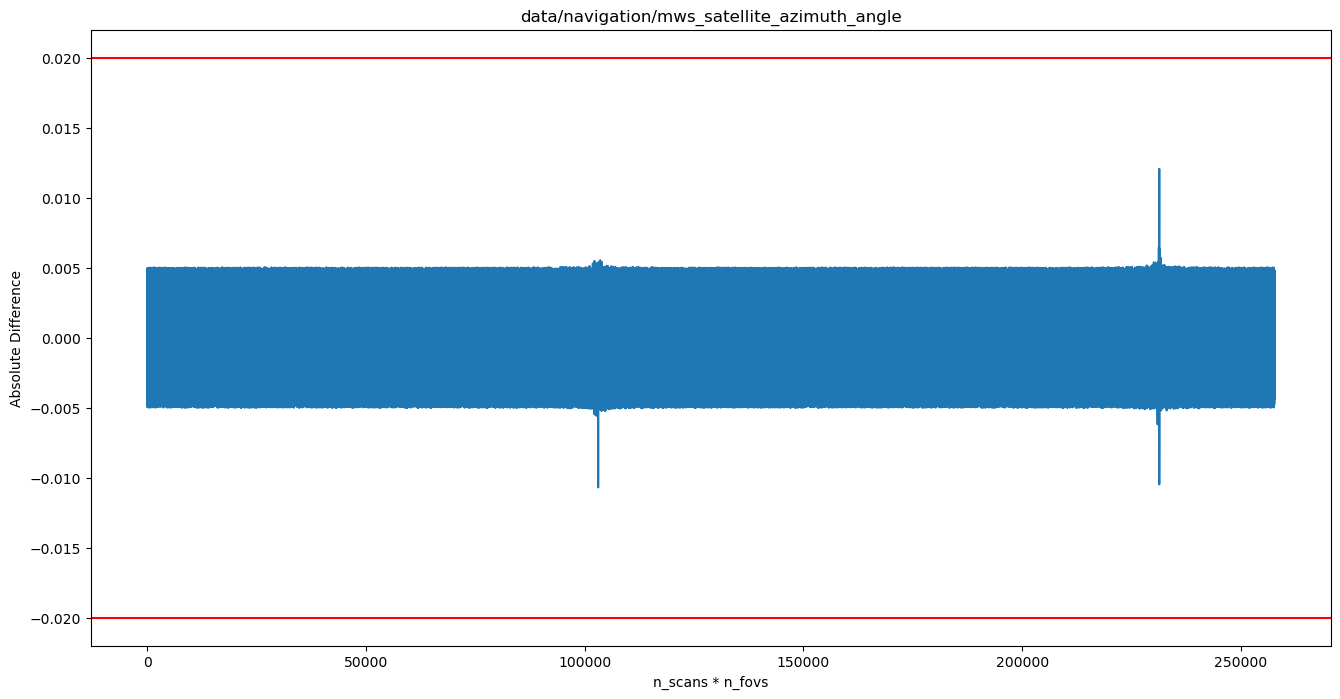

In [17]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.02, color = 'r', linestyle = '-')
plt.axhline(y = -0.02, color = 'r', linestyle = '-')
plt.show()

## 1.4. mws_solar_azimuth_angle

In [19]:
variable = "mws_solar_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_solar_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_solar_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.03
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 mws_solar_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2712, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_solar_azimuth_angle(n_scans, n_fovs)
    long_name: Solar Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_solar_azimuth_angle:
Mean: 1.912e-06 
Minimum: 1.230e-02 
Maximum: 7.075e-03 
RSM: 2.885e-03
------------------------------------------------------------------------------------

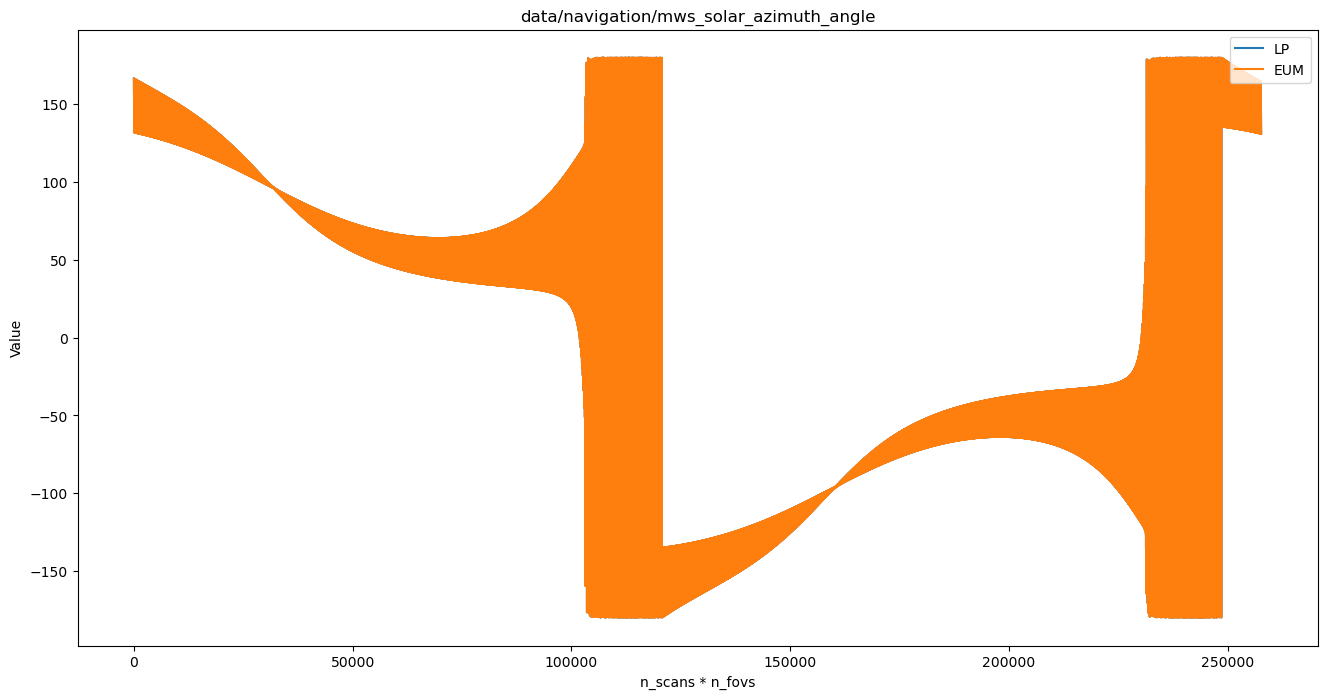

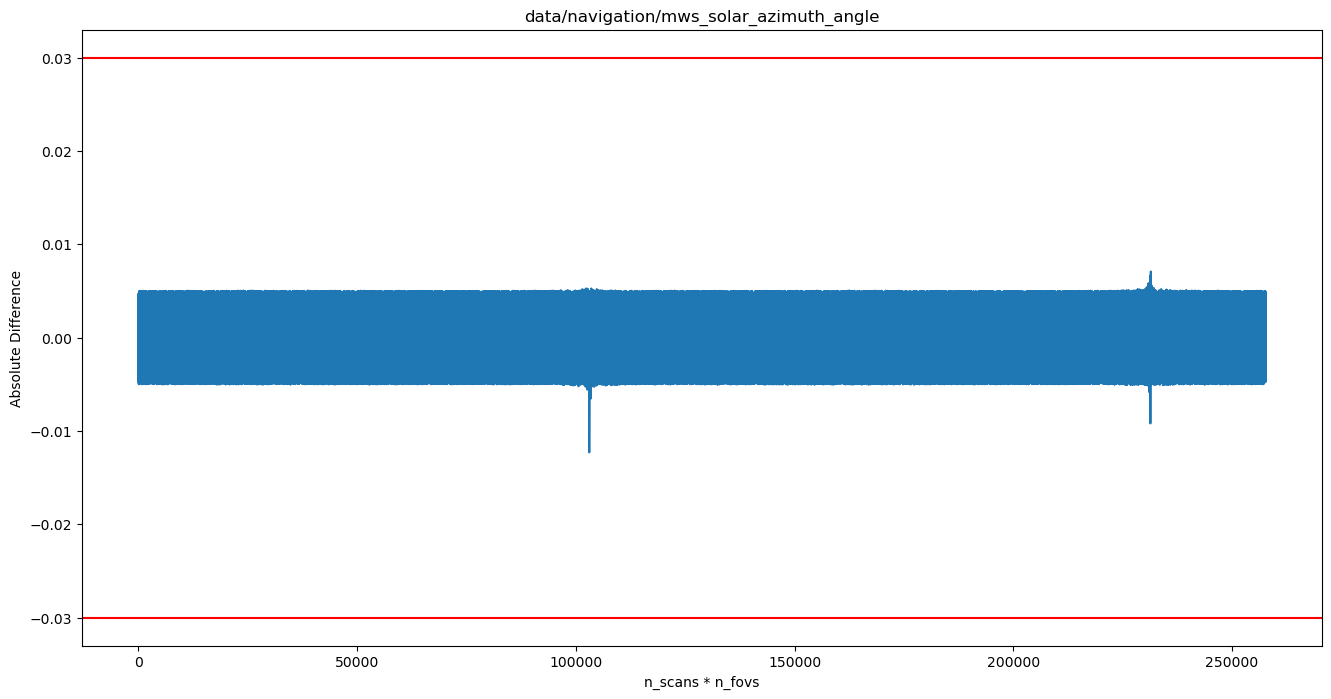

In [20]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.03, color = 'r', linestyle = '-')
plt.axhline(y = -0.03, color = 'r', linestyle = '-')
plt.show()

## 1.5. orbit_angle

In [4]:
variable = "orbit_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for orbit_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for orbit_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies\n ---------------------")
count = 0
thresh = 0.3
for i in range(len(var_1)):
    if np.isnan(mask[i]):
        pass
    else:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print("-"*127)
print("Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 orbit_angle(n_scans)
unlimited dimensions: 
current shape = (2712,)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 orbit_angle(n_scans)
    long_name: Angular position in the orbit, starting at zero when the satellite crosses the solar Ecliptic plane northbound
    units: degrees
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: 0
    valid_max: 3600000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712,)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for orbit_angle:
Mean: -8.945e+01 
Minimum: 3.457e+02 
Maximum: 1.613e+01 
RSM: 1.546e+02
-----------------------------------------------------------------------------

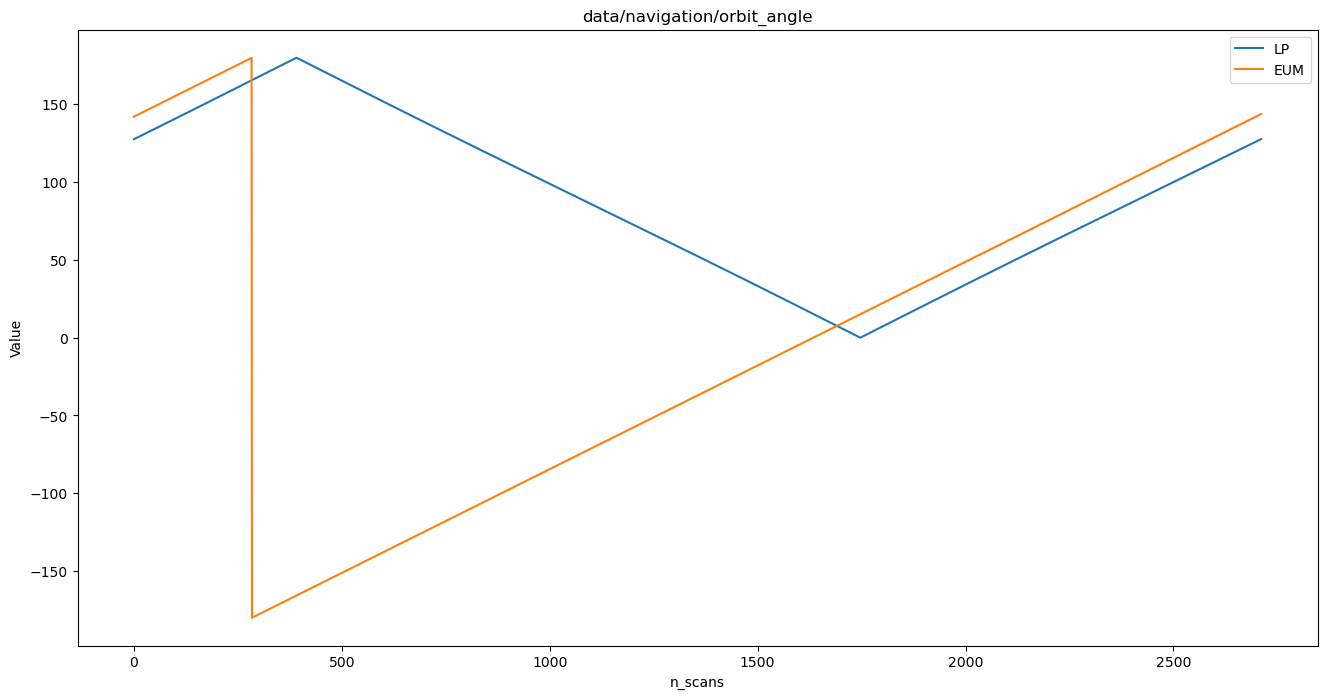

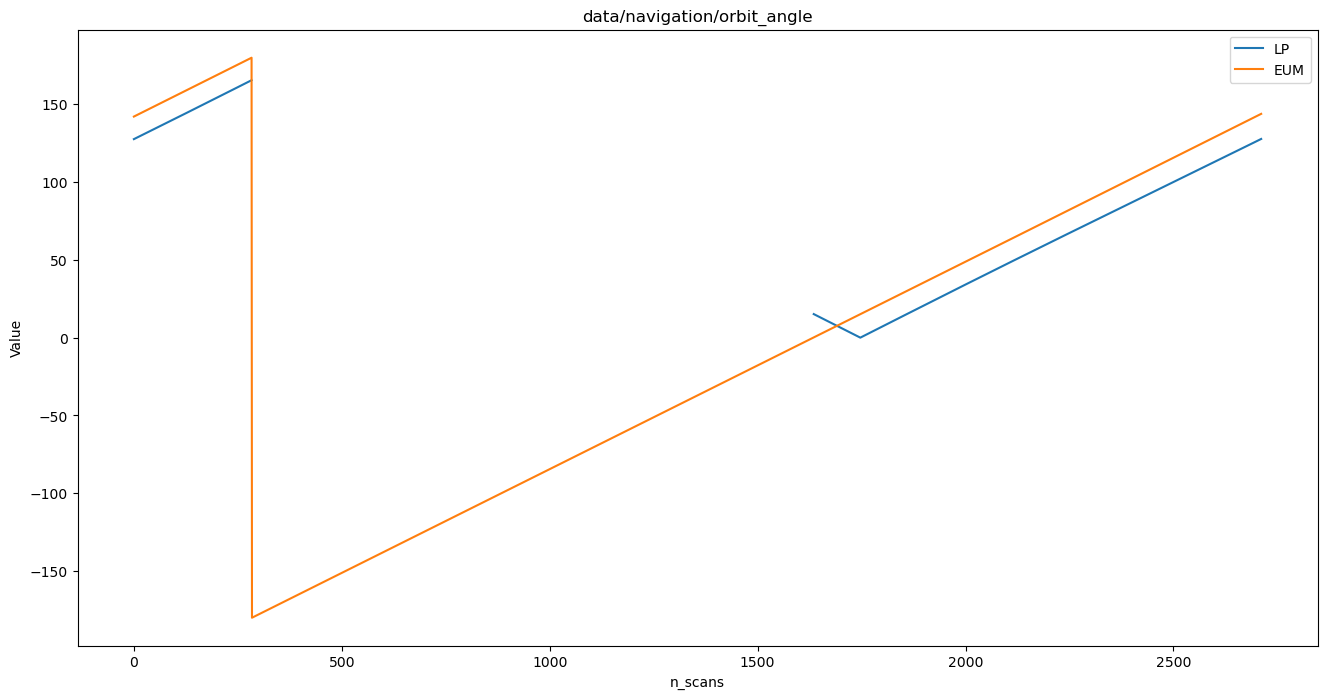

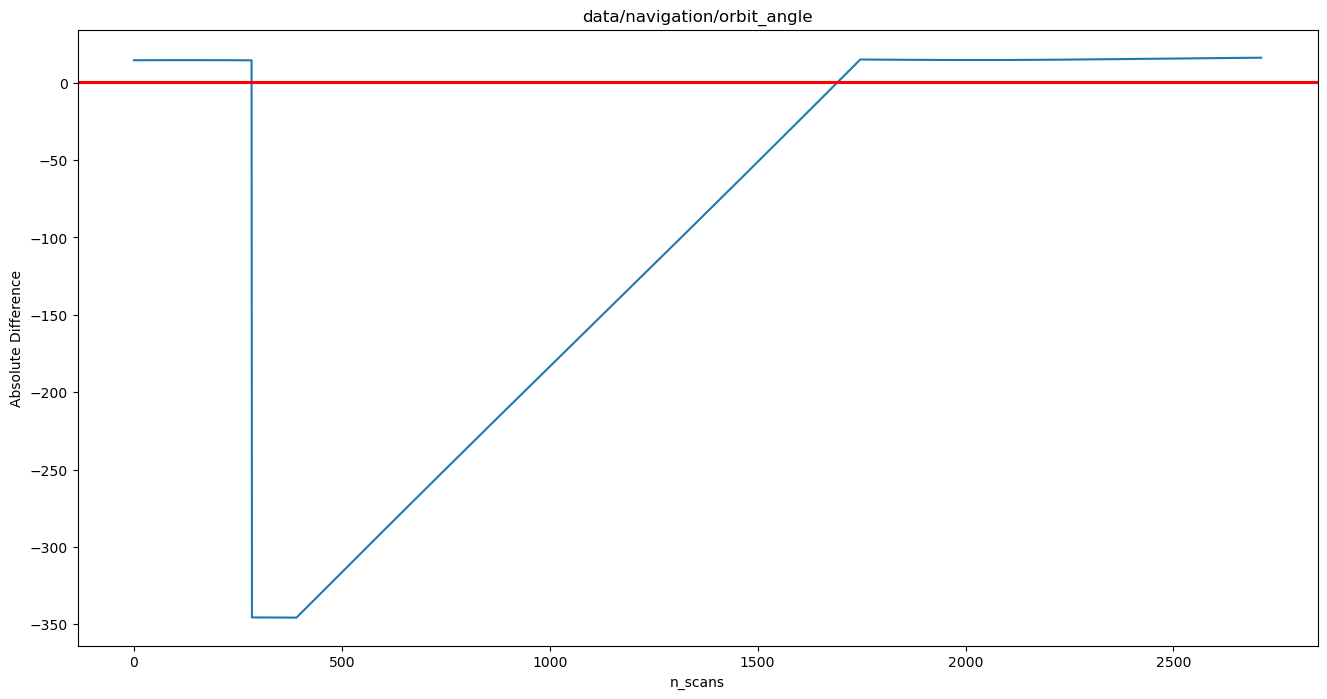

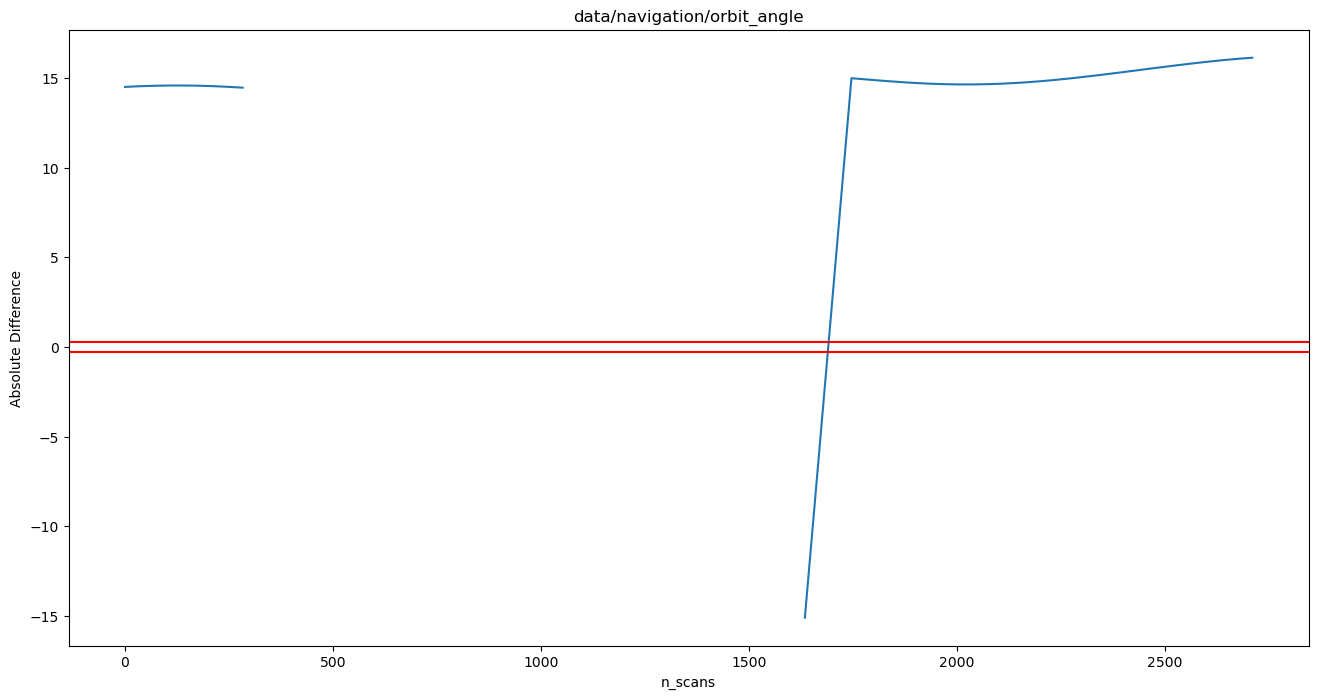

In [8]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

new_var_2 = np.where(mask_eum, np.nan, var_2)
new_var_1 = np.where(mask_LP, np.nan, var_1)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(new_var_2, label="LP")
plt.plot(new_var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

new_dif = np.where(mask, np.nan, dif)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(new_dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

## 1.6. mws_moon_angles

In [22]:
variable = "mws_moon_angles"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_moon_angles:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_moon_angles:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.25
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print(" Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_moon_angles(n_scans, n_fovs_cal)
unlimited dimensions: 
current shape = (2712, 5)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2712
-------------------
<class 'netCDF4._netCDF4.Variable'>
uint16 mws_moon_angles(n_scans, n_fovs_cal)
    long_name: Angle between Moon and individual space views
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: 0
    valid_max: 18000
    missing_value: 65535
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2712, 5)
filling on, default _FillValue of 65535 used
Number of Samples: 2712
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_moon_angles:
Mean: 9.456e-06 
Minimum: 5.004e-03 
Maximum: 5.004e-03 
RSM: 2.892e-03
----------------------------------------------------------------------------------------------------------------------

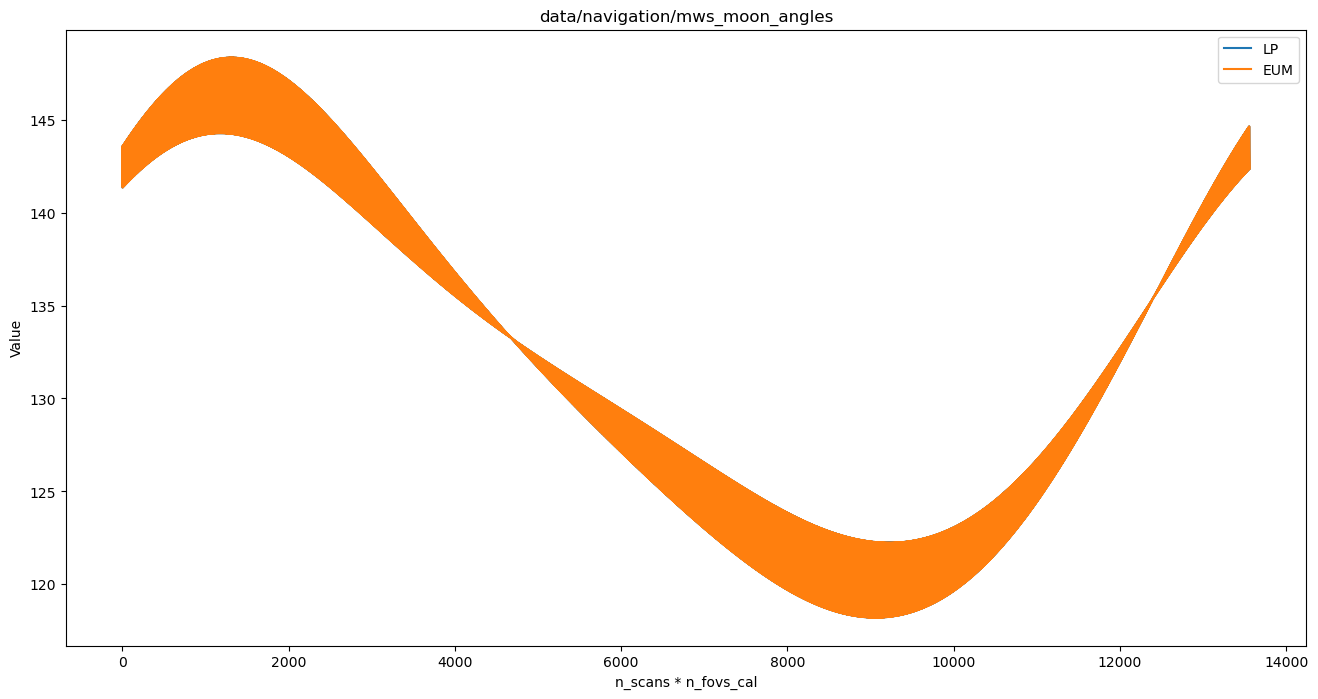

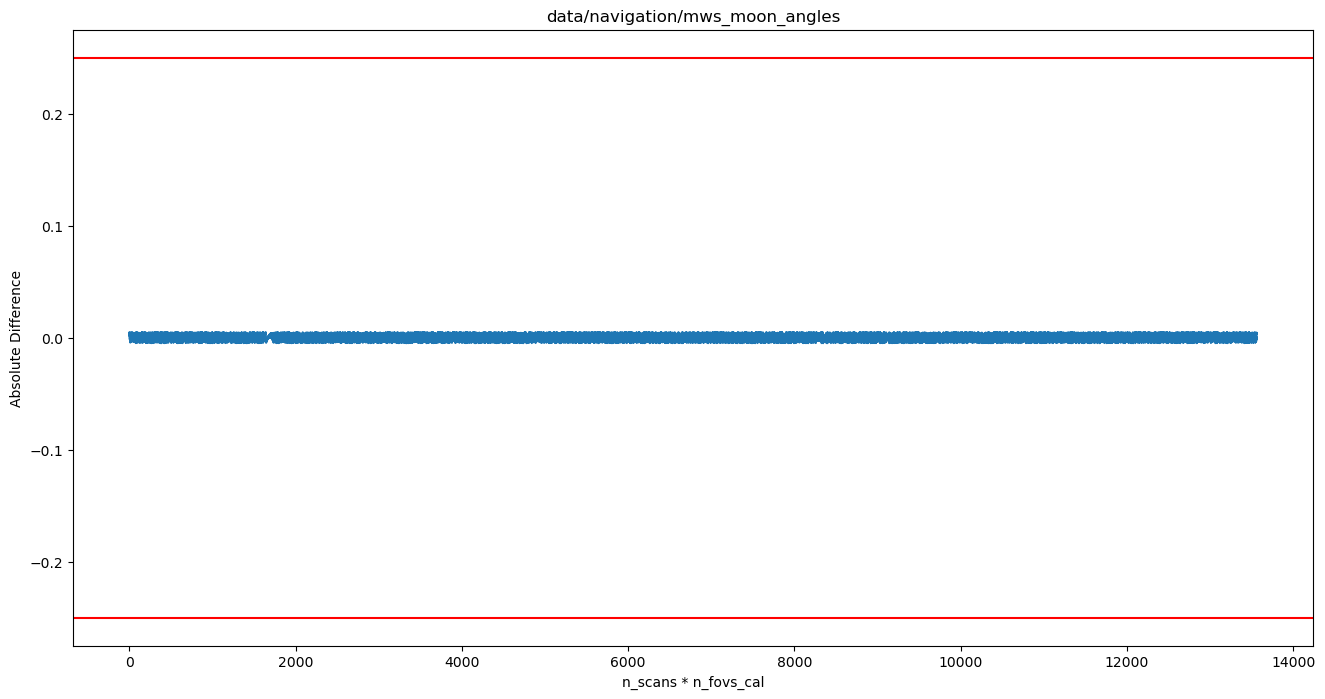

In [23]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Value')
plt.title('data/navigation/mws_moon_angles')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_moon_angles')
plt.plot(dif)
plt.axhline(y = 0.25, color = 'r', linestyle = '-')
plt.axhline(y = -0.25, color = 'r', linestyle = '-')
plt.show()

## 1.7. x_position

In [24]:
variable = "x_position"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for x_position:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for x_position:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 3
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 x_position(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [2752275.65029738]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 x_position()
    long_name: X position of the orbital state vector [EARTH+FIXED]
    units: m
    valid_min: -7200000.0
    valid_max: 7200000.0
    missing_value: -9000000.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 2752277.9991012495
-------------------------------------------------------------------------------------------------------------------------------
Statistics for x_position:
Mean: -2.349e+00 
Minimum: 2.349e+00 
Maximum: 2.349e+00 
RSM: 2.349e+00
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances

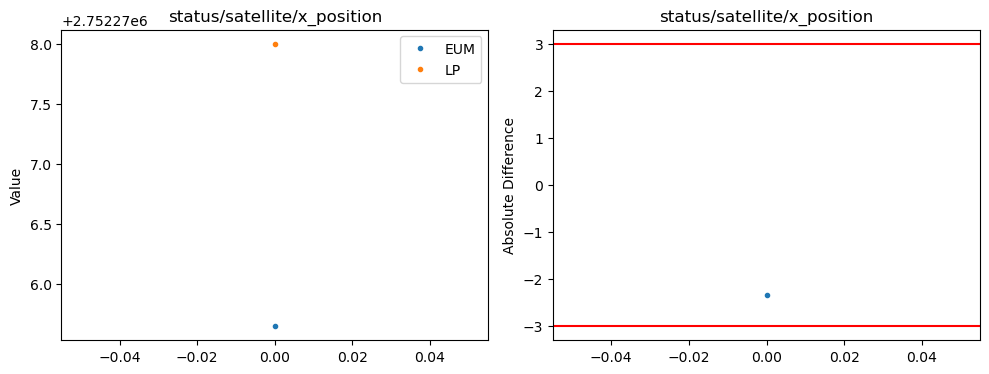

In [25]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/x_position')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -3, color = 'r', linestyle = '-')
axs[1].axhline(y = 3, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/x_position')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## 1.8. eccentricity

In [4]:
variable = "eccentricity"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for eccentricity:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for eccentricity:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 1.5 * 1e-5
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [0.00103518]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity()
    long_name: Eccentricity of the orbit at epoch time[TOD]
    valid_min: 0.0
    valid_max: 0.01
    missing_value: -900.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 0.0010351823486492962
-------------------------------------------------------------------------------------------------------------------------------
Statistics for eccentricity:
Mean: -5.401e-10 
Minimum: 5.401e-10 
Maximum: 5.401e-10 
RSM: 5.401e-10
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref NaN occurances: 0
--------

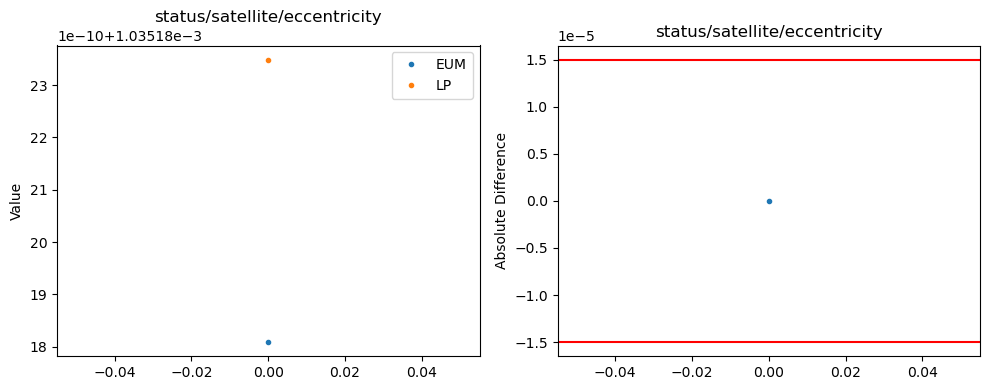

In [5]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/eccentricity')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -thresh, color = 'r', linestyle = '-')
axs[1].axhline(y = thresh, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/eccentricity')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# 2. TS-012

## 2.0. Paths to Files

In [3]:
eum_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/EUM EOCFI ref/MwsInr_Scenario012.nc"
lp_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/MWS LP/TS-012/W_XX-EUMETSAT-Darmstadt,SAT,SGA1-MWS-1B-RAD_C_EUMT_20230831130209_L_D_20070912084321_20070912102225_T_N____.nc"

## 2.1. mws_lat

In [11]:
variable = "mws_lat"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lat:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lat:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

lat_eum = var_1
lat_lp = var_2

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lat(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lat(n_scans, n_fovs)
    long_name: Latitude corresponding to each field of view
    units: degrees_north
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -900000
    valid_max: 900000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lat:
Mean: -1.112e-07 
Minimum: 8.270e-05 
Maximum: 8.226e-05 
RSM: 3.296e-05
--------------------------------------------------------------------------------------------------------------------------

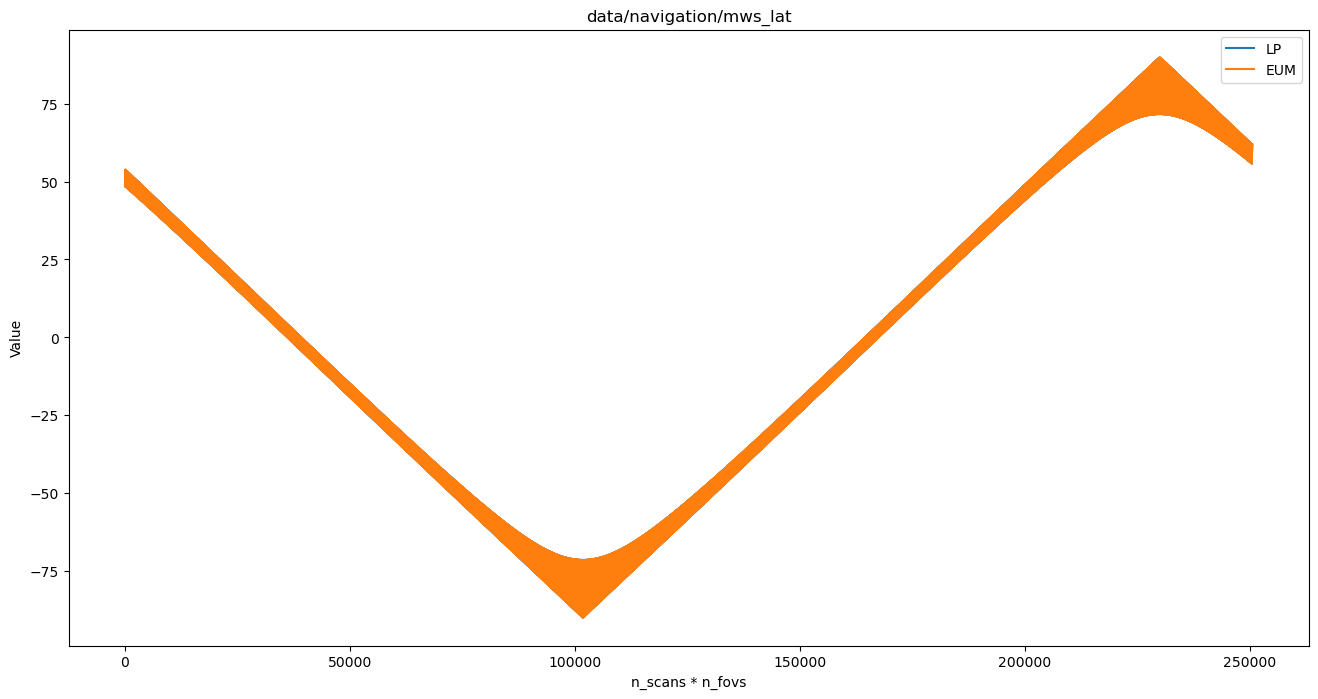

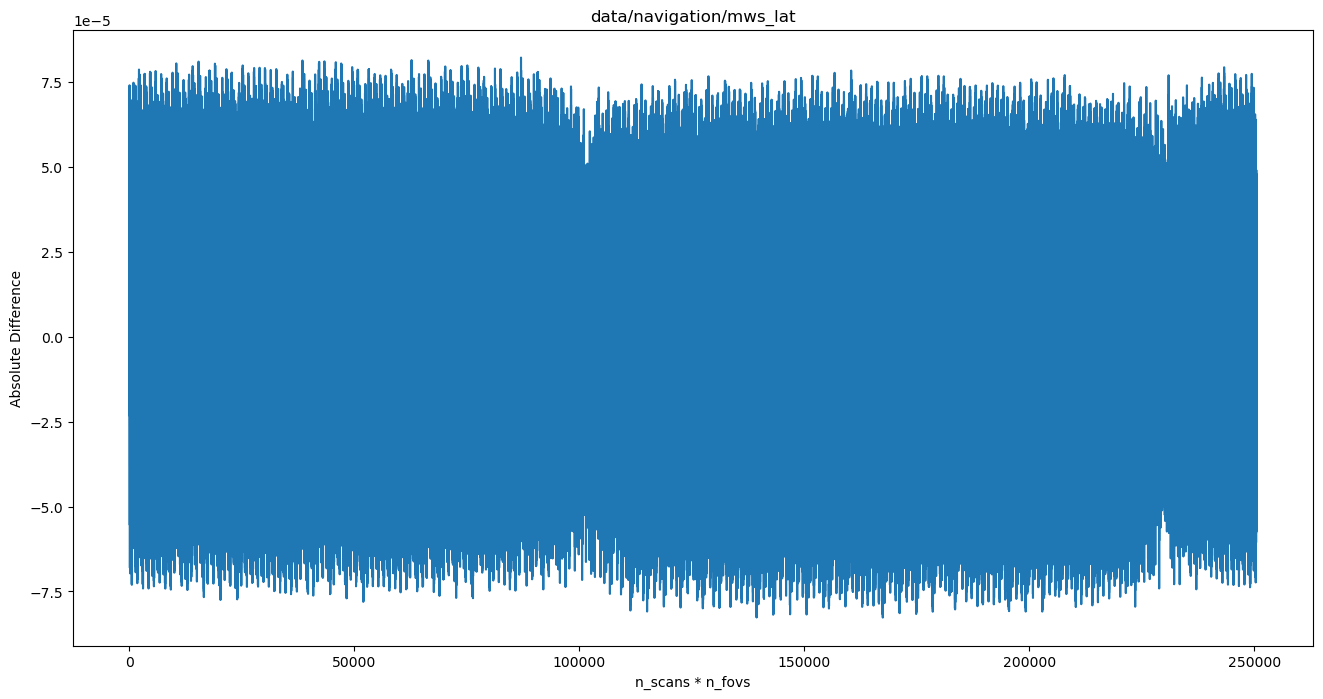

In [12]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lat')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lat')
plt.plot(dif)
plt.show()

## 2.2. mws_lon

In [13]:
variable = "mws_lon"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lon:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lon:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lon(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lon(n_scans, n_fovs)
    long_name: Longitude corresponding to each field of view
    units: degrees_east
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -1800000
    valid_max: 1800000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lon:
Mean: 2.340e-06 
Minimum: 4.349e-03 
Maximum: 1.921e-02 
RSM: 6.928e-05
-------------------------------------------------------------------------------------------------------------------------

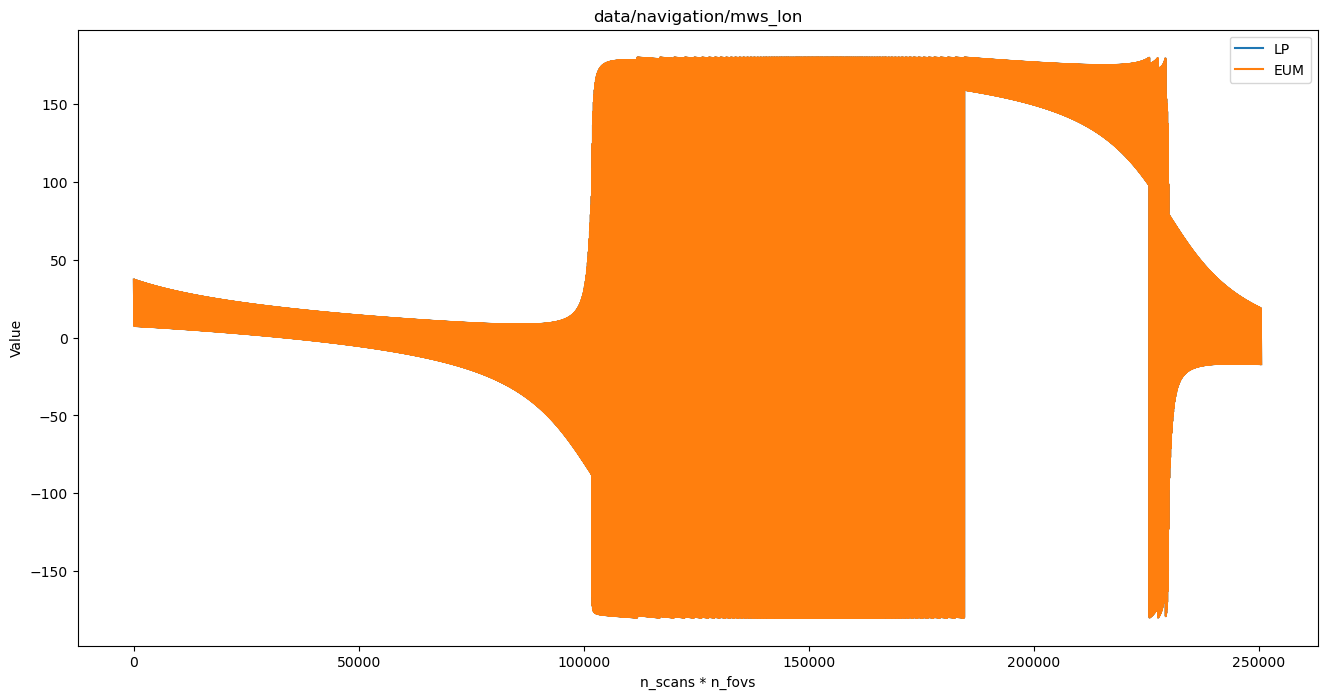

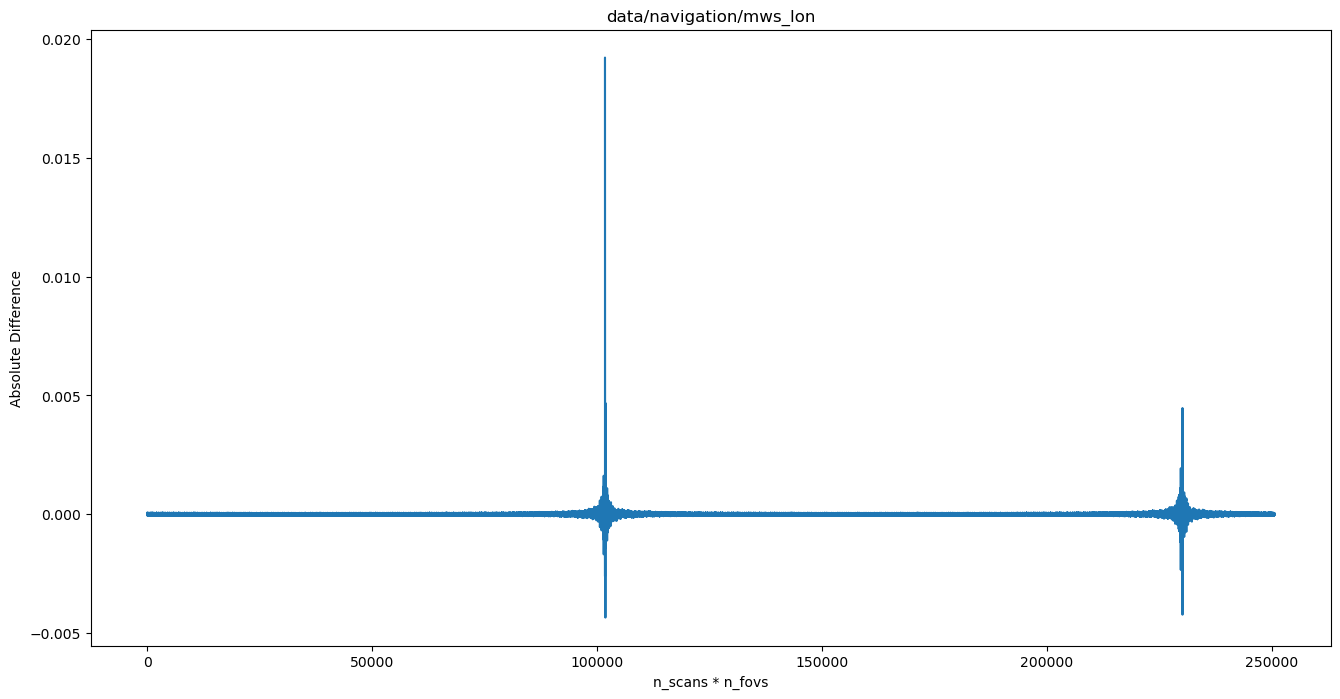

In [14]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lon')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lon')
plt.plot(dif)
plt.show()

## 2.2.1 Distance mws_lat/mws_lon

In [15]:
lon_eum = var_1
lon_lp = var_2

df_eum = pd.DataFrame({'Lon': lon_eum, 'Lat': lat_eum})
df_lp = pd.DataFrame({'Lon': lon_lp, 'Lat': lat_lp})

allowed_error = np.zeros(95)
for i in range(0, 95):
    if (i <= 9) or ((i>=85) and (i<=94)):
        allowed_error[i] = 500
    elif ((i>=10) and (i<=46)) or ((i>=48) and (i<=84)):
        allowed_error[i] = 300
    elif i == 47:
        allowed_error[i] = 200
        
# The desired final length
desired_length = len(df_eum["Lat"])

# Calculate the number of repetitions needed to reach the desired length
num_repetitions = desired_length // len(allowed_error)

# Use tile to repeat the array
repeated_array = np.tile(allowed_error, num_repetitions)

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitude and longitude coordinates.
    
    Parameters:
        lat1, lon1: Latitude and longitude of the first location (in degrees).
        lat2, lon2: Latitude and longitude of the second location (in degrees).
        
    Returns:
        Distance in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in meters (mean radius)
    radius = 6371000  # meters
    
    # Return the distance in meters
    return radius * c

# Example usage
# Assuming df1 and df2 are your Pandas DataFrames with "Lat" and "Lon" columns.
# You can add a new column "Distance" to each DataFrame containing the distance to the reference point (0, 0).

reference_lat = 0  # Replace with your desired reference latitude
reference_lon = 0  # Replace with your desired reference longitude

distance = np.zeros(len(df_eum["Lat"]))
for i in range(len(df_eum["Lat"])):
    distance[i] = haversine_distance(df_eum["Lat"][i], df_eum["Lon"][i], df_lp["Lat"][i], df_lp["Lon"][i])

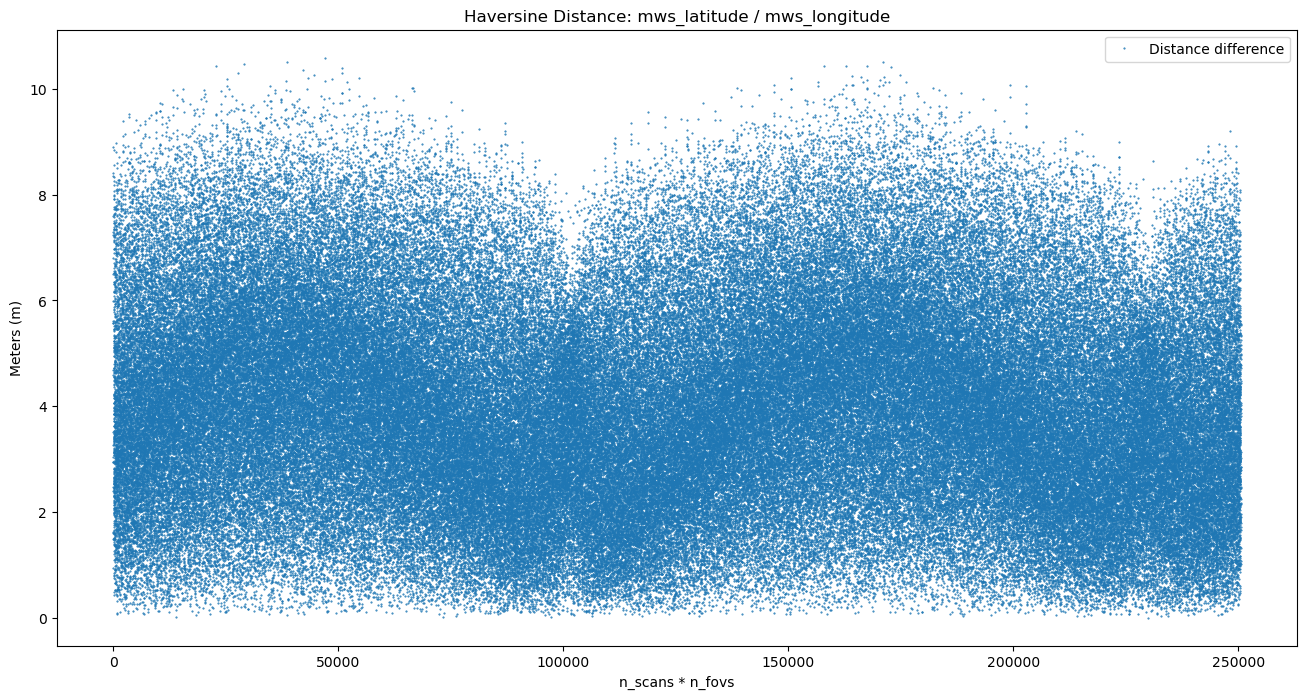

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(distance, ".", markersize="1", label = "Distance difference")
# plt.plot(repeated_array, ".", markersize="1", color = "r", label = "Allowed Abs Error")
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Meters (m)')
plt.title('Haversine Distance: mws_latitude / mws_longitude')
# plt.xticks(range(len(absolute_error_stacked['Rows'].unique())), absolute_error_stacked['Rows'].unique())
# plt.xticks(np.arange(0, 96, step=5))
# plt.tight_layout()
# plt.ylim([0,510])
# plt.xlim([120000,180000])
# plt.xlim([0,250515])
plt.legend(loc='upper right')
# plt.savefig("/home/gsanchez/EPS-SG/pngs/mws_location_TS012_zoom.png")
plt.show()

## 2.3. mws_satellite_azimuth_angle

In [17]:
variable = "satellite_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
variable = "mws_satellite_azimuth_angle"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_satellite_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_satellite_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.02
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 satellite_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_satellite_azimuth_angle(n_scans, n_fovs)
    long_name: Satellite Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_satellite_azimuth_angle:
Mean: 5.754e-06 
Minimum: 1.647e-02 
Maximum: 9.156e-03 
RSM: 2.871e-03
------------------------------------------------------------------------

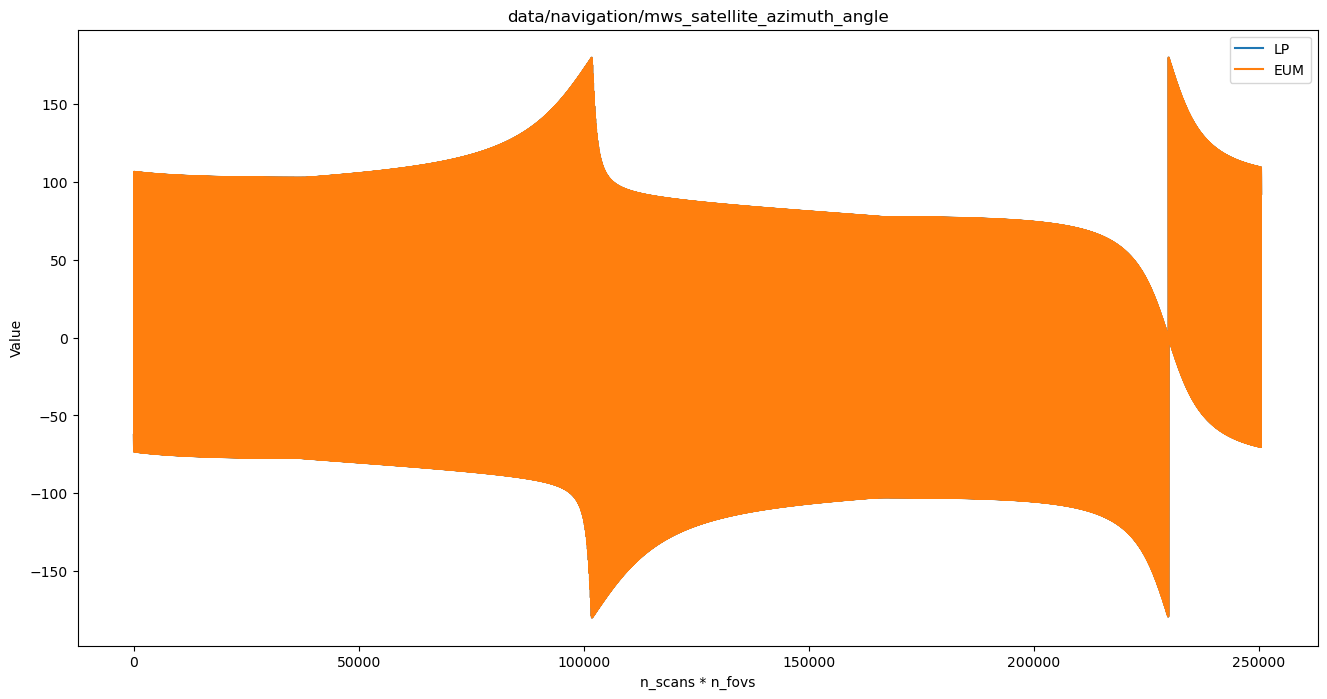

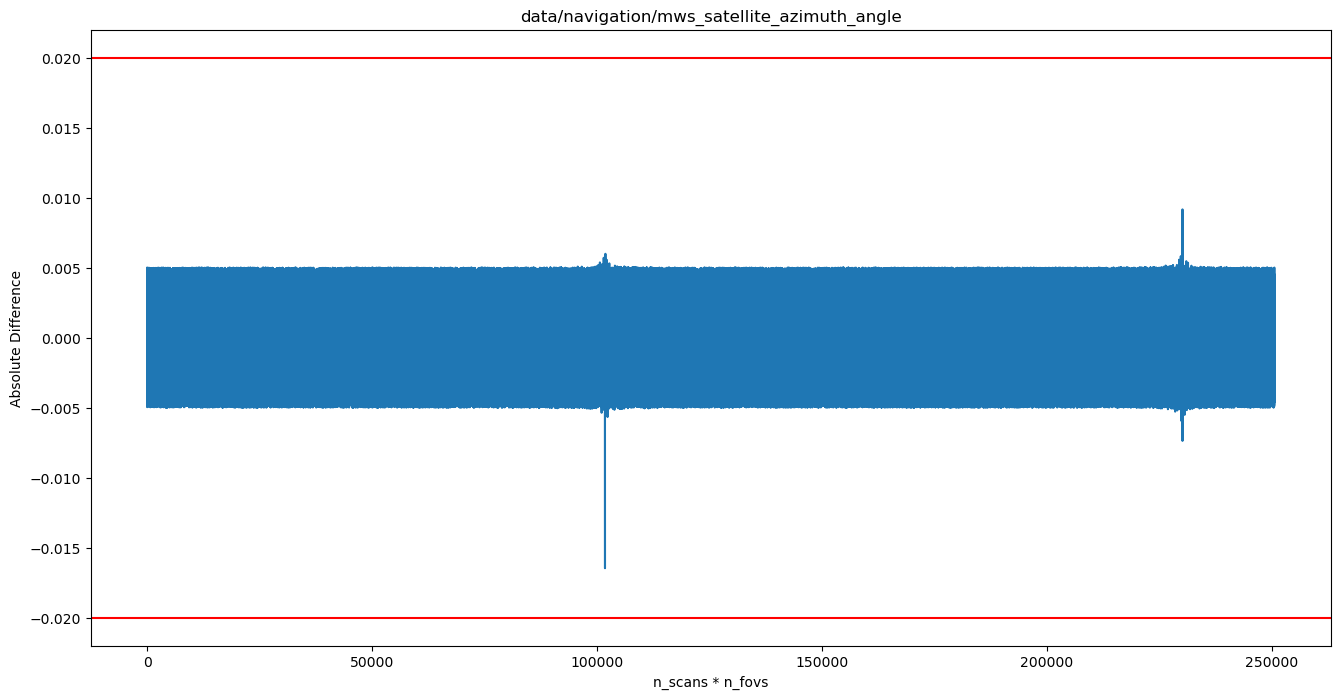

In [18]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.02, color = 'r', linestyle = '-')
plt.axhline(y = -0.02, color = 'r', linestyle = '-')
plt.show()

## 2.4. mws_solar_azimuth_angle

In [4]:
variable = "mws_solar_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_solar_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_solar_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.03
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 mws_solar_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_solar_azimuth_angle(n_scans, n_fovs)
    long_name: Solar Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_solar_azimuth_angle:
Mean: 8.442e-07 
Minimum: 1.726e-02 
Maximum: 8.263e-03 
RSM: 2.886e-03
------------------------------------------------------------------------------------

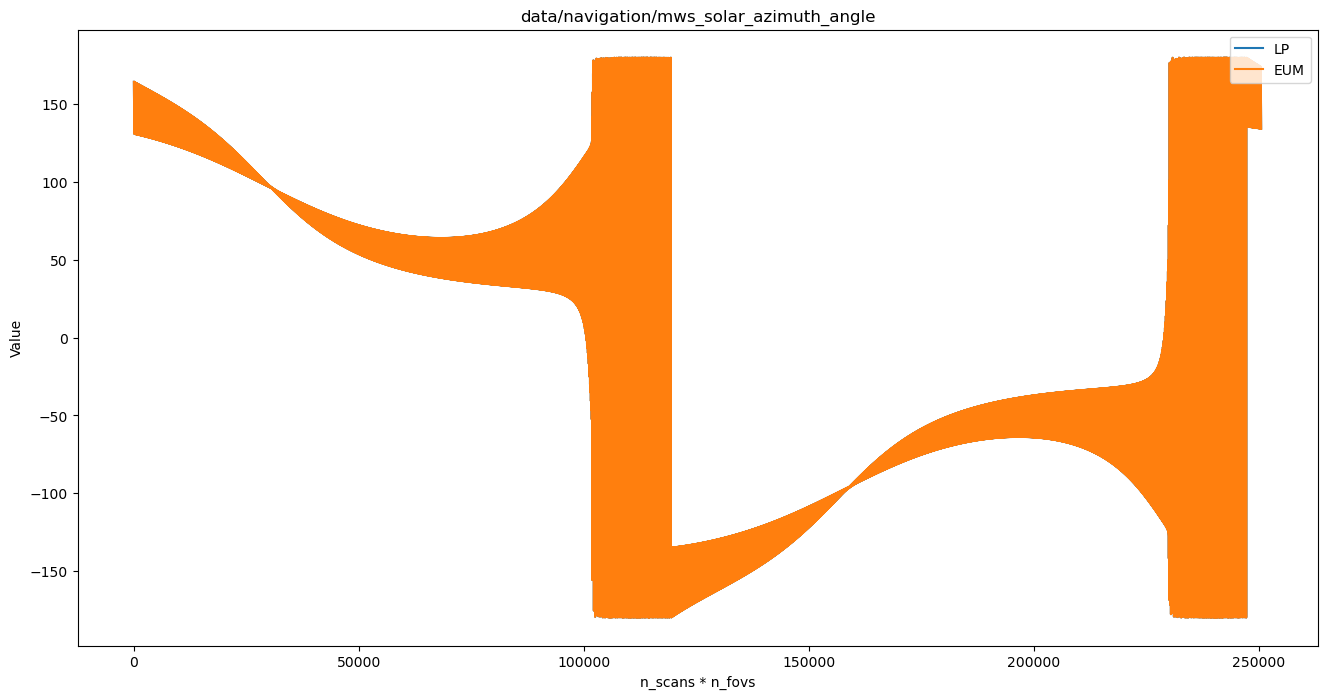

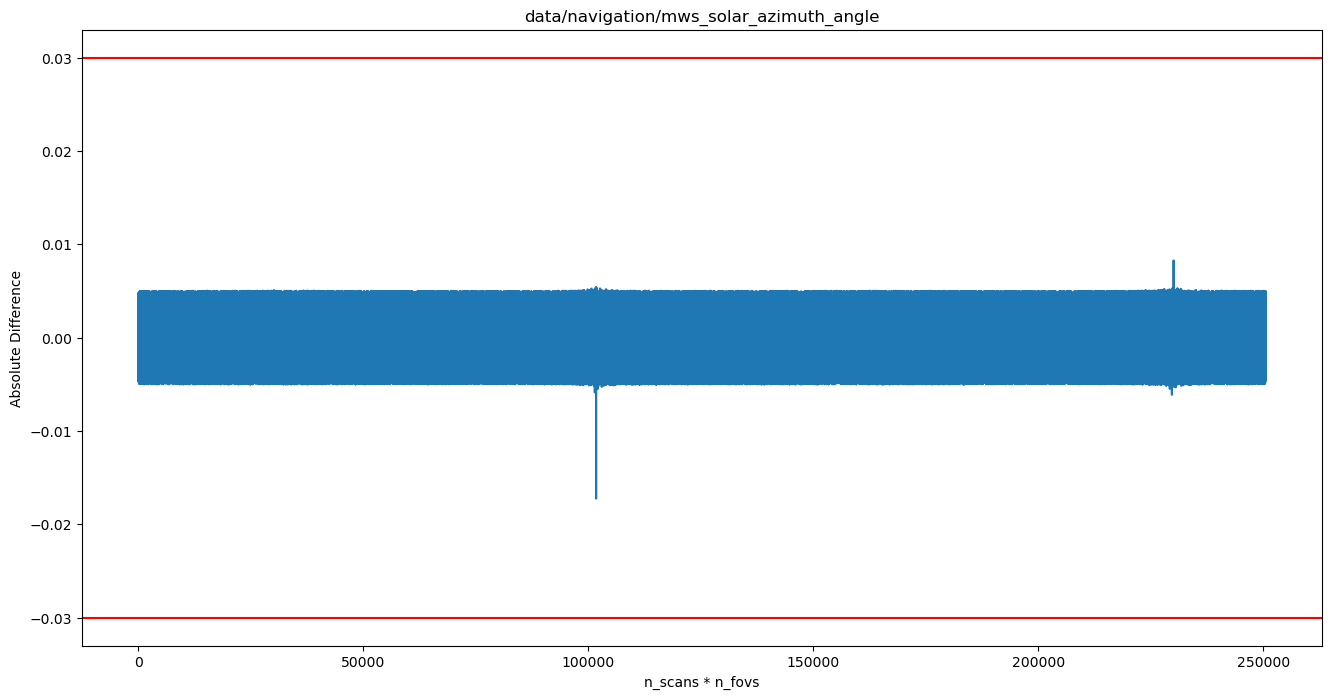

In [5]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.03, color = 'r', linestyle = '-')
plt.axhline(y = -0.03, color = 'r', linestyle = '-')
plt.show()

## 2.5. orbit_angle

In [6]:
variable = "orbit_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for orbit_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for orbit_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies\n ---------------------")
count = 0
thresh = 0.3
for i in range(len(var_1)):
    if np.isnan(mask[i]):
        pass
    else:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print("-"*127)
print("Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 orbit_angle(n_scans)
unlimited dimensions: 
current shape = (2637,)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 orbit_angle(n_scans)
    long_name: Angular position in the orbit, starting at zero when the satellite crosses the solar Ecliptic plane northbound
    units: degrees
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: 0
    valid_max: 3600000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637,)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for orbit_angle:
Mean: -9.222e+01 
Minimum: 3.441e+02 
Maximum: 1.988e+01 
RSM: 1.577e+02
-----------------------------------------------------------------------------

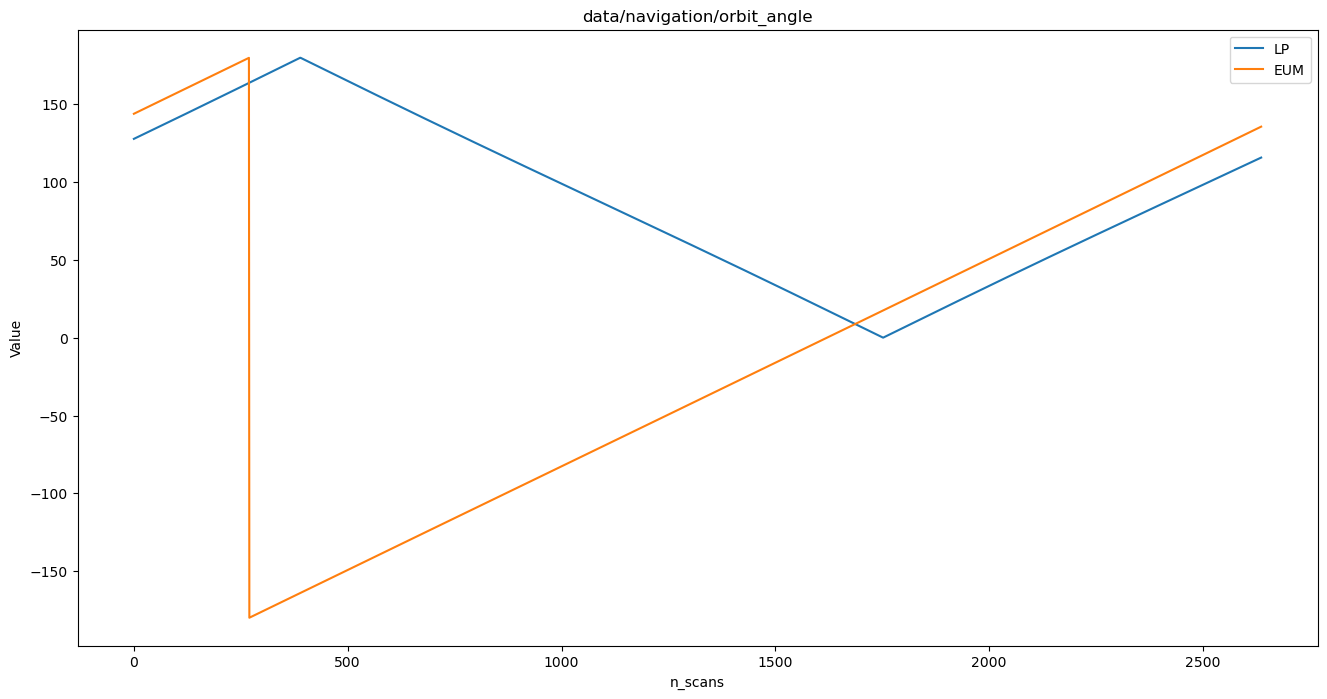

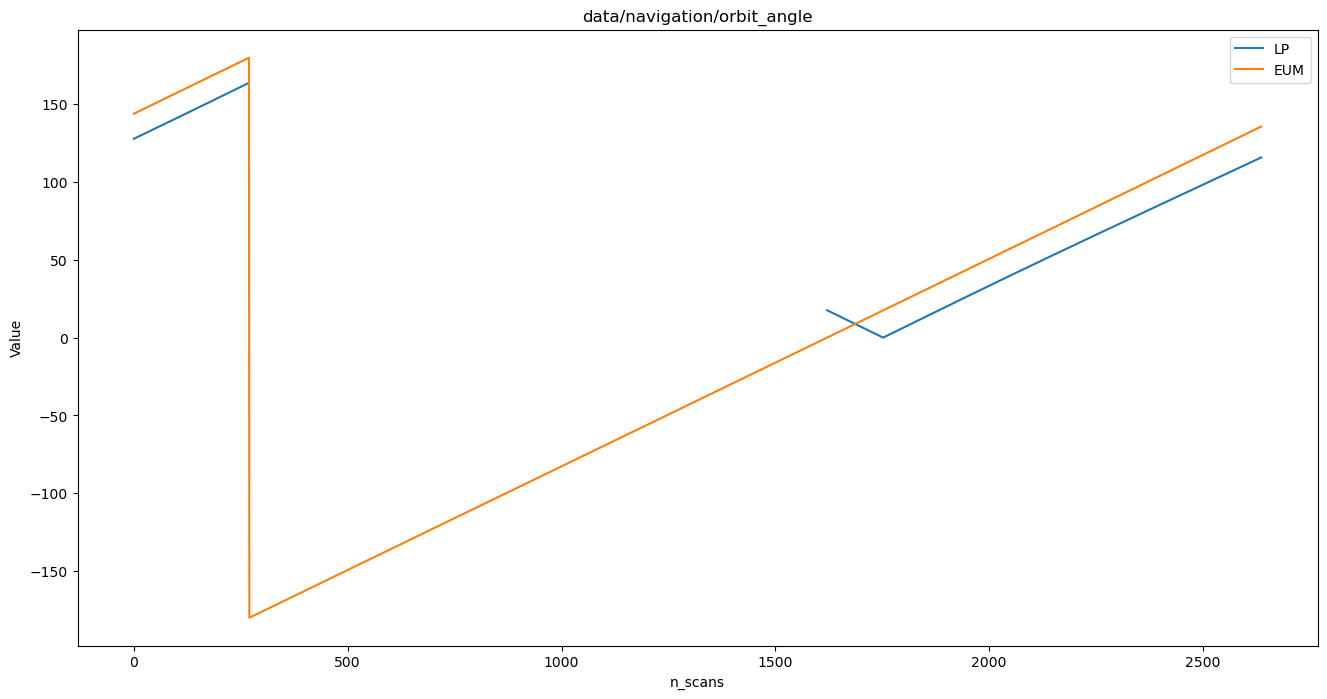

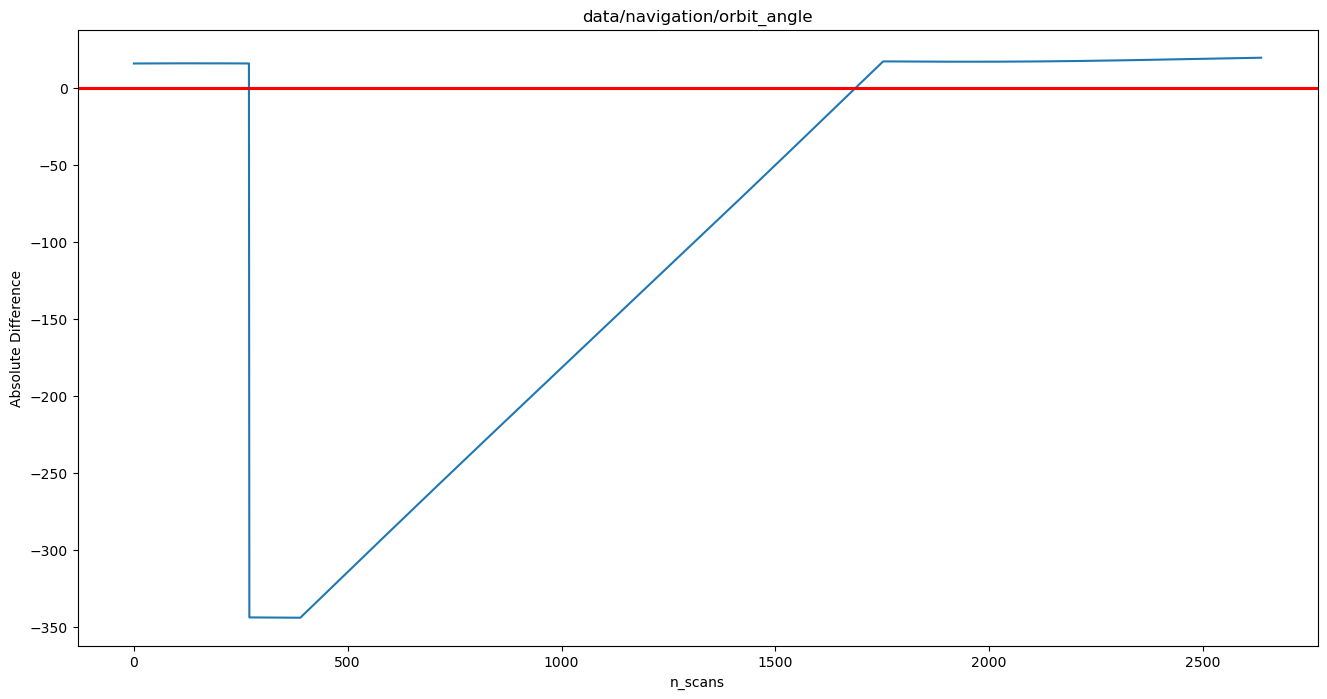

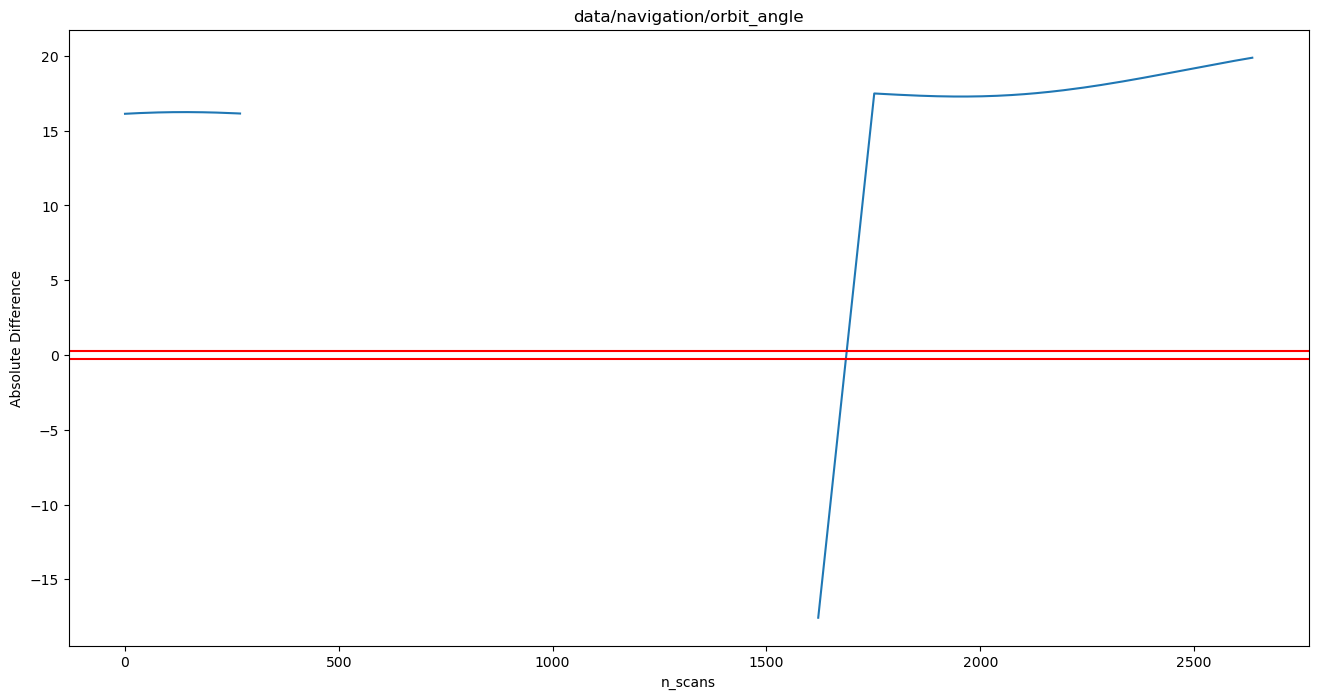

In [7]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

new_var_2 = np.where(mask_eum, np.nan, var_2)
new_var_1 = np.where(mask_LP, np.nan, var_1)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(new_var_2, label="LP")
plt.plot(new_var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

new_dif = np.where(mask, np.nan, dif)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(new_dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

## 2.6. mws_moon_angles

In [8]:
variable = "mws_moon_angles"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_moon_angles:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_moon_angles:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.25
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print(" Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_moon_angles(n_scans, n_fovs_cal)
unlimited dimensions: 
current shape = (2637, 5)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
uint16 mws_moon_angles(n_scans, n_fovs_cal)
    long_name: Angle between Moon and individual space views
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: 0
    valid_max: 18000
    missing_value: 65535
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 5)
filling on, default _FillValue of 65535 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_moon_angles:
Mean: 3.743e-05 
Minimum: 4.999e-03 
Maximum: 5.002e-03 
RSM: 2.888e-03
----------------------------------------------------------------------------------------------------------------------

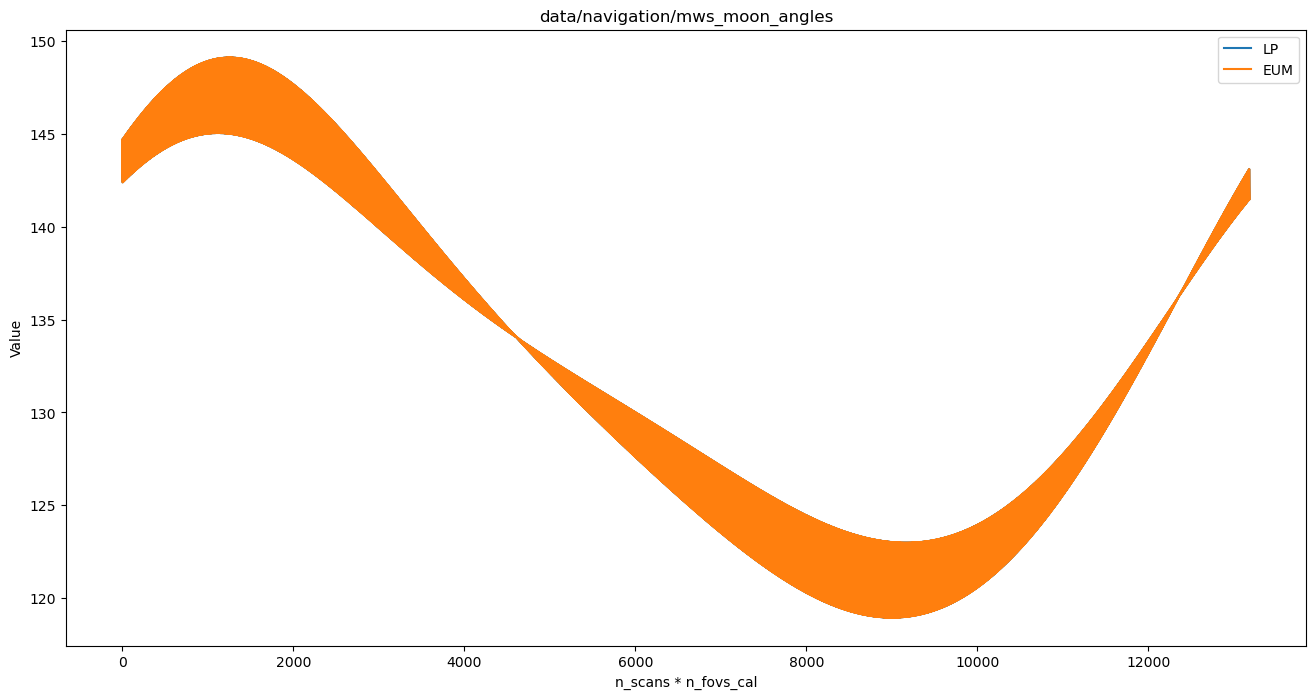

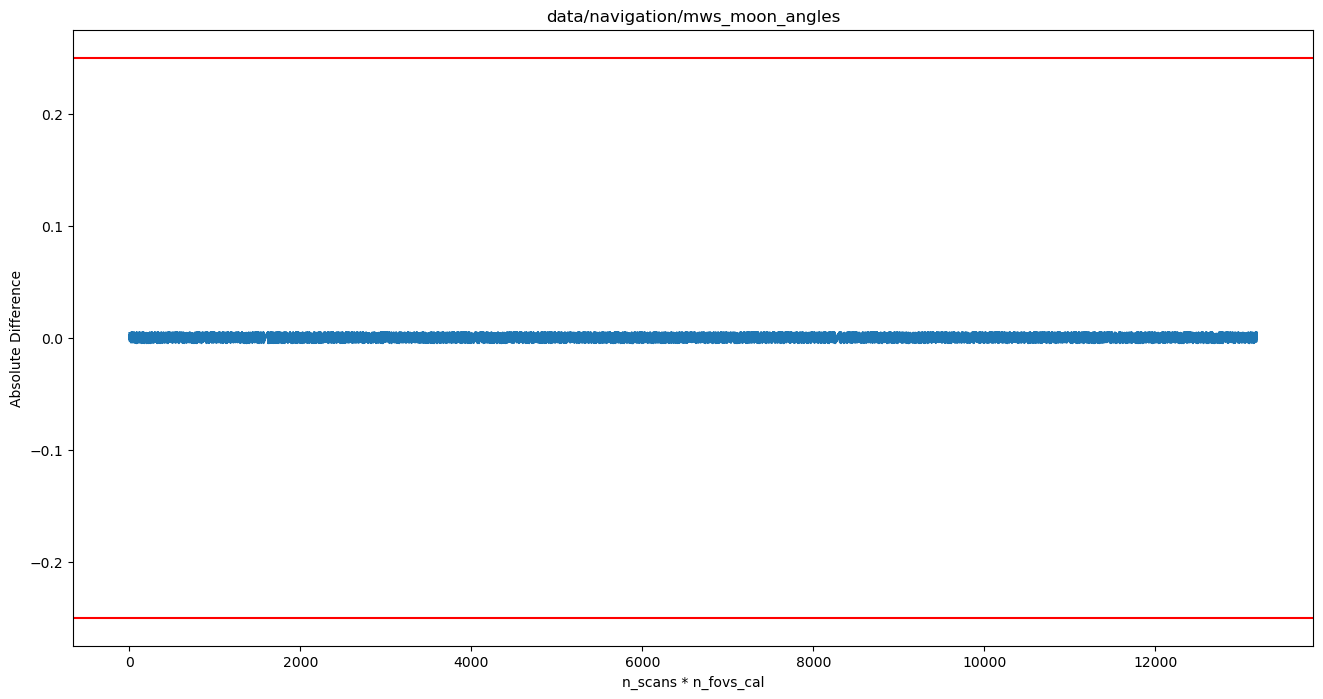

In [9]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Value')
plt.title('data/navigation/mws_moon_angles')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_moon_angles')
plt.plot(dif)
plt.axhline(y = 0.25, color = 'r', linestyle = '-')
plt.axhline(y = -0.25, color = 'r', linestyle = '-')
plt.show()

## 1.7. x_position

In [10]:
variable = "x_position"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for x_position:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for x_position:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 3
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 x_position(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [4065168.34]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 x_position()
    long_name: X position of the orbital state vector [EARTH+FIXED]
    units: m
    valid_min: -7200000.0
    valid_max: 7200000.0
    missing_value: -9000000.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 4065170.9547516447
-------------------------------------------------------------------------------------------------------------------------------
Statistics for x_position:
Mean: -2.615e+00 
Minimum: 2.615e+00 
Maximum: 2.615e+00 
RSM: 2.615e+00
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Re

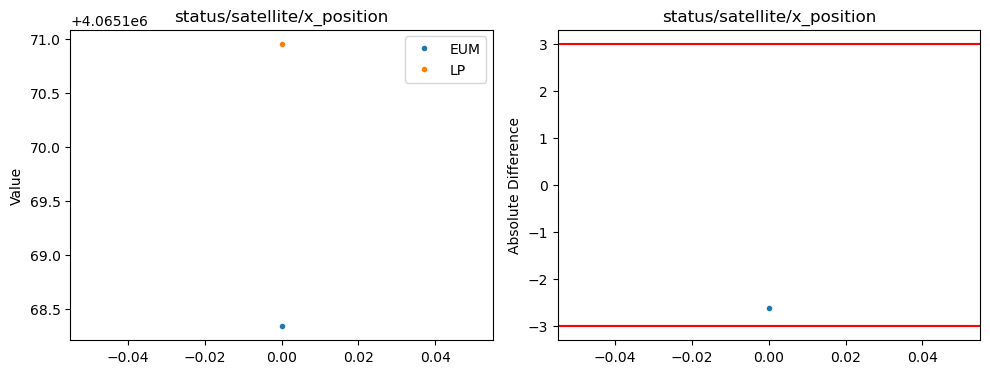

In [11]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/x_position')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -3, color = 'r', linestyle = '-')
axs[1].axhline(y = 3, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/x_position')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## 2.8. eccentricity

In [12]:
variable = "eccentricity"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for eccentricity:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for eccentricity:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 1.5 * 1e-5
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [0.00107538]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity()
    long_name: Eccentricity of the orbit at epoch time[TOD]
    valid_min: 0.0
    valid_max: 0.01
    missing_value: -900.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 0.001075380611423285
-------------------------------------------------------------------------------------------------------------------------------
Statistics for eccentricity:
Mean: -5.305e-10 
Minimum: 5.305e-10 
Maximum: 5.305e-10 
RSM: 5.305e-10
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref NaN occurances: 0
---------

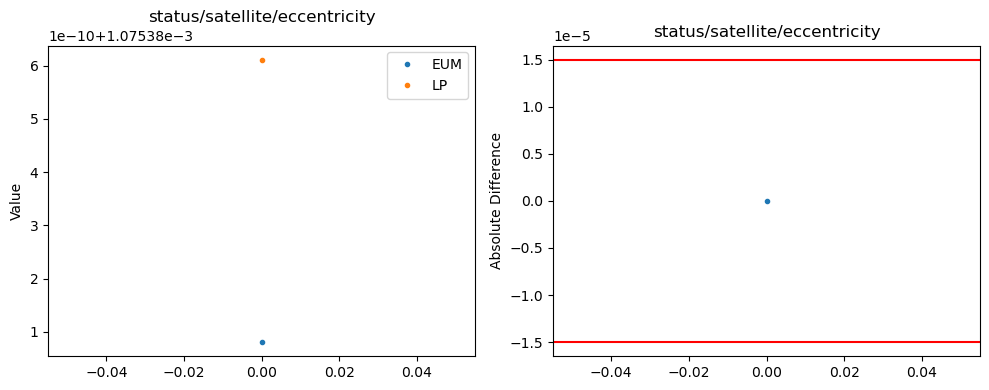

In [13]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/eccentricity')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -thresh, color = 'r', linestyle = '-')
axs[1].axhline(y = thresh, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/eccentricity')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# 3. TS-013

## 3.0. Paths to Files

In [16]:
eum_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/EUM EOCFI ref/MwsInr_Scenario013.nc"
lp_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/MWS LP/TS-013/W_XX-EUMETSAT-Darmstadt,SAT,SGA1-MWS-1B-RAD_C_EUMT_20230831130703_L_D_20070912084321_20070912102225_T_N____.nc"

## 3.1. mws_lat

In [17]:
variable = "mws_lat"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
lat_eum = var_1
lat_lp = var_2
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lat:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lat:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lat(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2707, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lat(n_scans, n_fovs)
    long_name: Latitude corresponding to each field of view
    units: degrees_north
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -900000
    valid_max: 900000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 257165 
Lenght Second: 250515


SystemExit: Exit the Status Function due to length missmatch.

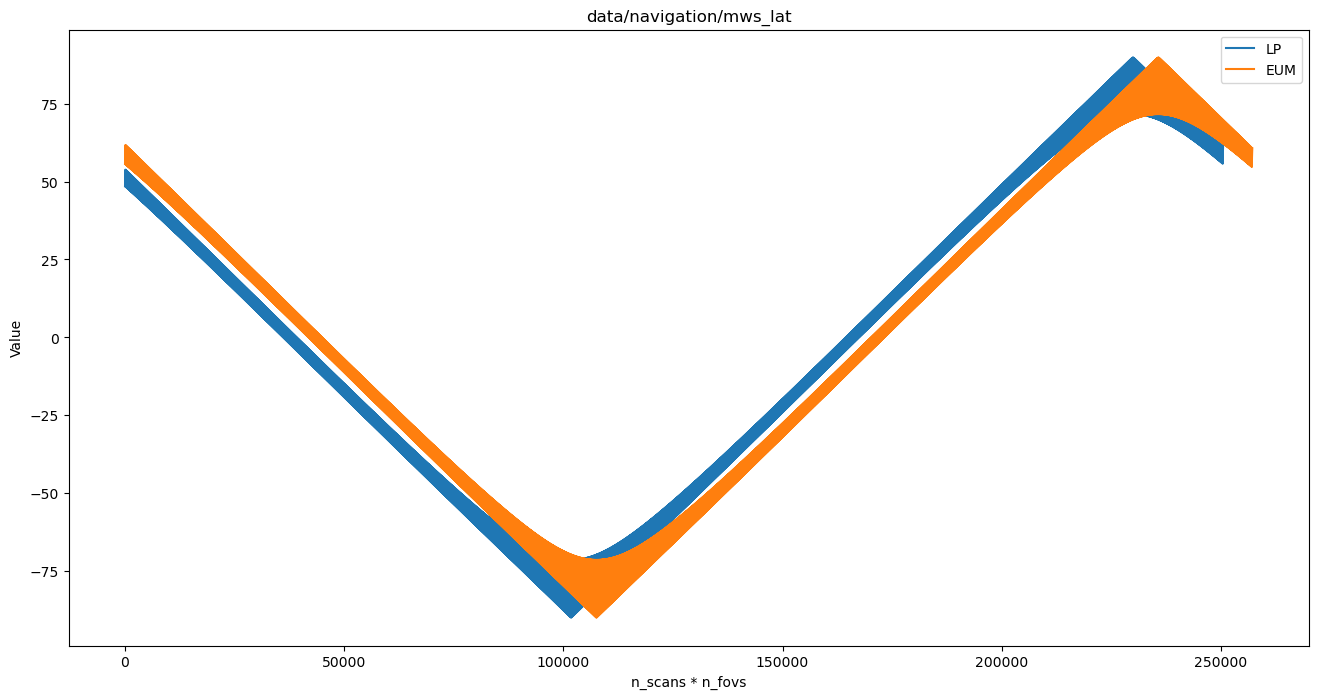

In [5]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lat')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans * n_fovs')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/mws_lat')
# plt.plot(dif)
# plt.show()

## 3.2. mws_lon

In [18]:
variable = "mws_lon"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lon:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lon:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lon(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2707, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lon(n_scans, n_fovs)
    long_name: Longitude corresponding to each field of view
    units: degrees_east
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -1800000
    valid_max: 1800000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 257165 
Lenght Second: 250515


SystemExit: Exit the Status Function due to length missmatch.

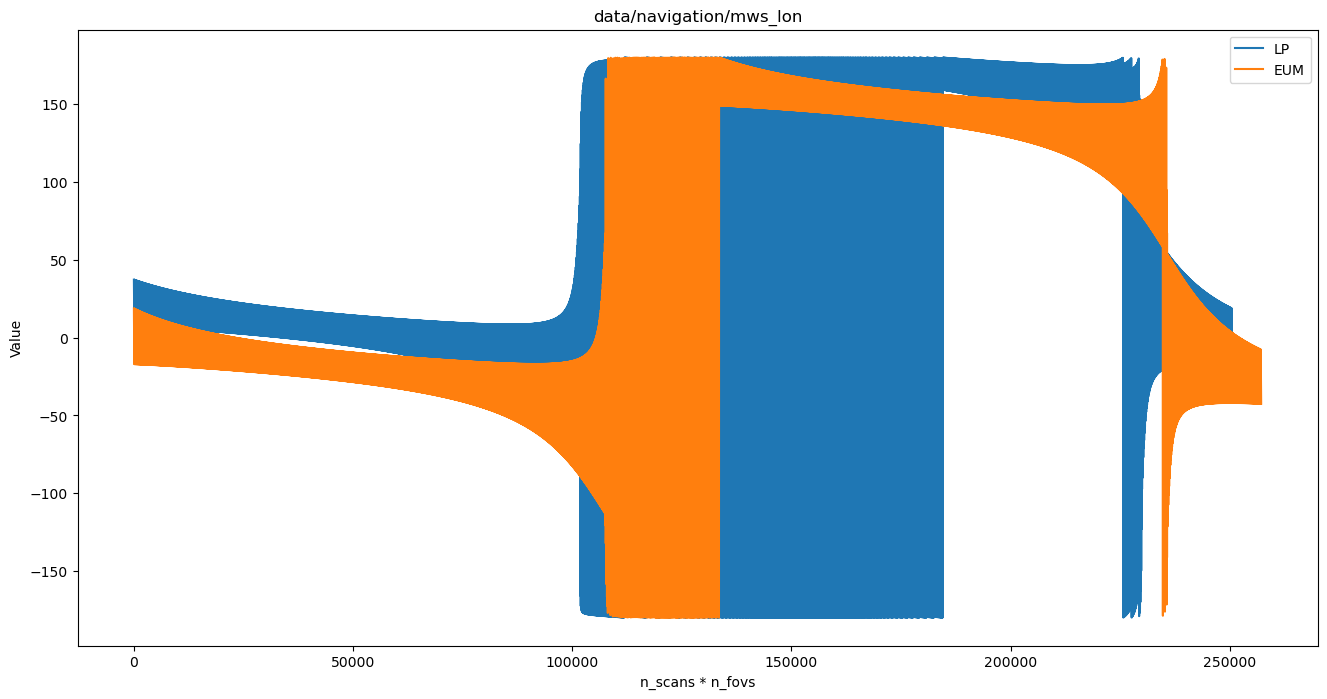

In [7]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lon')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans * n_fovs')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/mws_lon')
# plt.plot(dif)
# plt.show()

## 3.2.1 Distance mws_lat/mws_lon

In [22]:
lon_eum = var_1
lon_lp = var_2

df_eum = pd.DataFrame({'Lon': lon_eum, 'Lat': lat_eum})
df_lp = pd.DataFrame({'Lon': lon_lp, 'Lat': lat_lp})

allowed_error = np.zeros(95)
for i in range(0, 95):
    if (i <= 9) or ((i>=85) and (i<=94)):
        allowed_error[i] = 500
    elif ((i>=10) and (i<=46)) or ((i>=48) and (i<=84)):
        allowed_error[i] = 300
    elif i == 47:
        allowed_error[i] = 200
        
# The desired final length
desired_length = len(df_lp["Lat"])

# Calculate the number of repetitions needed to reach the desired length
num_repetitions = desired_length // len(allowed_error)

# Use tile to repeat the array
repeated_array = np.tile(allowed_error, num_repetitions)

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitude and longitude coordinates.
    
    Parameters:
        lat1, lon1: Latitude and longitude of the first location (in degrees).
        lat2, lon2: Latitude and longitude of the second location (in degrees).
        
    Returns:
        Distance in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in meters (mean radius)
    radius = 6371000  # meters
    
    # Return the distance in meters
    return radius * c

# Example usage
# Assuming df1 and df2 are your Pandas DataFrames with "Lat" and "Lon" columns.
# You can add a new column "Distance" to each DataFrame containing the distance to the reference point (0, 0).

reference_lat = 0  # Replace with your desired reference latitude
reference_lon = 0  # Replace with your desired reference longitude

distance = np.zeros(len(df_lp["Lat"]))
for i in range(len(df_lp["Lat"])):
    distance[i] = haversine_distance(df_eum["Lat"][i], df_eum["Lon"][i], df_lp["Lat"][i], df_lp["Lon"][i])

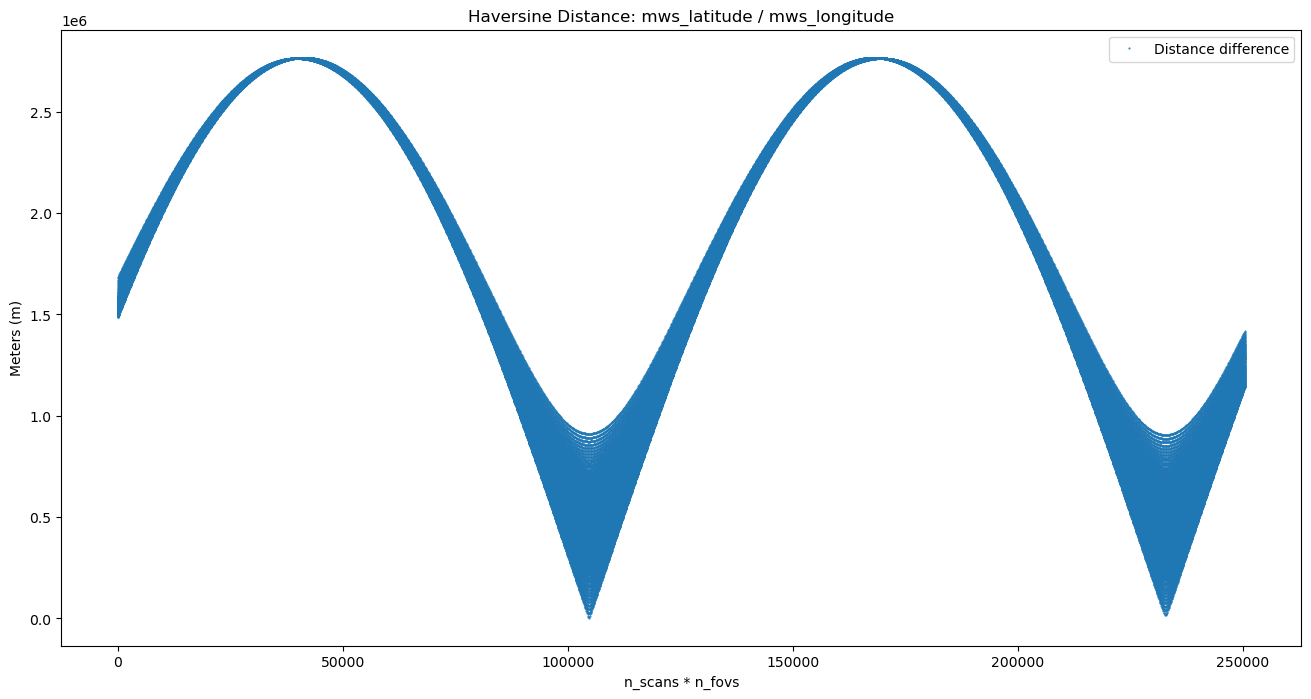

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(distance, ".", markersize="1", label = "Distance difference")
# plt.plot(repeated_array, ".", markersize="1", color = "r", label = "Allowed Abs Error")
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Meters (m)')
plt.title('Haversine Distance: mws_latitude / mws_longitude')
# plt.xticks(range(len(absolute_error_stacked['Rows'].unique())), absolute_error_stacked['Rows'].unique())
# plt.xticks(np.arange(0, 96, step=5))
# plt.tight_layout()
# plt.ylim([0,510])
# plt.xlim([120000,180000])
# plt.xlim([0,250515])
plt.legend(loc='upper right')
# plt.savefig("/home/gsanchez/EPS-SG/pngs/mws_location_TS012_zoom.png")
plt.show()

## 3.3. mws_satellite_azimuth_angle

In [8]:
variable = "satellite_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
variable = "mws_satellite_azimuth_angle"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_satellite_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_satellite_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.02
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 satellite_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2707, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_satellite_azimuth_angle(n_scans, n_fovs)
    long_name: Satellite Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 257165 
Lenght Second: 250515


SystemExit: Exit the Status Function due to length missmatch.

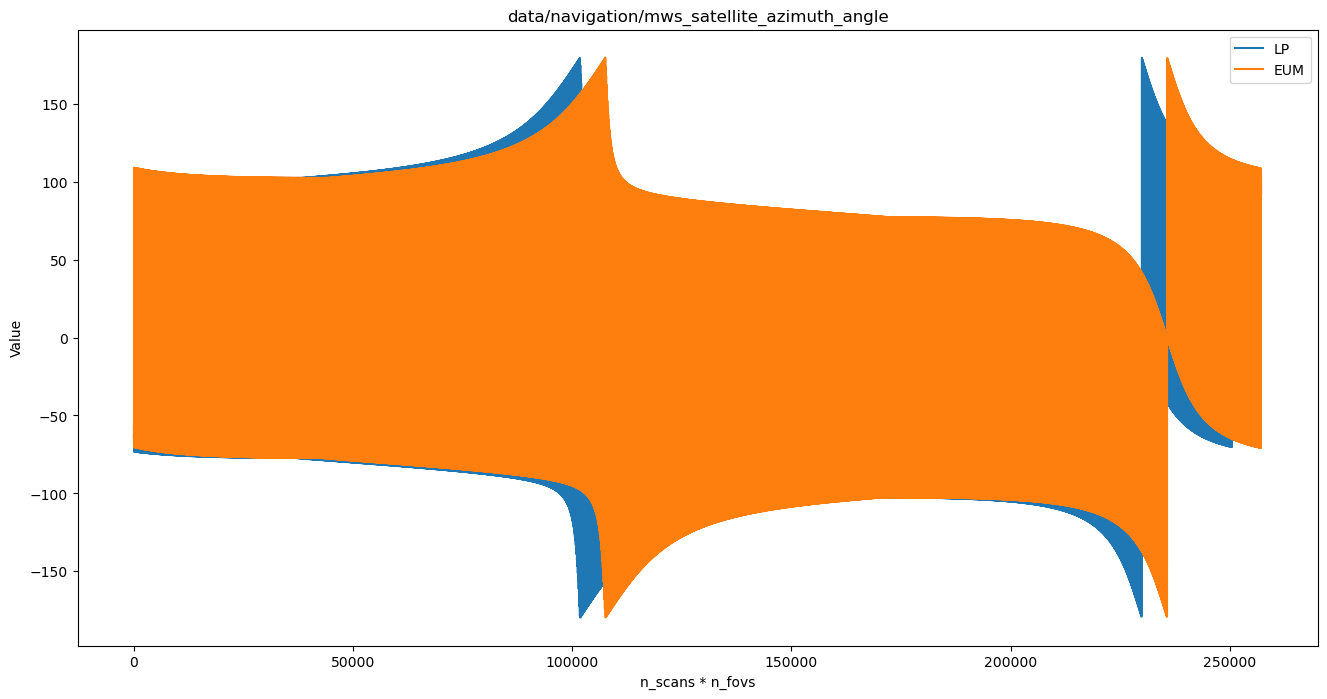

In [9]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans * n_fovs')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/mws_satellite_azimuth_angle')
# plt.plot(dif)
# plt.axhline(y = 0.02, color = 'r', linestyle = '-')
# plt.axhline(y = -0.02, color = 'r', linestyle = '-')
# plt.show()

## 3.4. mws_solar_azimuth_angle

In [10]:
variable = "mws_solar_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_solar_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_solar_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.03
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 mws_solar_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2707, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_solar_azimuth_angle(n_scans, n_fovs)
    long_name: Solar Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 257165 
Lenght Second: 250515


SystemExit: Exit the Status Function due to length missmatch.

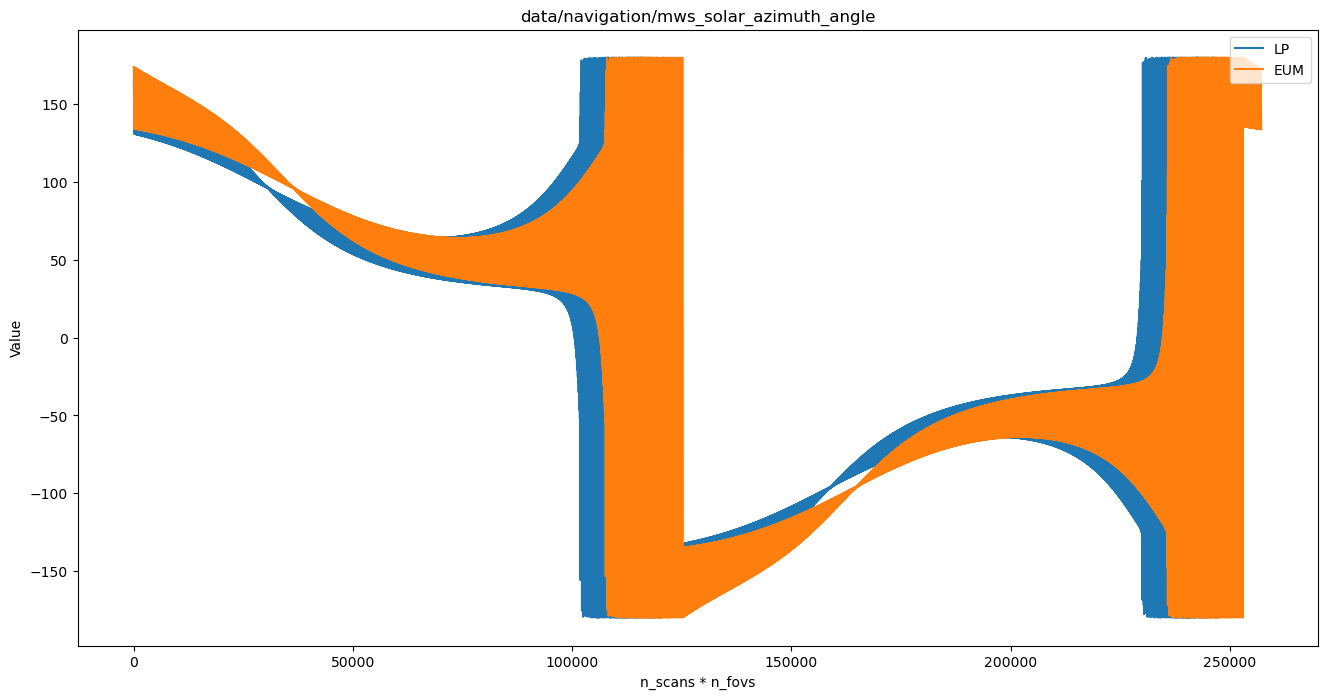

In [11]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans * n_fovs')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/mws_solar_azimuth_angle')
# plt.plot(dif)
# plt.axhline(y = 0.03, color = 'r', linestyle = '-')
# plt.axhline(y = -0.03, color = 'r', linestyle = '-')
# plt.show()

## 3.5. orbit_angle

In [12]:
variable = "orbit_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for orbit_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for orbit_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies\n ---------------------")
count = 0
thresh = 0.3
for i in range(len(var_1)):
    if np.isnan(mask[i]):
        pass
    else:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print("-"*127)
print("Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 orbit_angle(n_scans)
unlimited dimensions: 
current shape = (2707,)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 orbit_angle(n_scans)
    long_name: Angular position in the orbit, starting at zero when the satellite crosses the solar Ecliptic plane northbound
    units: degrees
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: 0
    valid_max: 3600000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637,)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 2707 
Lenght Second: 2637


SystemExit: Exit the Status Function due to length missmatch.

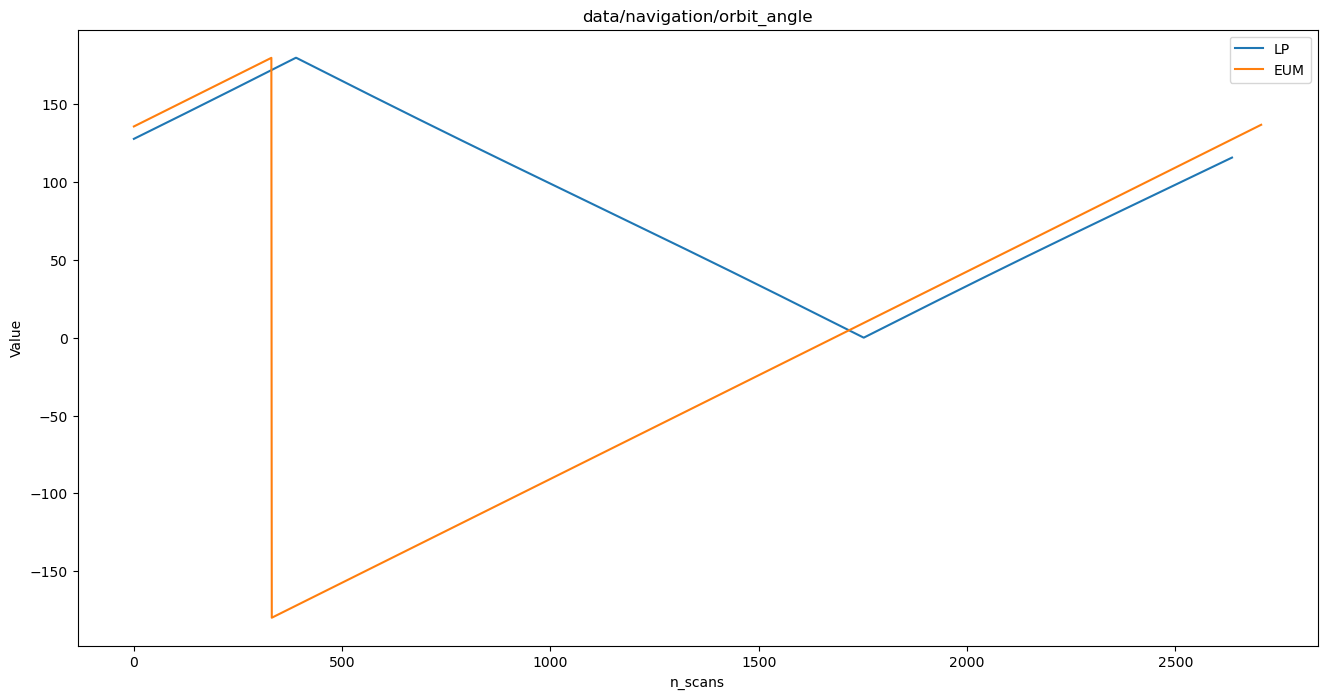

In [13]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# new_var_2 = np.where(mask_eum, np.nan, var_2)
# new_var_1 = np.where(mask_LP, np.nan, var_1)
# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans')
# plt.ylabel('Value')
# plt.title('data/navigation/orbit_angle')
# plt.plot(new_var_2, label="LP")
# plt.plot(new_var_1, label="EUM")
# plt.legend(loc="upper right")
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/orbit_angle')
# plt.plot(dif)
# plt.axhline(y = 0.3, color = 'r', linestyle = '-')
# plt.axhline(y = -0.3, color = 'r', linestyle = '-')
# plt.show()

# new_dif = np.where(mask, np.nan, dif)
# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/orbit_angle')
# plt.plot(new_dif)
# plt.axhline(y = 0.3, color = 'r', linestyle = '-')
# plt.axhline(y = -0.3, color = 'r', linestyle = '-')
# plt.show()

## 3.6. mws_moon_angles

In [14]:
variable = "mws_moon_angles"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_moon_angles:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_moon_angles:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.25
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print(" Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_moon_angles(n_scans, n_fovs_cal)
unlimited dimensions: 
current shape = (2707, 5)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2707
-------------------
<class 'netCDF4._netCDF4.Variable'>
uint16 mws_moon_angles(n_scans, n_fovs_cal)
    long_name: Angle between Moon and individual space views
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: 0
    valid_max: 18000
    missing_value: 65535
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 5)
filling on, default _FillValue of 65535 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Error when computing stats. Length missmatch:
Lenght First: 13535 
Lenght Second: 13185


SystemExit: Exit the Status Function due to length missmatch.

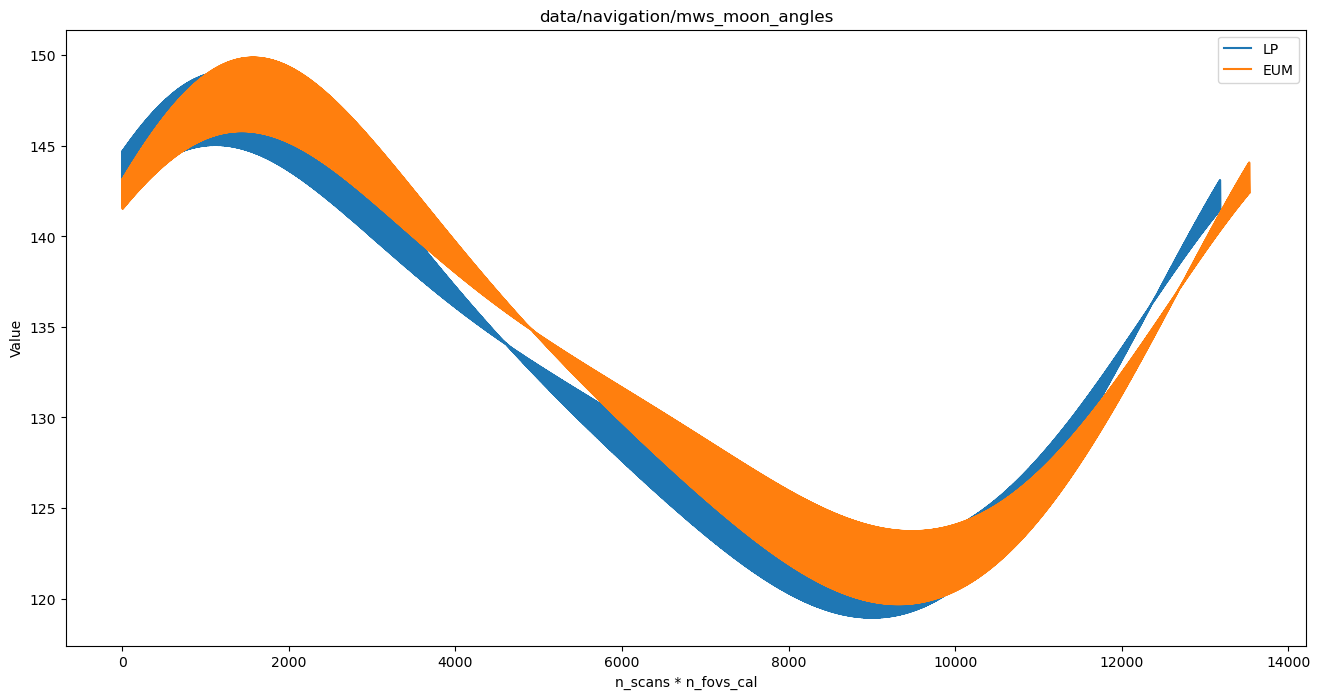

In [15]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Value')
plt.title('data/navigation/mws_moon_angles')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

# plt.figure(figsize=(16, 8))
# plt.xlabel('n_scans * n_fovs_cal')
# plt.ylabel('Absolute Difference')
# plt.title('data/navigation/mws_moon_angles')
# plt.plot(dif)
# plt.axhline(y = 0.25, color = 'r', linestyle = '-')
# plt.axhline(y = -0.25, color = 'r', linestyle = '-')
# plt.show()

## 3.7. x_position

In [19]:
variable = "x_position"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for x_position:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for x_position:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 3
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 x_position(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [3608246.69979028]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 x_position()
    long_name: X position of the orbital state vector [EARTH+FIXED]
    units: m
    valid_min: -7200000.0
    valid_max: 7200000.0
    missing_value: -9000000.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 4065170.9547516447
-------------------------------------------------------------------------------------------------------------------------------
Statistics for x_position:
Mean: -4.569e+05 
Minimum: 4.569e+05 
Maximum: 4.569e+05 
RSM: 4.569e+05
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances

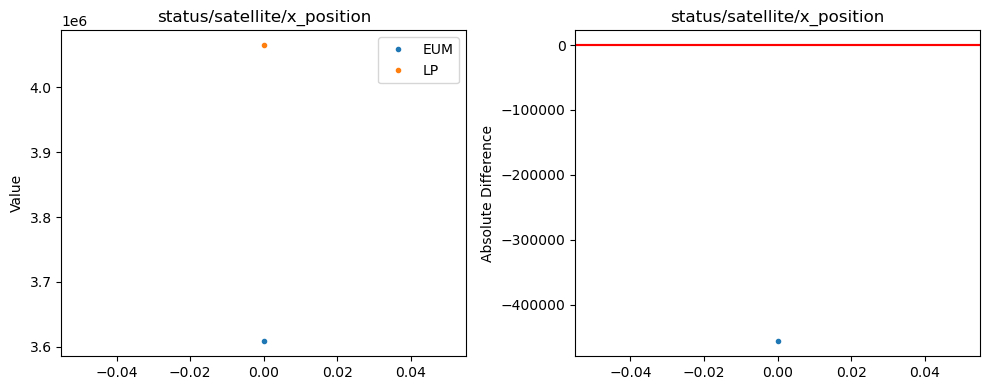

In [20]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/x_position')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -3, color = 'r', linestyle = '-')
axs[1].axhline(y = 3, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/x_position')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## 3.8. eccentricity

In [21]:
variable = "eccentricity"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for eccentricity:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for eccentricity:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 1.5 * 1e-5
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [0.0009022]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity()
    long_name: Eccentricity of the orbit at epoch time[TOD]
    valid_min: 0.0
    valid_max: 0.01
    missing_value: -900.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 0.001075380611423285
-------------------------------------------------------------------------------------------------------------------------------
Statistics for eccentricity:
Mean: -1.732e-04 
Minimum: 1.732e-04 
Maximum: 1.732e-04 
RSM: 1.732e-04
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref NaN occurances: 0
----------

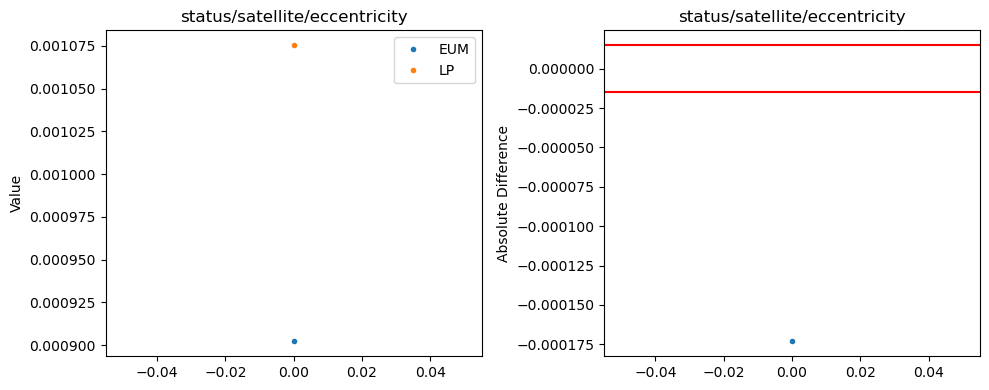

In [22]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/eccentricity')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -thresh, color = 'r', linestyle = '-')
axs[1].axhline(y = thresh, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/eccentricity')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# 4. TS-014

## 4.0. Paths to Files

In [3]:
eum_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/EUM EOCFI ref/MwsInr_Scenario014.nc"
lp_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/MWS LP/TS-014/W_XX-EUMETSAT-Darmstadt,SAT,SGA1-MWS-1B-RAD_C_EUMT_20230831133131_L_D_20080223084626_20080223102501_T_N____.nc"

## 4.1. mws_lat

In [24]:
variable = "mws_lat"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lat:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lat:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

lat_eum = var_1
lat_lp = var_2

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lat(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2624, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lat(n_scans, n_fovs)
    long_name: Latitude corresponding to each field of view
    units: degrees_north
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -900000
    valid_max: 900000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lat:
Mean: -6.278e-08 
Minimum: 8.213e-05 
Maximum: 8.274e-05 
RSM: 3.303e-05
--------------------------------------------------------------------------------------------------------------------------

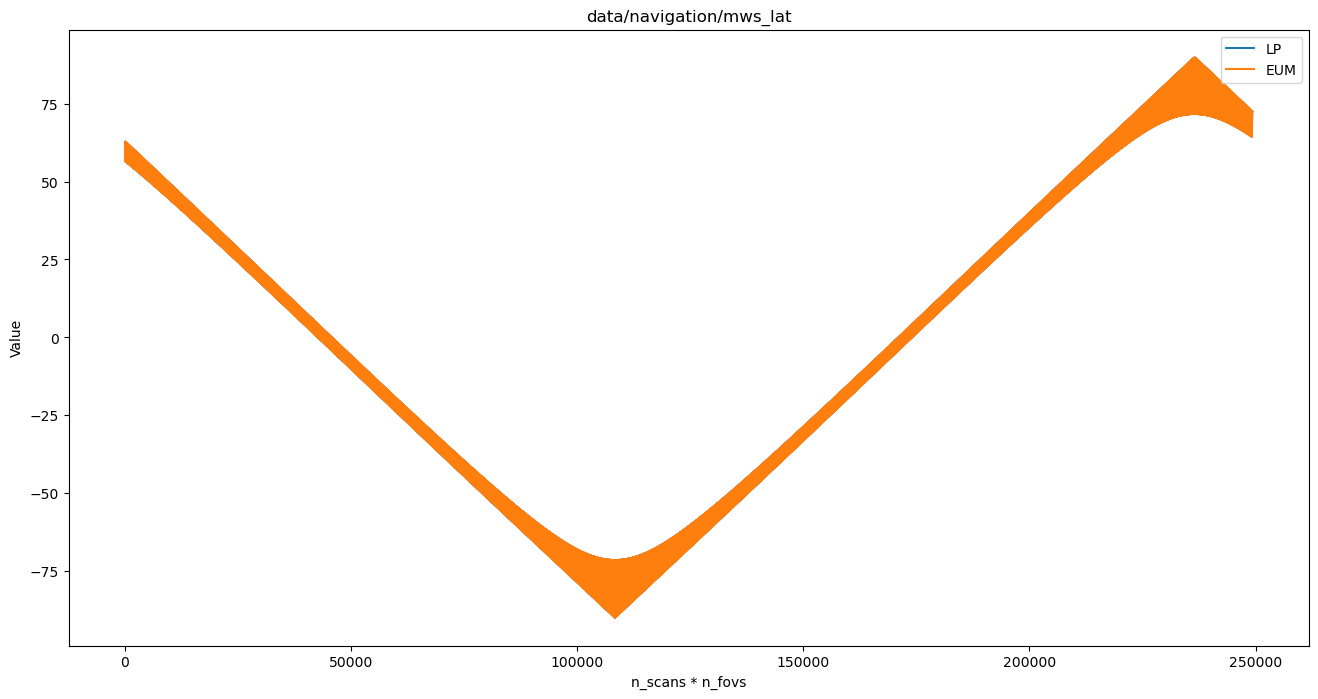

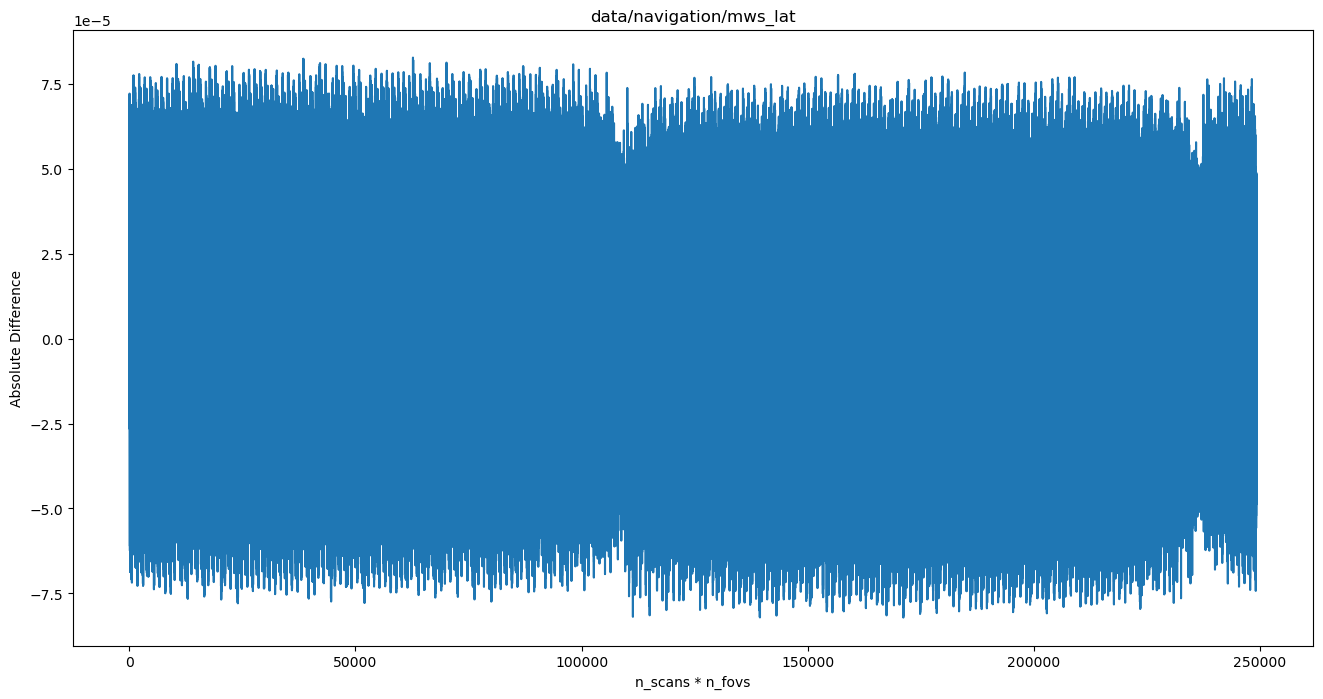

In [25]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lat')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lat')
plt.plot(dif)
plt.show()

## 4.2. mws_lon

In [26]:
variable = "mws_lon"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lon:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lon:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lon(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2624, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lon(n_scans, n_fovs)
    long_name: Longitude corresponding to each field of view
    units: degrees_east
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -1800000
    valid_max: 1800000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lon:
Mean: 2.062e-06 
Minimum: 5.137e-03 
Maximum: 4.103e-03 
RSM: 5.678e-05
-------------------------------------------------------------------------------------------------------------------------

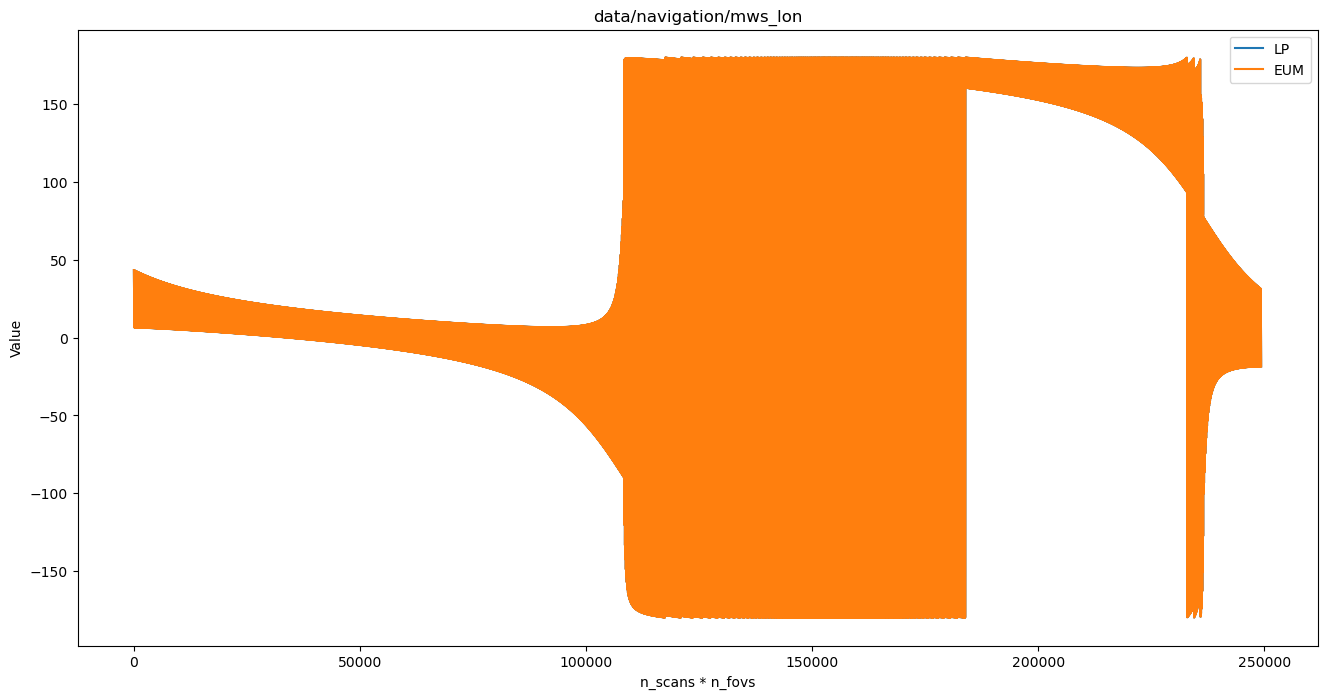

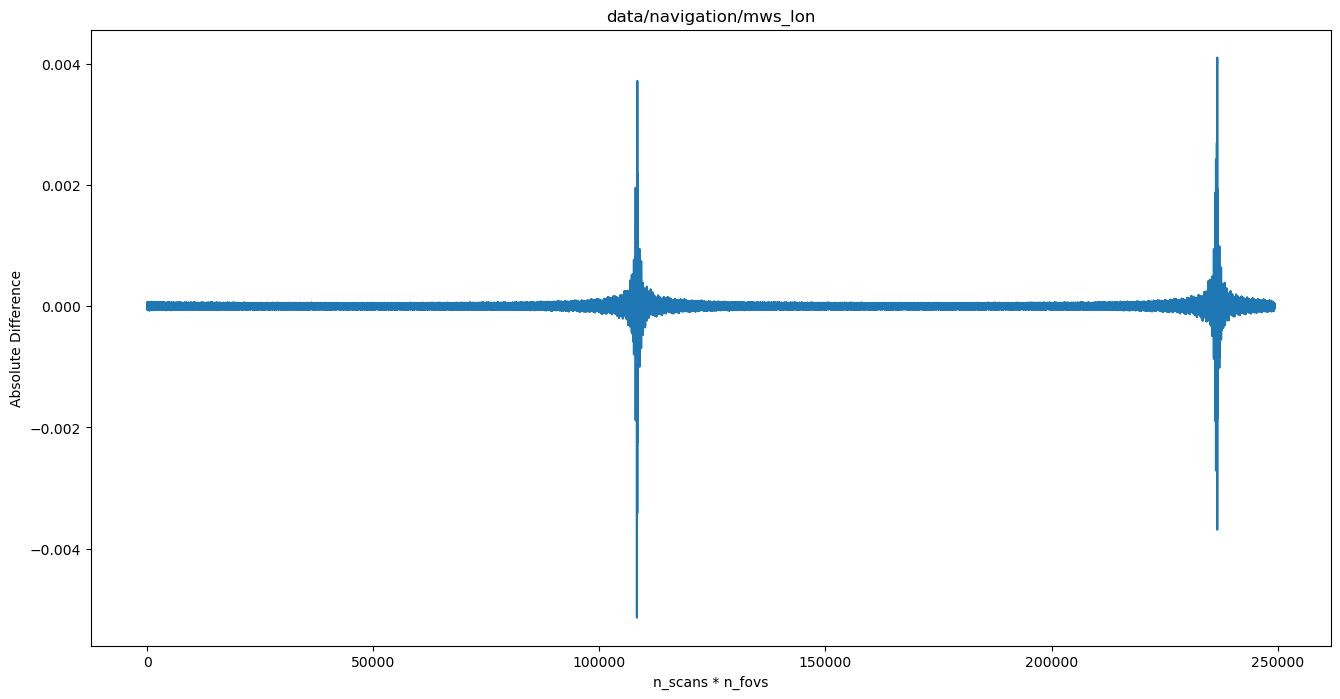

In [27]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lon')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lon')
plt.plot(dif)
plt.show()

## 4.2.1 Distance mws_lat/mws_lon

In [28]:
lon_eum = var_1
lon_lp = var_2

df_eum = pd.DataFrame({'Lon': lon_eum, 'Lat': lat_eum})
df_lp = pd.DataFrame({'Lon': lon_lp, 'Lat': lat_lp})

allowed_error = np.zeros(95)
for i in range(0, 95):
    if (i <= 9) or ((i>=85) and (i<=94)):
        allowed_error[i] = 500
    elif ((i>=10) and (i<=46)) or ((i>=48) and (i<=84)):
        allowed_error[i] = 300
    elif i == 47:
        allowed_error[i] = 200
        
# The desired final length
desired_length = len(df_eum["Lat"])

# Calculate the number of repetitions needed to reach the desired length
num_repetitions = desired_length // len(allowed_error)

# Use tile to repeat the array
repeated_array = np.tile(allowed_error, num_repetitions)

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitude and longitude coordinates.
    
    Parameters:
        lat1, lon1: Latitude and longitude of the first location (in degrees).
        lat2, lon2: Latitude and longitude of the second location (in degrees).
        
    Returns:
        Distance in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in meters (mean radius)
    radius = 6371000  # meters
    
    # Return the distance in meters
    return radius * c

# Example usage
# Assuming df1 and df2 are your Pandas DataFrames with "Lat" and "Lon" columns.
# You can add a new column "Distance" to each DataFrame containing the distance to the reference point (0, 0).

reference_lat = 0  # Replace with your desired reference latitude
reference_lon = 0  # Replace with your desired reference longitude

distance = np.zeros(len(df_eum["Lat"]))
for i in range(len(df_eum["Lat"])):
    distance[i] = haversine_distance(df_eum["Lat"][i], df_eum["Lon"][i], df_lp["Lat"][i], df_lp["Lon"][i])

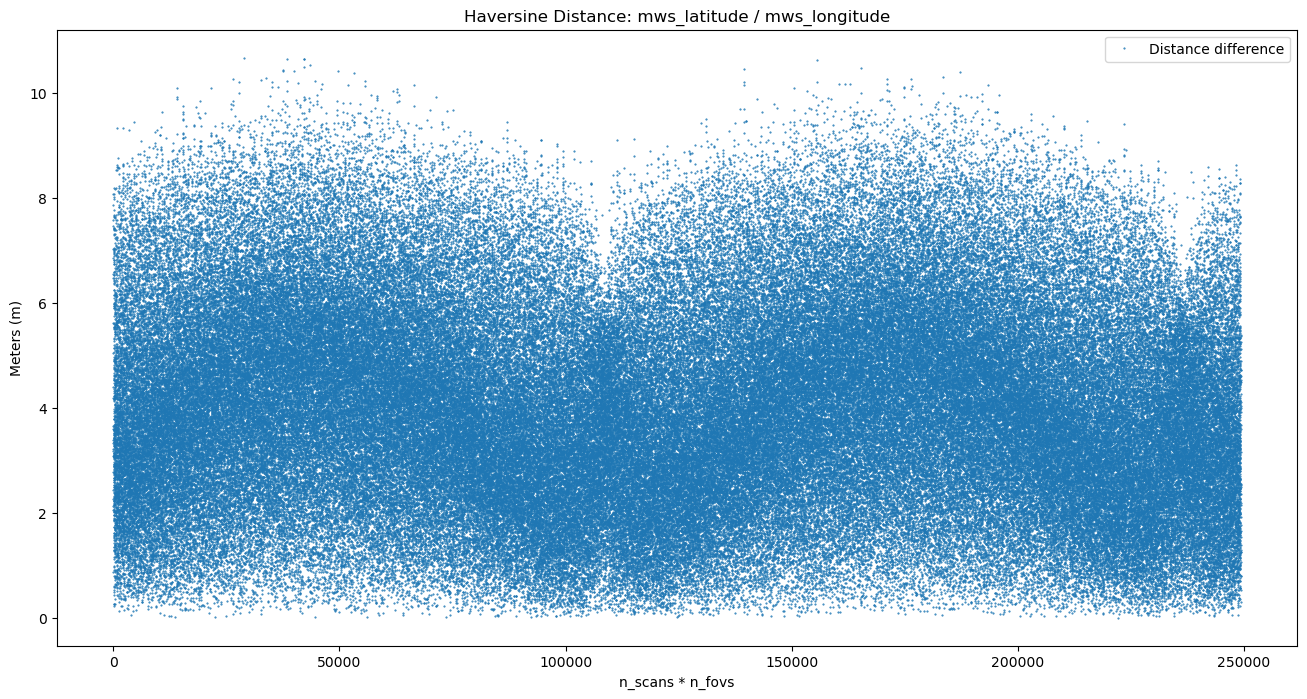

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(distance, ".", markersize="1", label = "Distance difference")
# plt.plot(repeated_array, ".", markersize="1", color = "r", label = "Allowed Abs Error")
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Meters (m)')
plt.title('Haversine Distance: mws_latitude / mws_longitude')
# plt.xticks(range(len(absolute_error_stacked['Rows'].unique())), absolute_error_stacked['Rows'].unique())
# plt.xticks(np.arange(0, 96, step=5))
# plt.tight_layout()
# plt.ylim([0,510])
# plt.xlim([120000,180000])
# plt.xlim([0,250515])
plt.legend(loc='upper right')
# plt.savefig("/home/gsanchez/EPS-SG/pngs/mws_location_TS012_zoom.png")
plt.show()

## 4.3. mws_satellite_azimuth_angle

In [30]:
variable = "satellite_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
variable = "mws_satellite_azimuth_angle"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_satellite_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_satellite_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.02
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 satellite_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2624, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_satellite_azimuth_angle(n_scans, n_fovs)
    long_name: Satellite Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_satellite_azimuth_angle:
Mean: -9.187e-06 
Minimum: 6.218e-03 
Maximum: 8.169e-03 
RSM: 2.867e-03
-----------------------------------------------------------------------

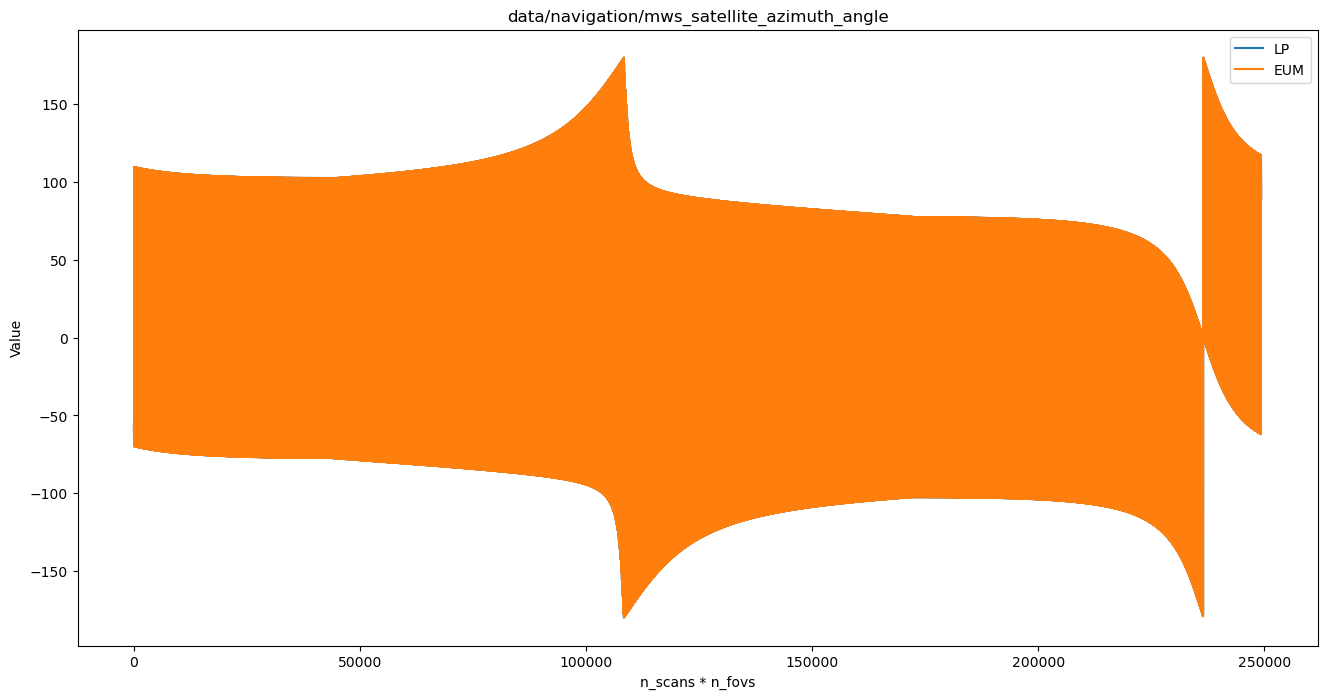

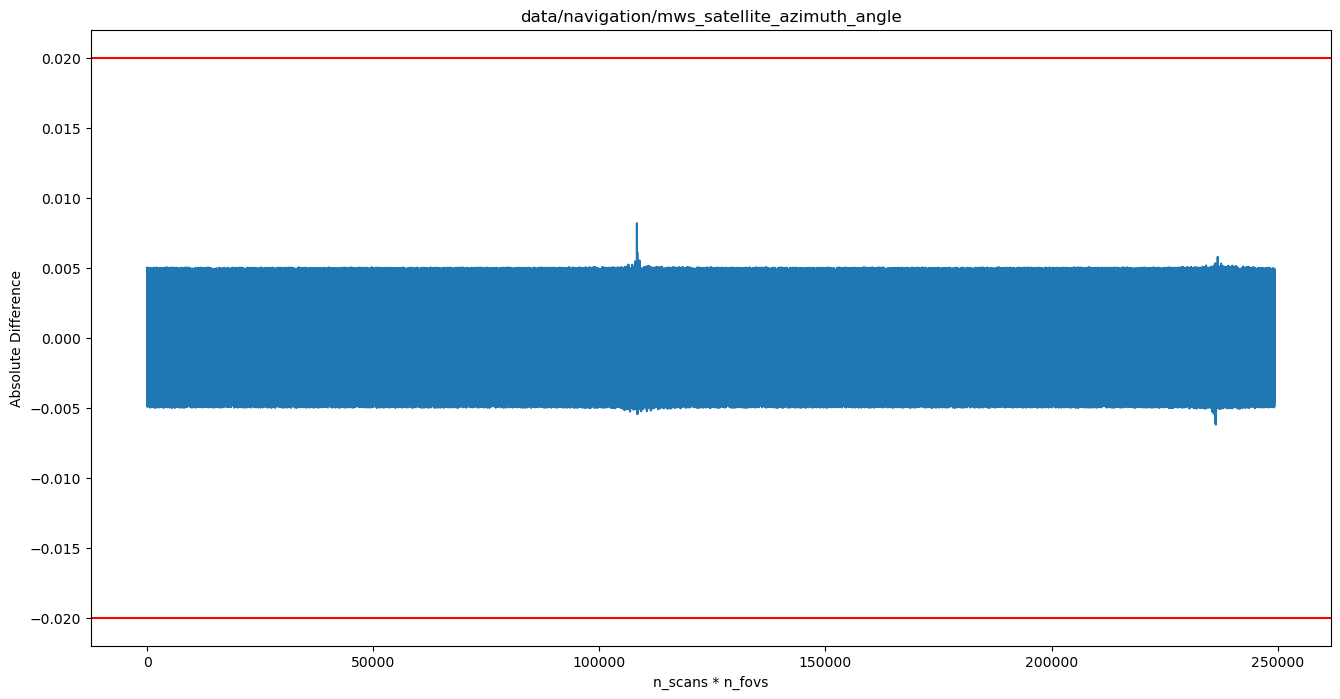

In [31]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.02, color = 'r', linestyle = '-')
plt.axhline(y = -0.02, color = 'r', linestyle = '-')
plt.show()

## 4.4. mws_solar_azimuth_angle

In [32]:
variable = "mws_solar_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_solar_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_solar_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.03
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 mws_solar_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2624, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_solar_azimuth_angle(n_scans, n_fovs)
    long_name: Solar Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_solar_azimuth_angle:
Mean: -1.910e-06 
Minimum: 6.470e-03 
Maximum: 7.396e-03 
RSM: 2.887e-03
-----------------------------------------------------------------------------------

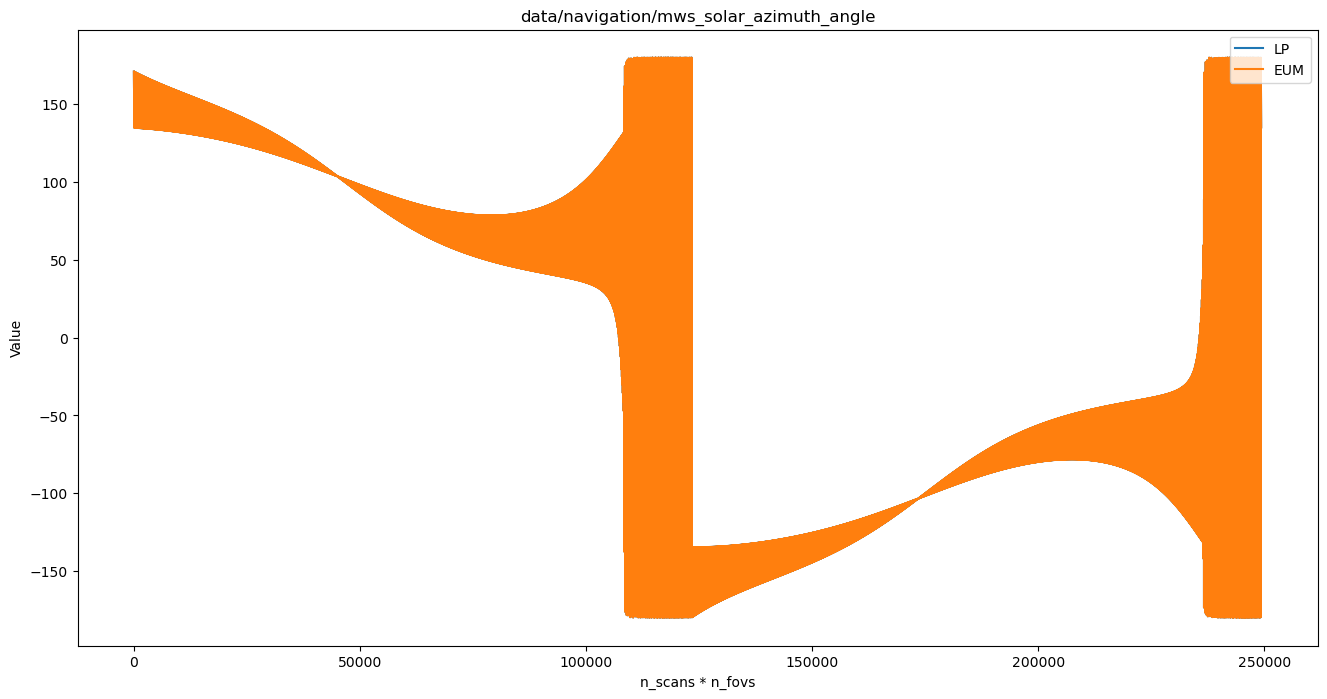

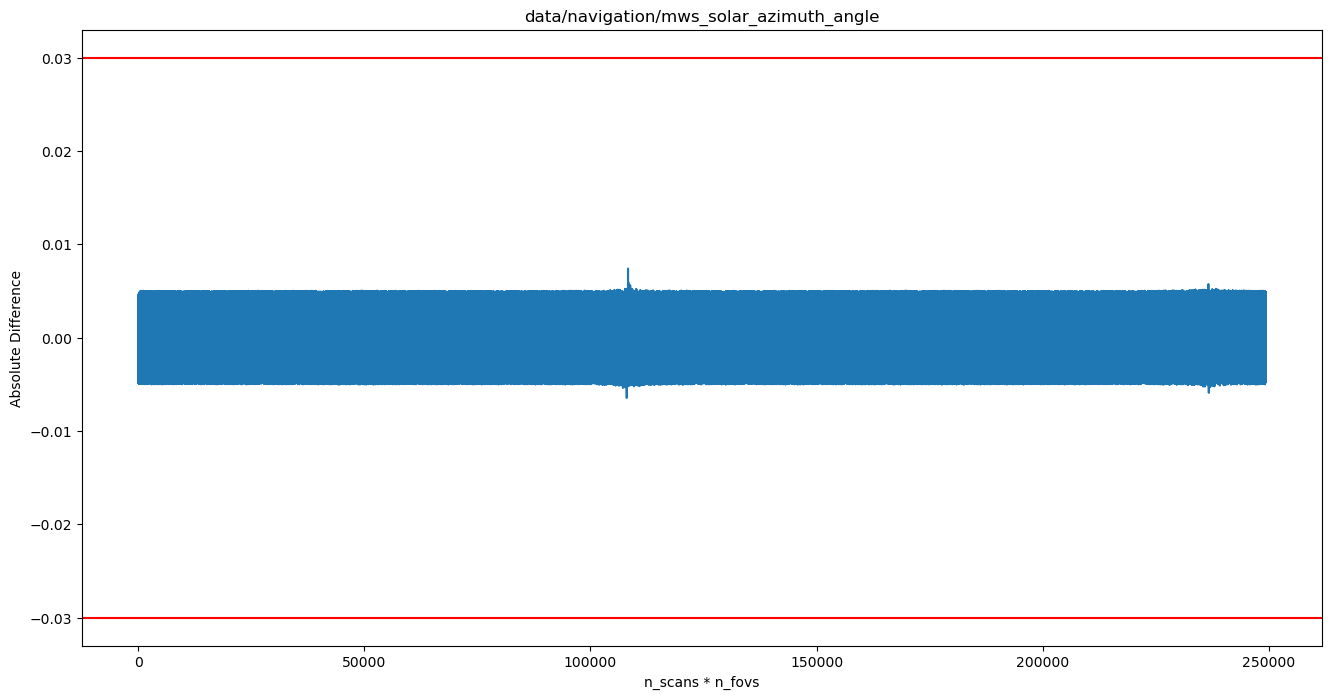

In [33]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.03, color = 'r', linestyle = '-')
plt.axhline(y = -0.03, color = 'r', linestyle = '-')
plt.show()

## 4.5. orbit_angle

In [4]:
variable = "orbit_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for orbit_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for orbit_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies\n ---------------------")
count = 0
thresh = 0.3
for i in range(len(var_1)):
    if np.isnan(mask[i]):
        pass
    else:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print("-"*127)
print("Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 orbit_angle(n_scans)
unlimited dimensions: 
current shape = (2624,)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 orbit_angle(n_scans)
    long_name: Angular position in the orbit, starting at zero when the satellite crosses the solar Ecliptic plane northbound
    units: degrees
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: 0
    valid_max: 3600000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624,)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for orbit_angle:
Mean: -8.734e+01 
Minimum: 2.075e+02 
Maximum: 1.560e+02 
RSM: 1.578e+02
-----------------------------------------------------------------------------

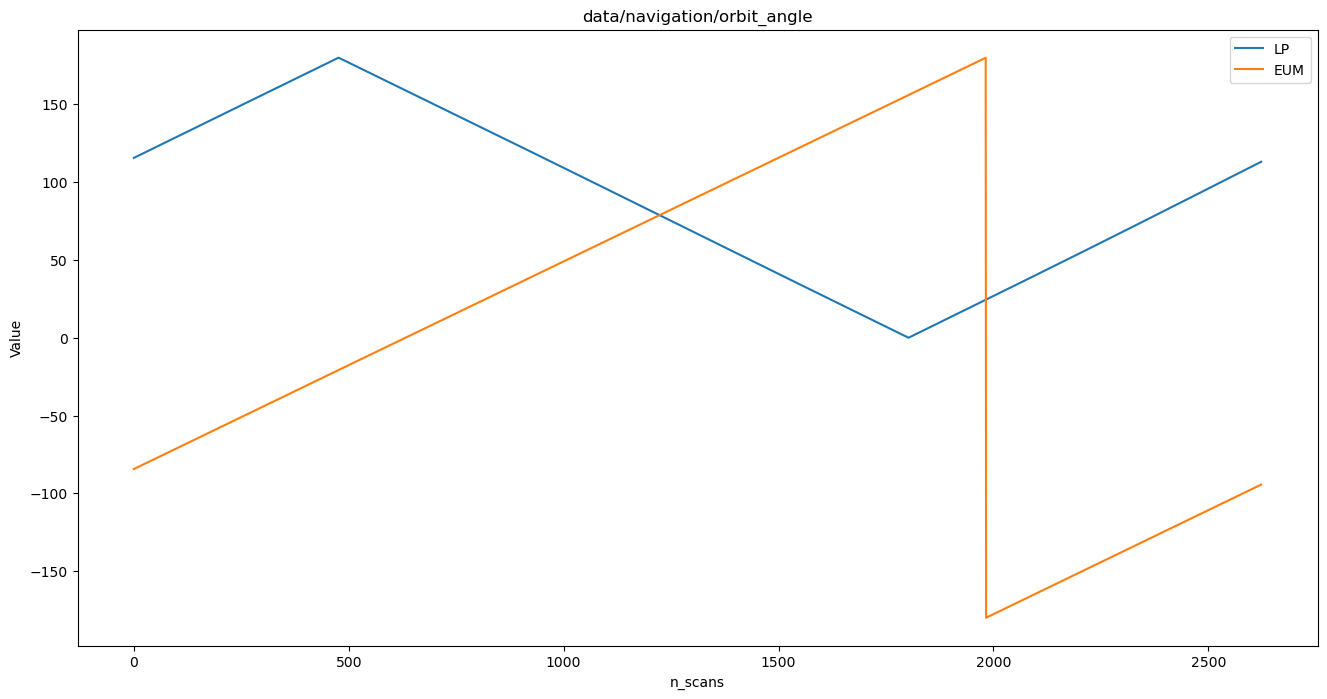

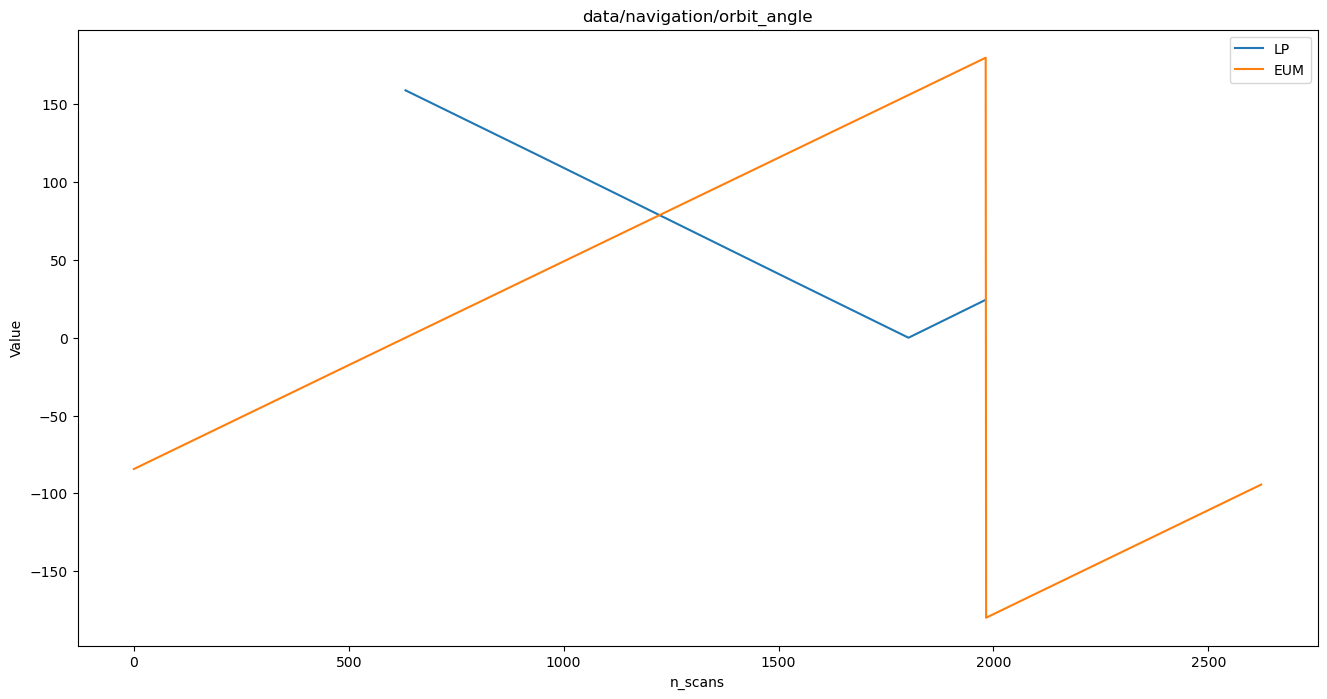

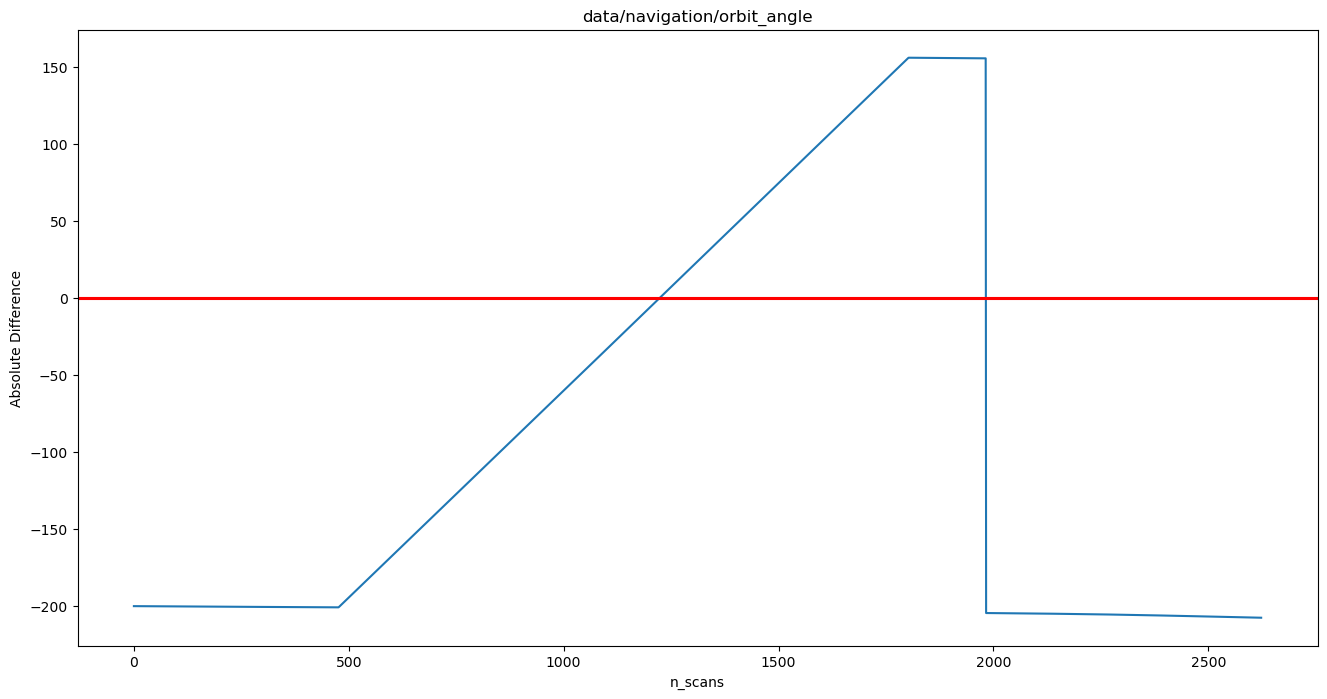

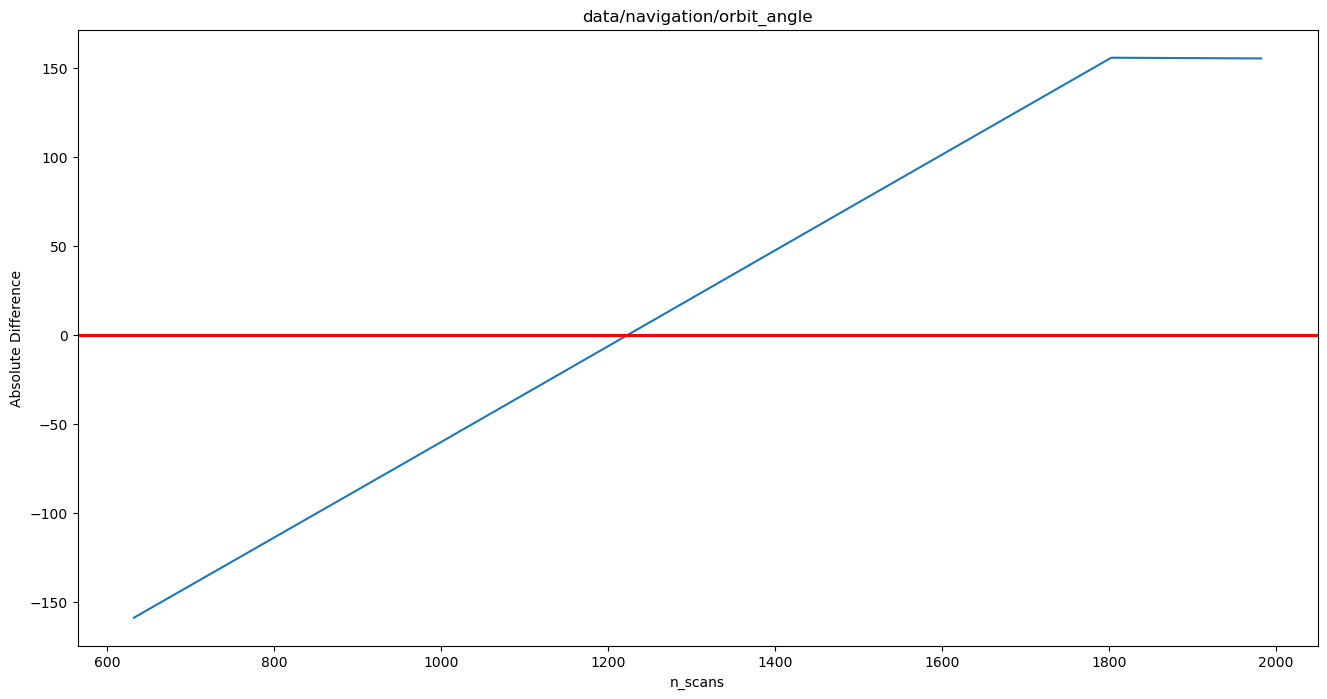

In [5]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

new_var_2 = np.where(mask_eum, np.nan, var_2)
new_var_1 = np.where(mask_LP, np.nan, var_1)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(new_var_2, label="LP")
plt.plot(new_var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

new_dif = np.where(mask, np.nan, dif)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(new_dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

## 4.6. mws_moon_angles

In [6]:
variable = "mws_moon_angles"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_moon_angles:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_moon_angles:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.25
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print(" Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_moon_angles(n_scans, n_fovs_cal)
unlimited dimensions: 
current shape = (2624, 5)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2624
-------------------
<class 'netCDF4._netCDF4.Variable'>
uint16 mws_moon_angles(n_scans, n_fovs_cal)
    long_name: Angle between Moon and individual space views
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: 0
    valid_max: 18000
    missing_value: 65535
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2624, 5)
filling on, default _FillValue of 65535 used
Number of Samples: 2624
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_moon_angles:
Mean: 1.679e-05 
Minimum: 5.002e-03 
Maximum: 5.005e-03 
RSM: 2.864e-03
----------------------------------------------------------------------------------------------------------------------

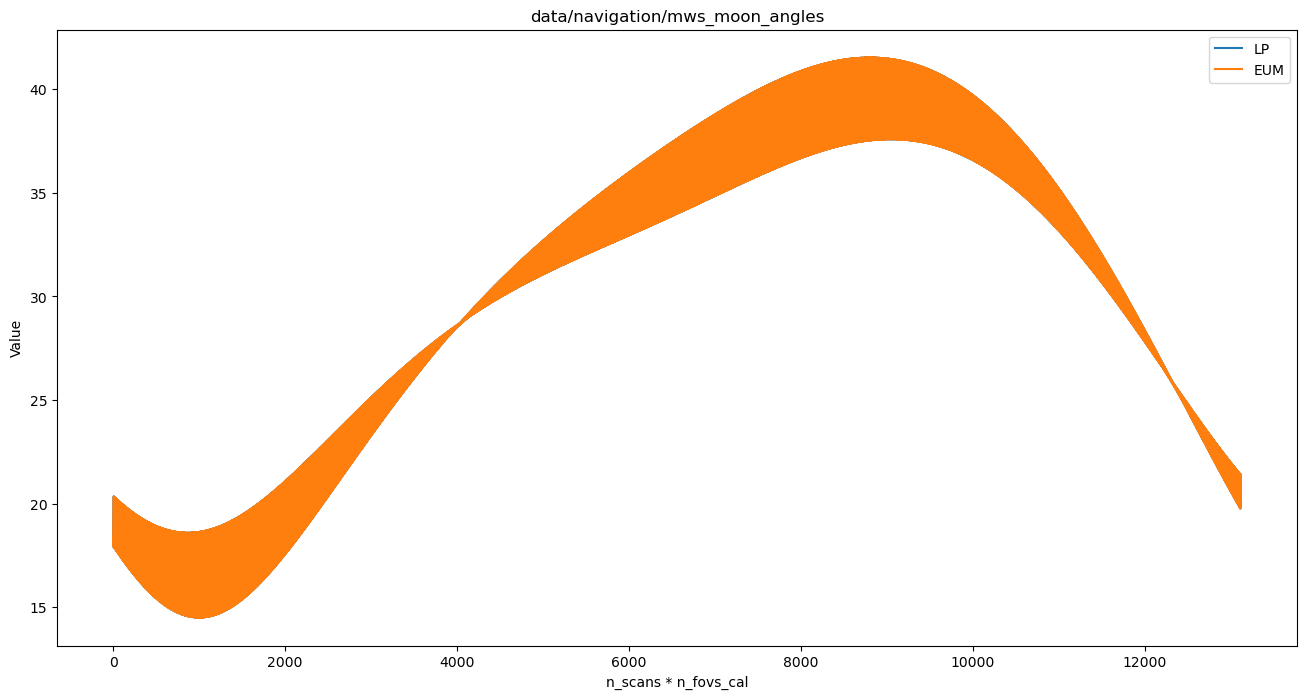

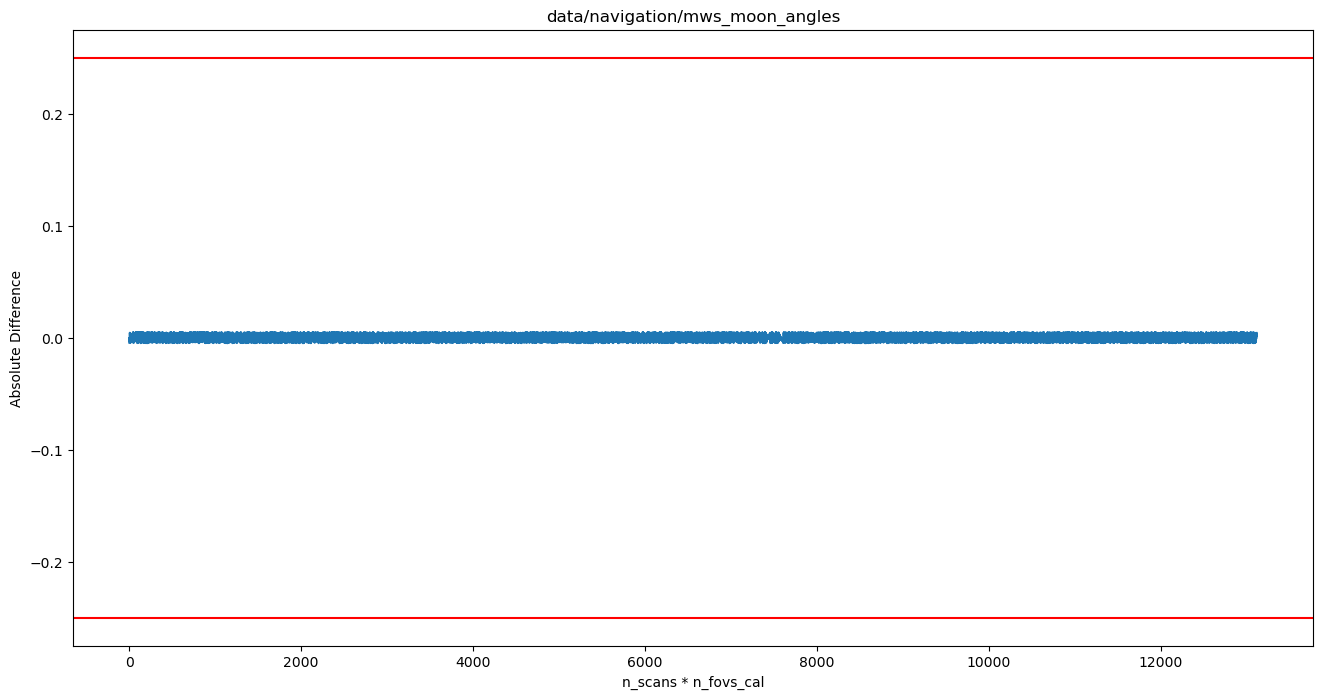

In [7]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Value')
plt.title('data/navigation/mws_moon_angles')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_moon_angles')
plt.plot(dif)
plt.axhline(y = 0.25, color = 'r', linestyle = '-')
plt.axhline(y = -0.25, color = 'r', linestyle = '-')
plt.show()

## 4.7. x_position

In [8]:
variable = "x_position"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for x_position:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for x_position:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 3
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 x_position(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [3119623.443]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 x_position()
    long_name: X position of the orbital state vector [EARTH+FIXED]
    units: m
    valid_min: -7200000.0
    valid_max: 7200000.0
    missing_value: -9000000.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 3119626.3154749232
-------------------------------------------------------------------------------------------------------------------------------
Statistics for x_position:
Mean: -2.872e+00 
Minimum: 2.872e+00 
Maximum: 2.872e+00 
RSM: 2.872e+00
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
R

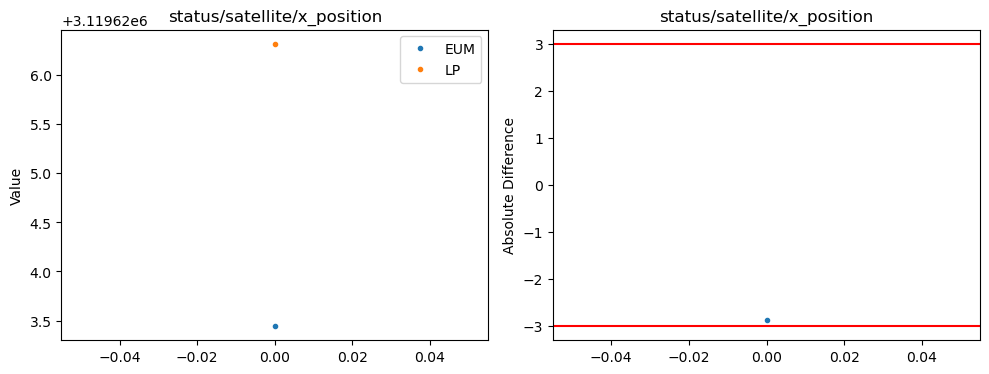

In [9]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/x_position')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -3, color = 'r', linestyle = '-')
axs[1].axhline(y = 3, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/x_position')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## 4.8. eccentricity

In [10]:
variable = "eccentricity"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for eccentricity:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for eccentricity:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 1.5 * 1e-5
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [0.00088591]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity()
    long_name: Eccentricity of the orbit at epoch time[TOD]
    valid_min: 0.0
    valid_max: 0.01
    missing_value: -900.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 0.0008859091868176313
-------------------------------------------------------------------------------------------------------------------------------
Statistics for eccentricity:
Mean: -5.656e-10 
Minimum: 5.656e-10 
Maximum: 5.656e-10 
RSM: 5.656e-10
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref NaN occurances: 0
--------

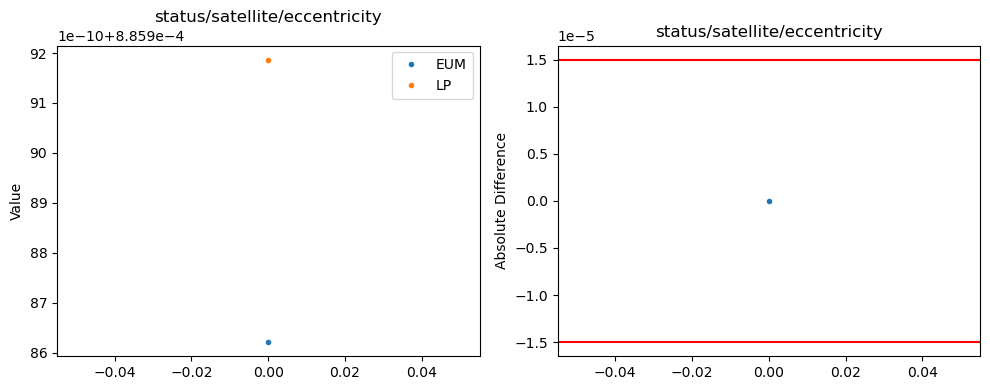

In [11]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/eccentricity')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -thresh, color = 'r', linestyle = '-')
axs[1].axhline(y = thresh, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/eccentricity')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# 5. TS-071

## 5.0. Paths to Files

In [3]:
eum_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/EUM EOCFI ref/MwsInr_Scenario071.nc"
lp_path = "/home/gsanchez/EPS-SG/Compare_INR_Variables/MWS LP/TS-071/W_XX-EUMETSAT-Darmstadt,SAT,SGA1-MWS-1B-RAD_C_EUMT_20230831152604_L_D_20070929073622_20070929091526_T_N____.nc"

## 5.1. mws_lat

In [13]:
variable = "mws_lat"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lat:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lat:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

lat_eum = var_1
lat_lp = var_2

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lat(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lat(n_scans, n_fovs)
    long_name: Latitude corresponding to each field of view
    units: degrees_north
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -900000
    valid_max: 900000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lat:
Mean: -1.568e-07 
Minimum: 8.324e-05 
Maximum: 8.245e-05 
RSM: 3.295e-05
--------------------------------------------------------------------------------------------------------------------------

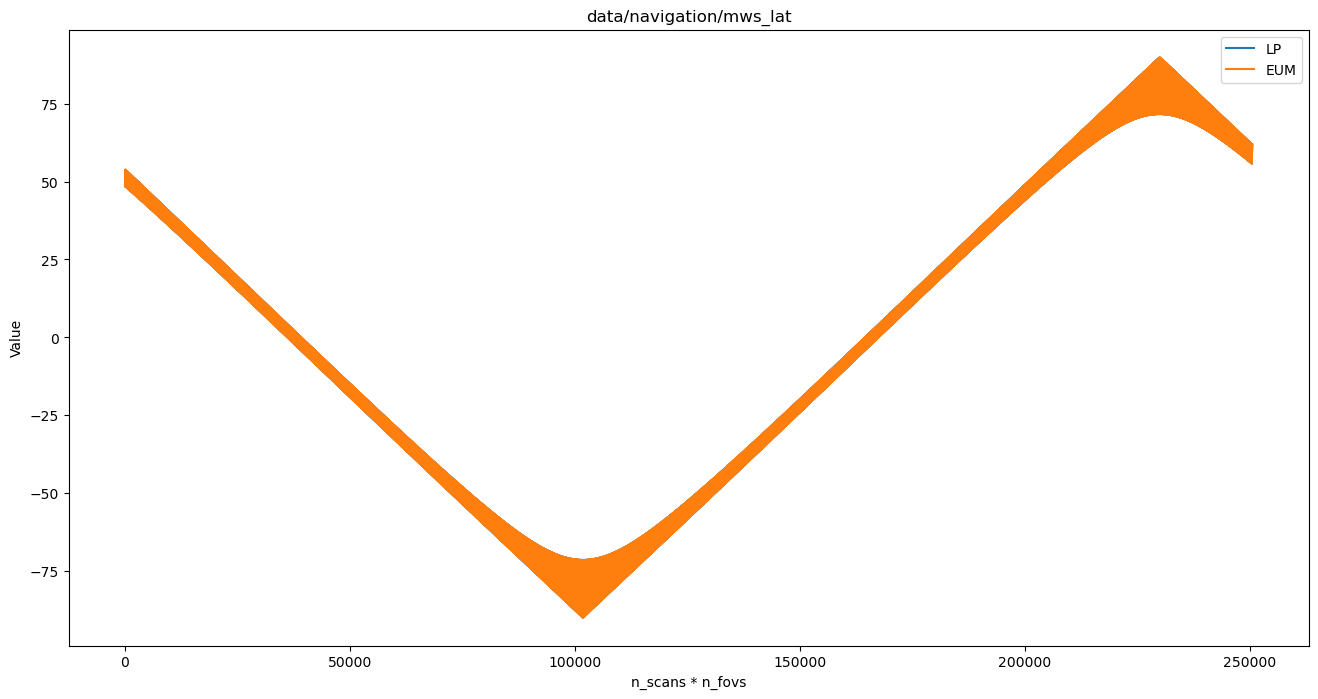

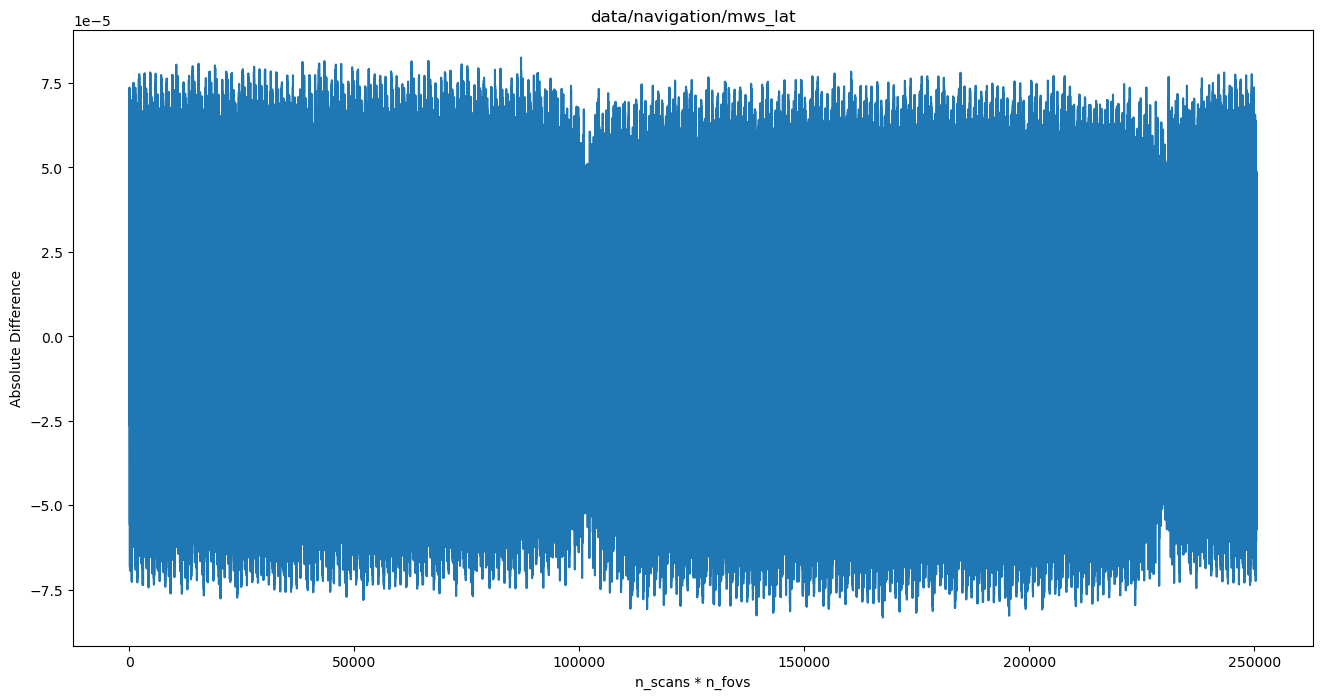

In [14]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lat')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lat')
plt.plot(dif)
plt.show()

## 5.2. mws_lon

In [15]:
variable = "mws_lon"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_lon:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_lon:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_lon(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 mws_lon(n_scans, n_fovs)
    long_name: Longitude corresponding to each field of view
    units: degrees_east
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: -1800000
    valid_max: 1800000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_lon:
Mean: 2.478e-06 
Minimum: 4.392e-03 
Maximum: 1.940e-02 
RSM: 6.950e-05
-------------------------------------------------------------------------------------------------------------------------

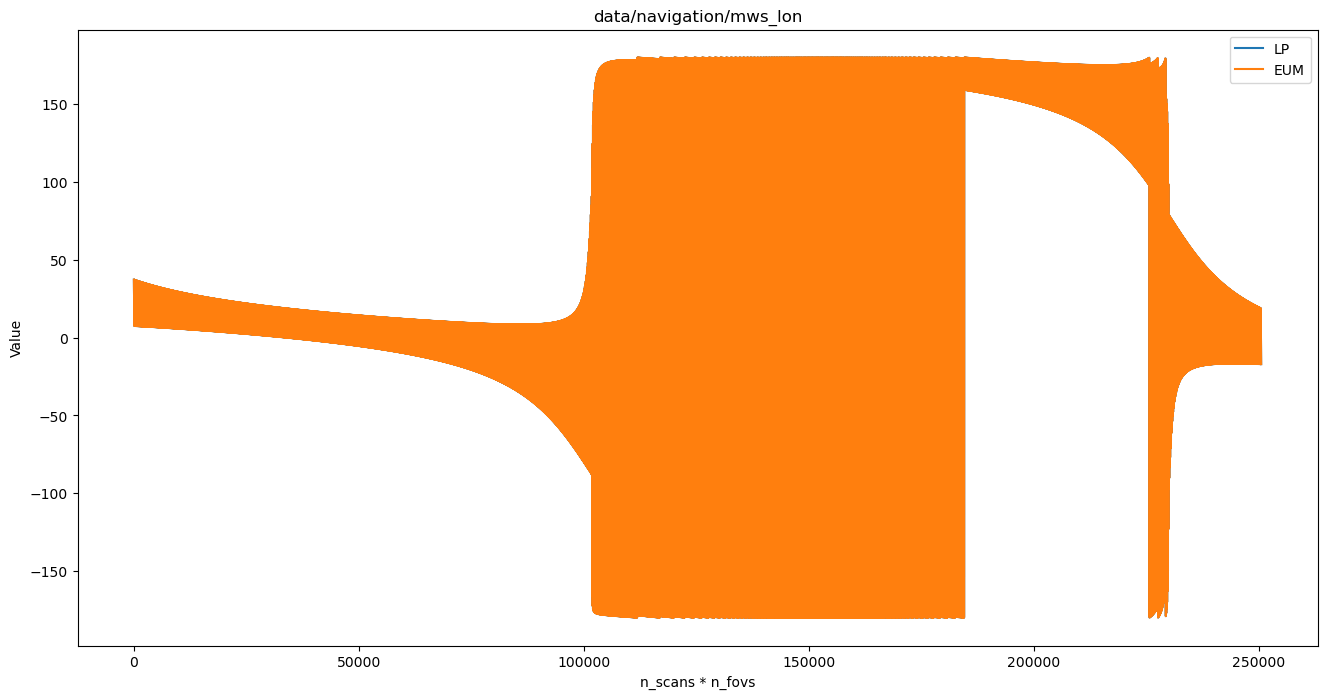

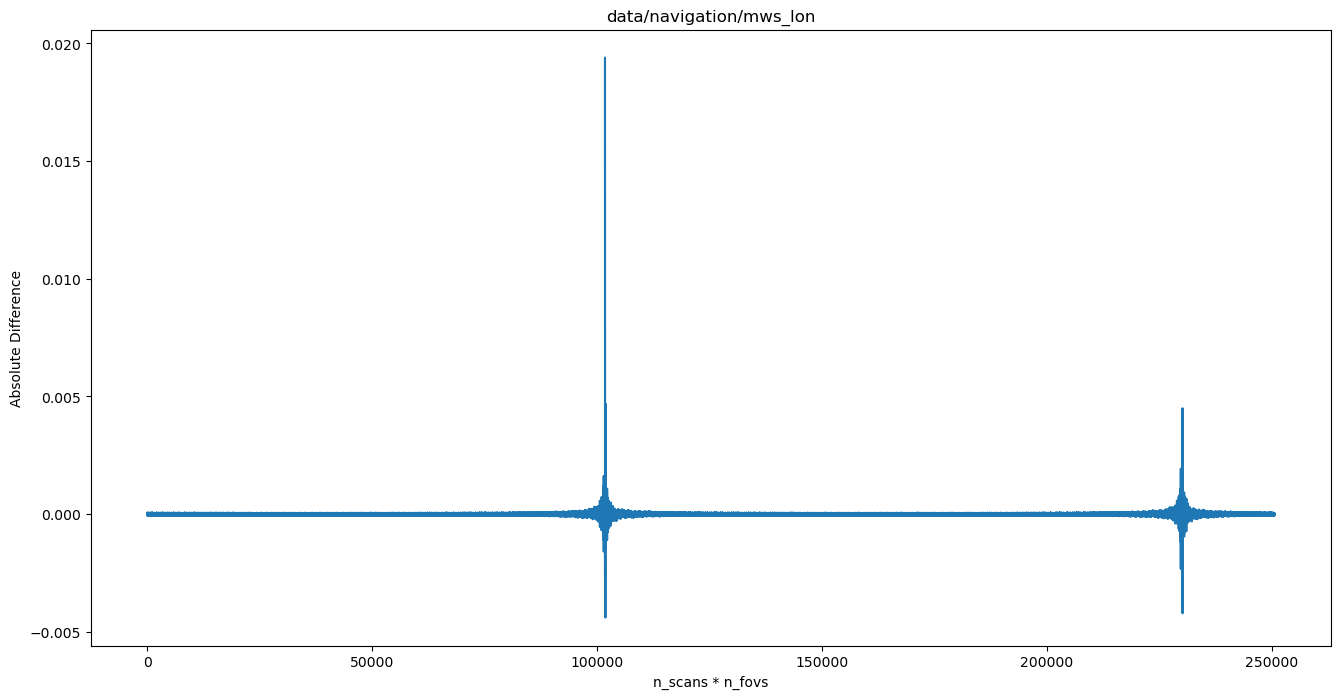

In [16]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_lon')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_lon')
plt.plot(dif)
plt.show()

## 5.2.1 Distance mws_lat/mws_lon

In [17]:
lon_eum = var_1
lon_lp = var_2

df_eum = pd.DataFrame({'Lon': lon_eum, 'Lat': lat_eum})
df_lp = pd.DataFrame({'Lon': lon_lp, 'Lat': lat_lp})

allowed_error = np.zeros(95)
for i in range(0, 95):
    if (i <= 9) or ((i>=85) and (i<=94)):
        allowed_error[i] = 500
    elif ((i>=10) and (i<=46)) or ((i>=48) and (i<=84)):
        allowed_error[i] = 300
    elif i == 47:
        allowed_error[i] = 200
        
# The desired final length
desired_length = len(df_eum["Lat"])

# Calculate the number of repetitions needed to reach the desired length
num_repetitions = desired_length // len(allowed_error)

# Use tile to repeat the array
repeated_array = np.tile(allowed_error, num_repetitions)

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitude and longitude coordinates.
    
    Parameters:
        lat1, lon1: Latitude and longitude of the first location (in degrees).
        lat2, lon2: Latitude and longitude of the second location (in degrees).
        
    Returns:
        Distance in meters.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in meters (mean radius)
    radius = 6371000  # meters
    
    # Return the distance in meters
    return radius * c

# Example usage
# Assuming df1 and df2 are your Pandas DataFrames with "Lat" and "Lon" columns.
# You can add a new column "Distance" to each DataFrame containing the distance to the reference point (0, 0).

reference_lat = 0  # Replace with your desired reference latitude
reference_lon = 0  # Replace with your desired reference longitude

distance = np.zeros(len(df_eum["Lat"]))
for i in range(len(df_eum["Lat"])):
    distance[i] = haversine_distance(df_eum["Lat"][i], df_eum["Lon"][i], df_lp["Lat"][i], df_lp["Lon"][i])

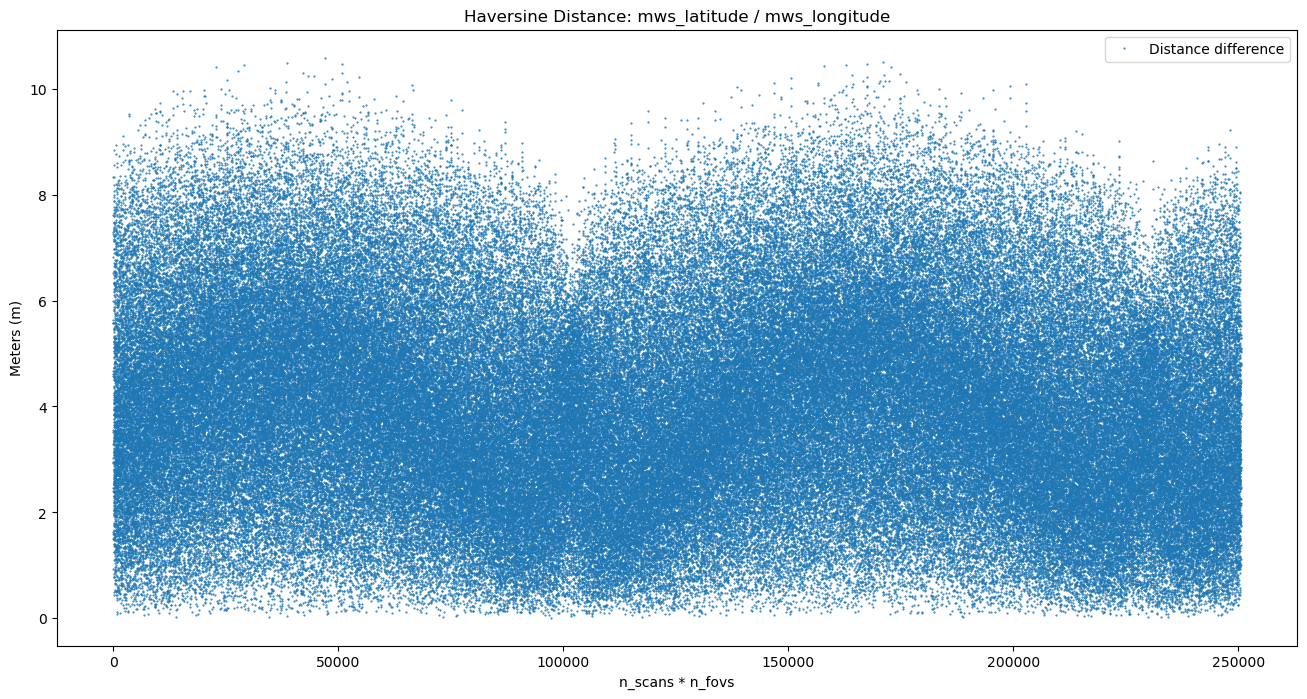

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(distance, ".", markersize="1", label = "Distance difference")
# plt.plot(repeated_array, ".", markersize="1", color = "r", label = "Allowed Abs Error")
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Meters (m)')
plt.title('Haversine Distance: mws_latitude / mws_longitude')
# plt.xticks(range(len(absolute_error_stacked['Rows'].unique())), absolute_error_stacked['Rows'].unique())
# plt.xticks(np.arange(0, 96, step=5))
# plt.tight_layout()
# plt.ylim([0,510])
# plt.xlim([120000,180000])
# plt.xlim([0,250515])
plt.legend(loc='upper right')
# plt.savefig("/home/gsanchez/EPS-SG/pngs/mws_location_TS012_zoom.png")
plt.show()

## 5.3. mws_satellite_azimuth_angle

In [4]:
variable = "satellite_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
variable = "mws_satellite_azimuth_angle"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_satellite_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_satellite_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.02
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 satellite_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_satellite_azimuth_angle(n_scans, n_fovs)
    long_name: Satellite Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_satellite_azimuth_angle:
Mean: 5.423e-06 
Minimum: 1.546e-02 
Maximum: 9.194e-03 
RSM: 2.871e-03
------------------------------------------------------------------------

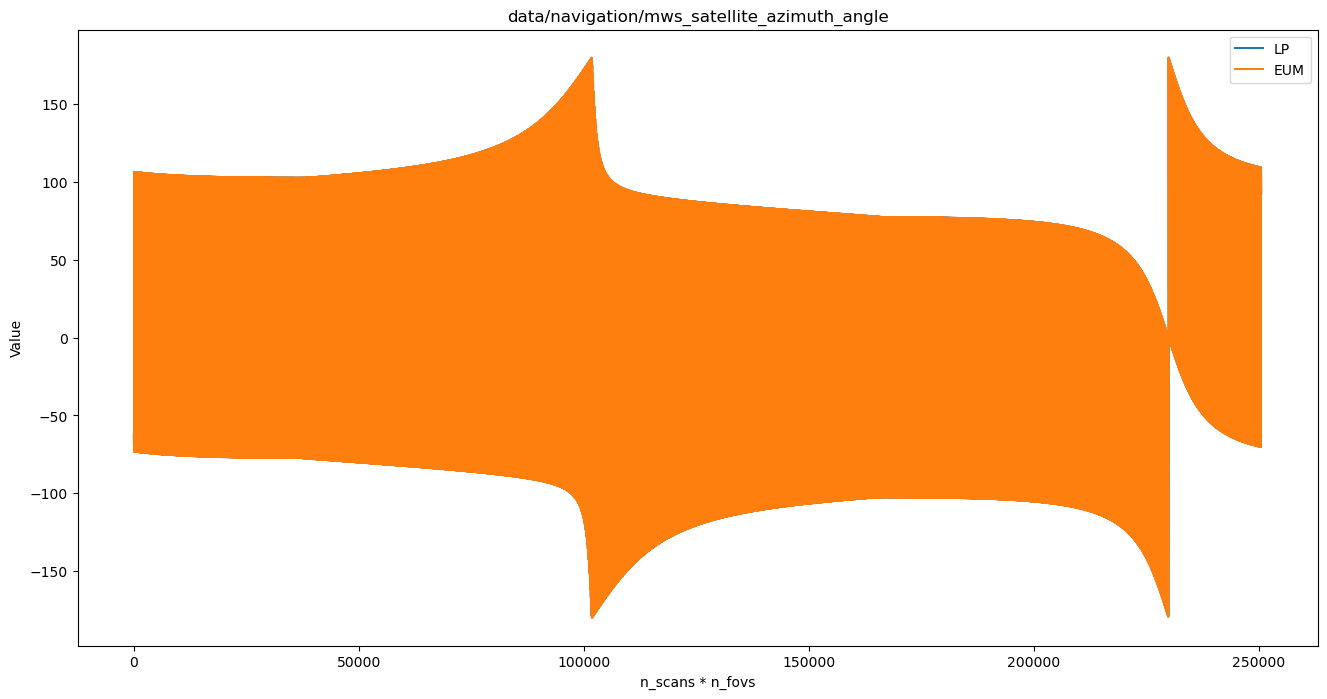

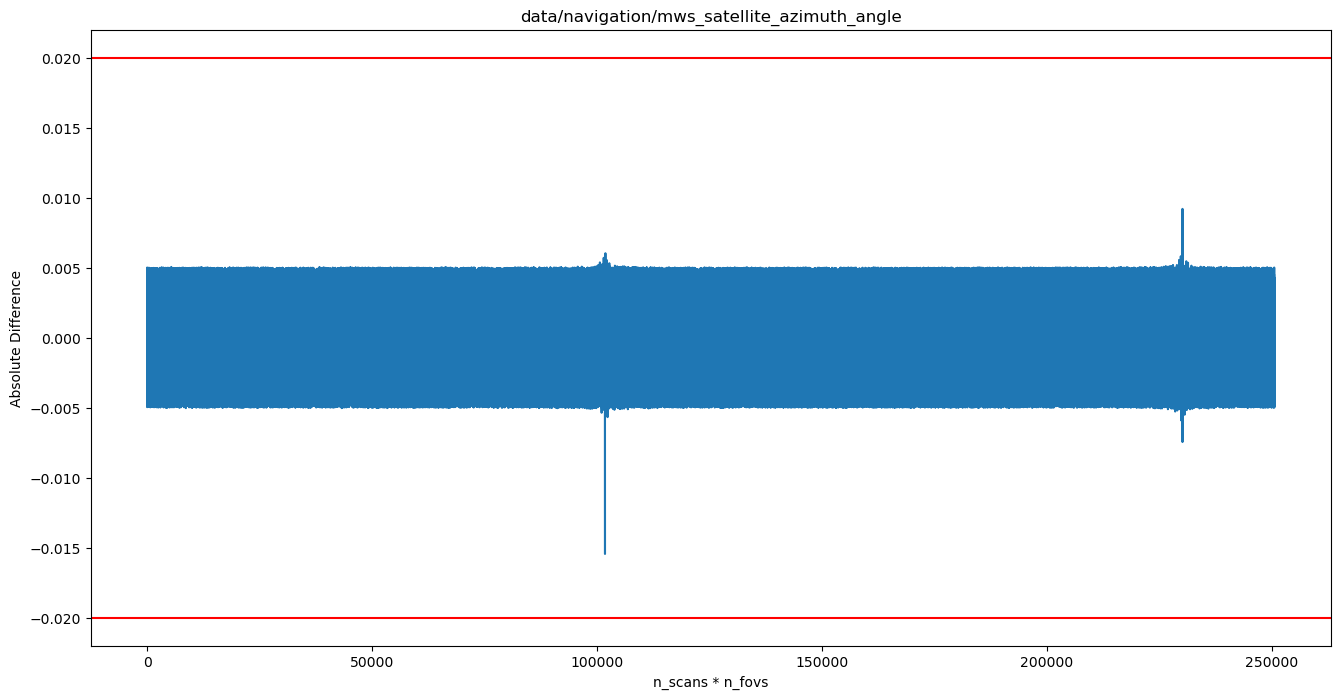

In [5]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_satellite_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.02, color = 'r', linestyle = '-')
plt.axhline(y = -0.02, color = 'r', linestyle = '-')
plt.show()

## 5.4. mws_solar_azimuth_angle

In [6]:
variable = "mws_solar_azimuth_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_solar_azimuth_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_solar_azimuth_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.03
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
perc = count / len(var_1) *100
print(" Total Discrepancies outside tolerance:", count, "%")
if perc > 0.03:
    print("  ·Discrepancies above the allowed deviation!")
else:
    print("  ·Discrepancies bellow the allowed deviaion!")

<class 'netCDF4._netCDF4.Variable'>
float64 mws_solar_azimuth_angle(n_scans, n_fovs)
unlimited dimensions: 
current shape = (2637, 95)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int16 mws_solar_azimuth_angle(n_scans, n_fovs)
    long_name: Solar Azimuth angle corresponding to each field of view
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: -18000
    valid_max: 18000
    missing_value: -32768
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 95)
filling on, default _FillValue of -32767 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_solar_azimuth_angle:
Mean: 2.283e-06 
Minimum: 1.655e-02 
Maximum: 8.575e-03 
RSM: 2.885e-03
------------------------------------------------------------------------------------

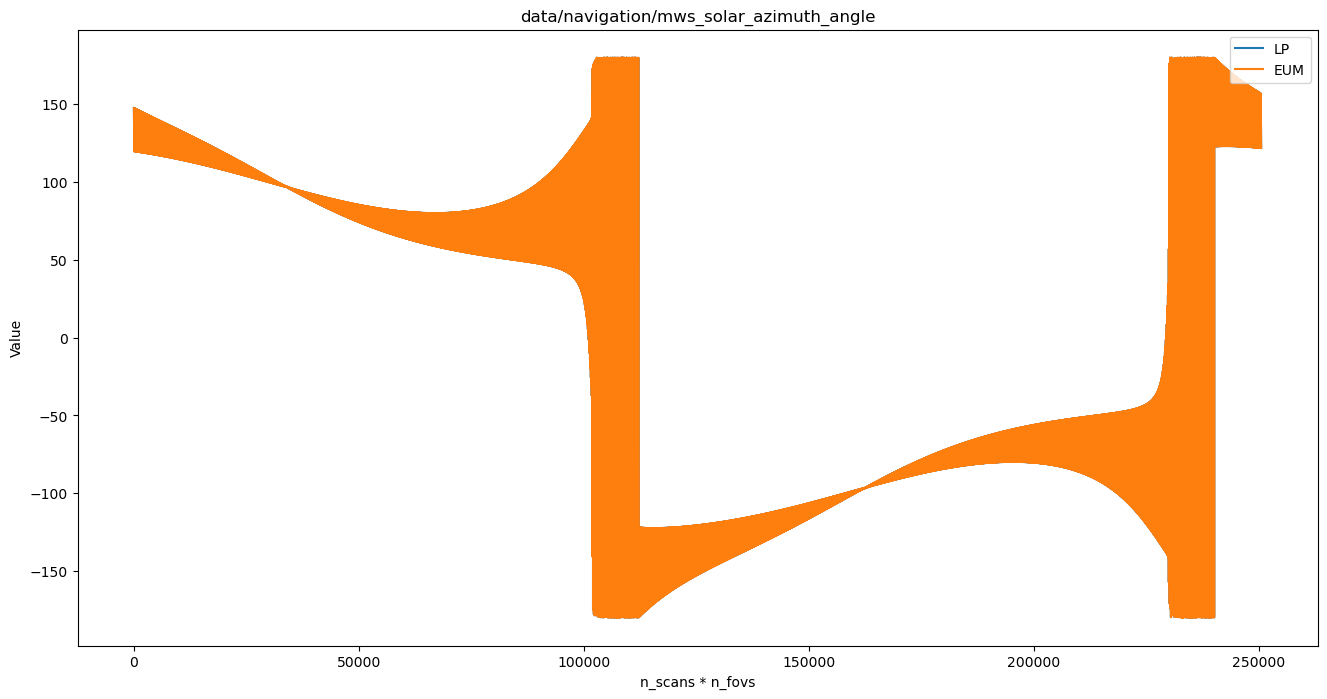

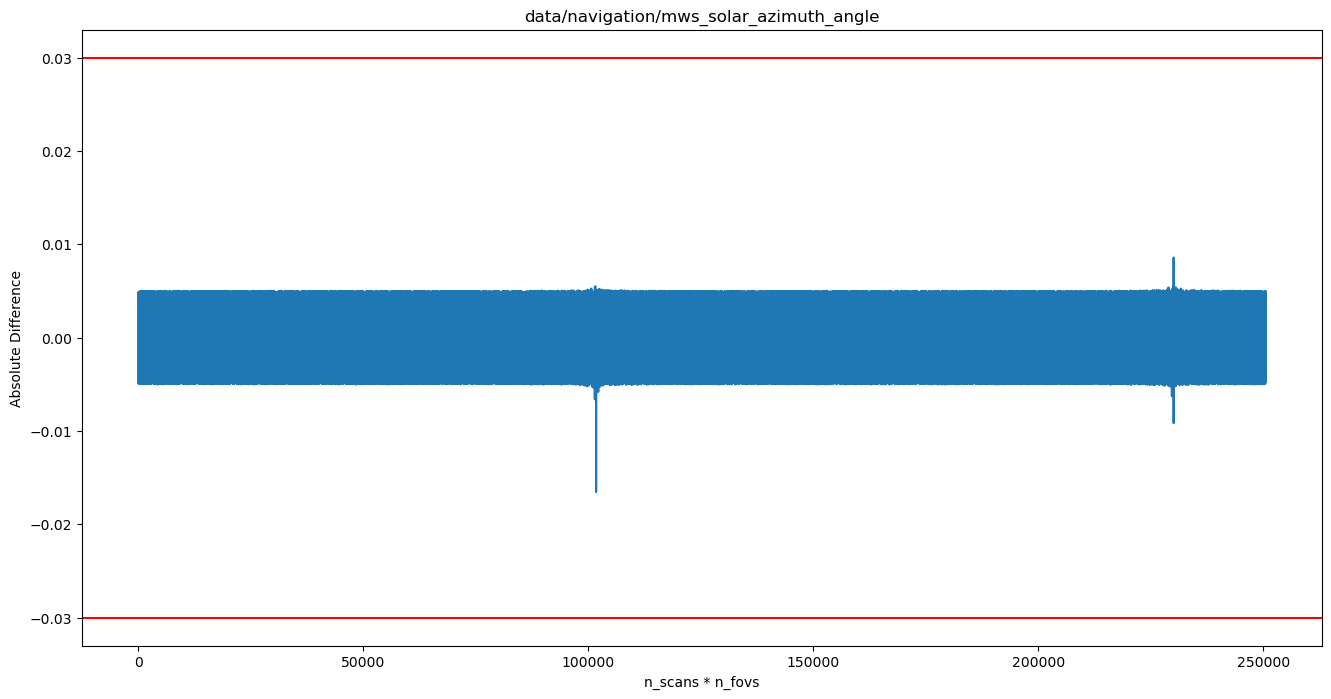

In [7]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Value')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_solar_azimuth_angle')
plt.plot(dif)
plt.axhline(y = 0.03, color = 'r', linestyle = '-')
plt.axhline(y = -0.03, color = 'r', linestyle = '-')
plt.show()

## 5.5. orbit_angle

In [8]:
variable = "orbit_angle"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for orbit_angle:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for orbit_angle:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies\n ---------------------")
count = 0
thresh = 0.3
for i in range(len(var_1)):
    if np.isnan(mask[i]):
        pass
    else:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print("-"*127)
print("Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 orbit_angle(n_scans)
unlimited dimensions: 
current shape = (2637,)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
int32 orbit_angle(n_scans)
    long_name: Angular position in the orbit, starting at zero when the satellite crosses the solar Ecliptic plane northbound
    units: degrees
    scale_factor: 0.0001
    add_offset: 0.0
    valid_min: 0
    valid_max: 3600000
    missing_value: -2147483648
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637,)
filling on, default _FillValue of -2147483647 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for orbit_angle:
Mean: -8.834e+01 
Minimum: 1.967e+02 
Maximum: 1.630e+02 
RSM: 1.367e+02
-----------------------------------------------------------------------------

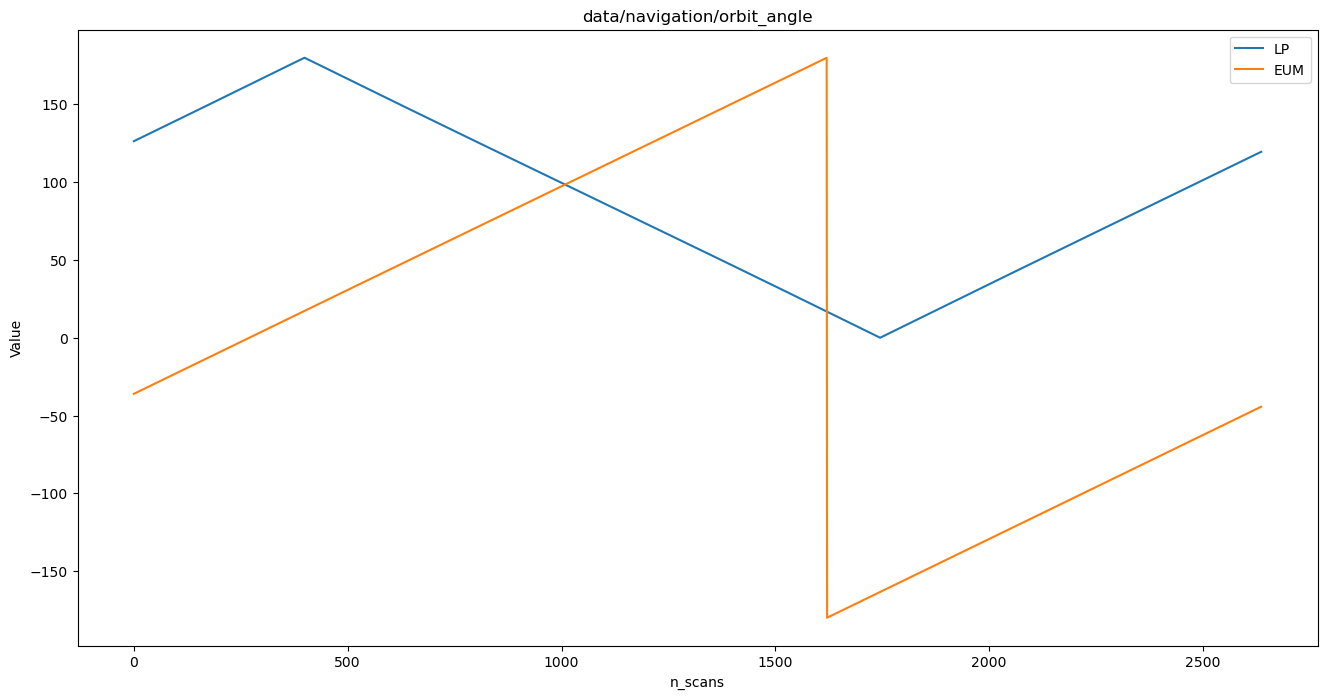

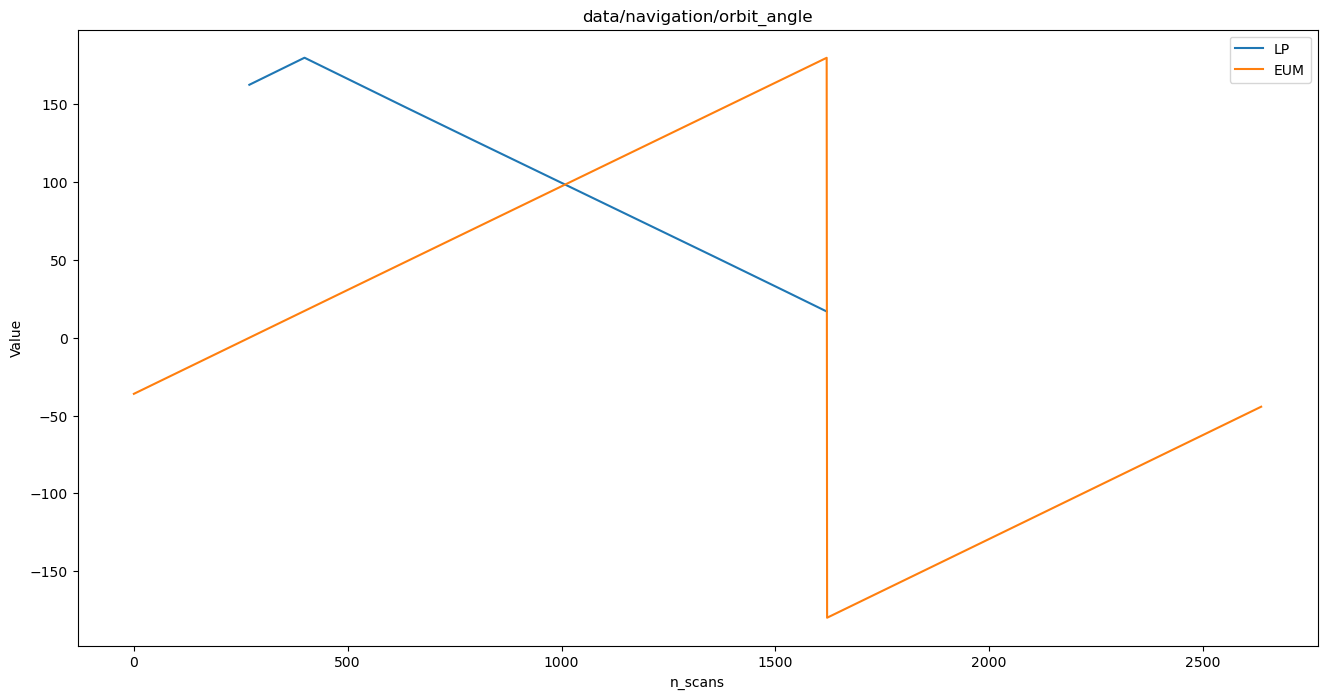

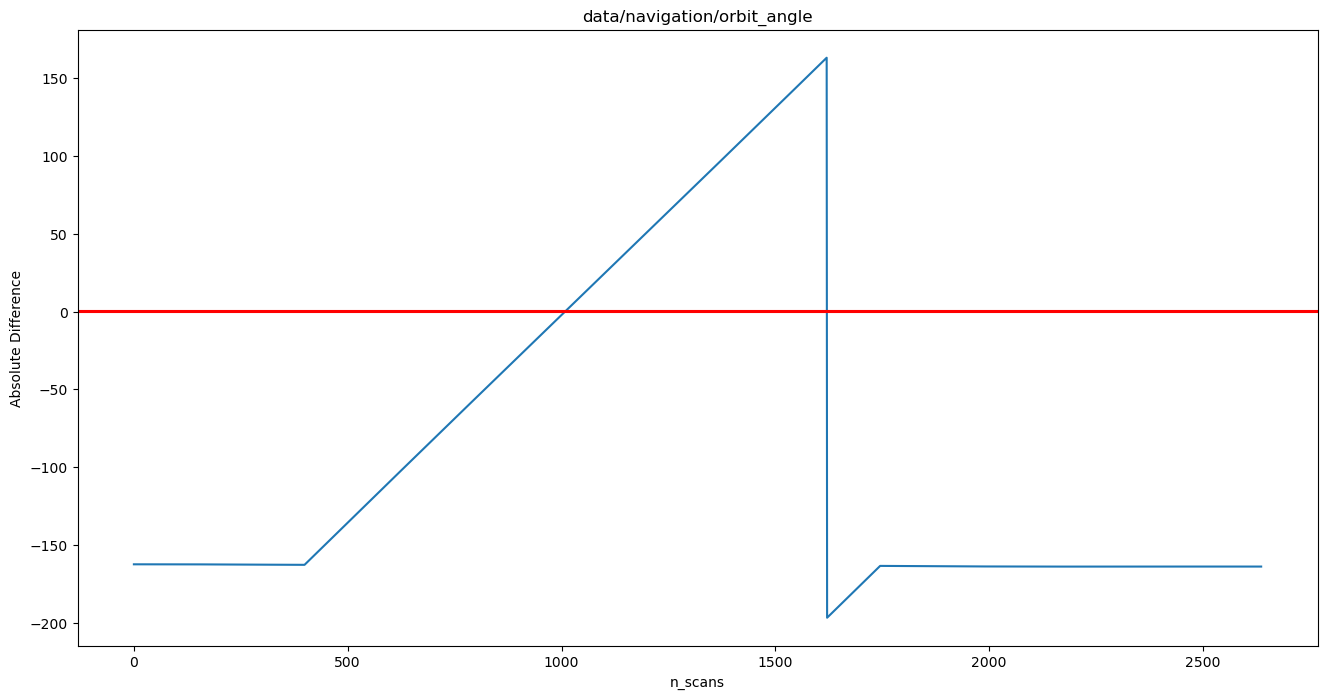

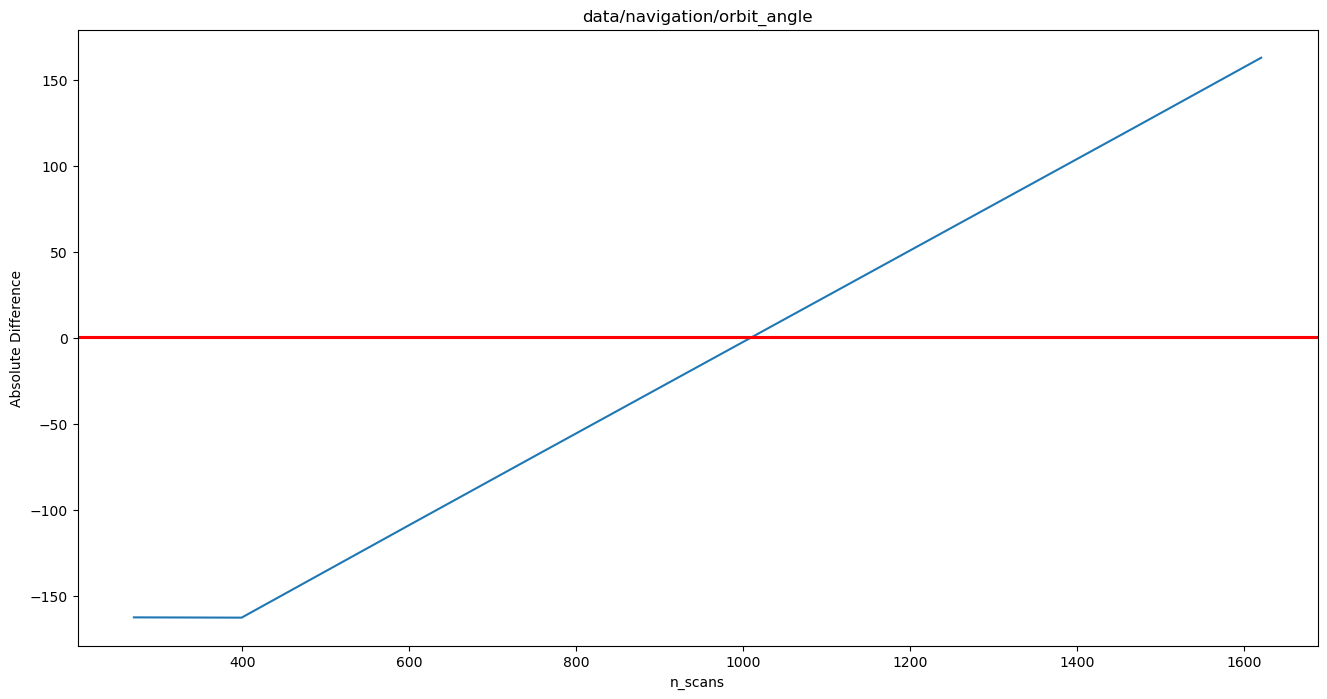

In [9]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

new_var_2 = np.where(mask_eum, np.nan, var_2)
new_var_1 = np.where(mask_LP, np.nan, var_1)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Value')
plt.title('data/navigation/orbit_angle')
plt.plot(new_var_2, label="LP")
plt.plot(new_var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

new_dif = np.where(mask, np.nan, dif)
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/orbit_angle')
plt.plot(new_dif)
plt.axhline(y = 0.3, color = 'r', linestyle = '-')
plt.axhline(y = -0.3, color = 'r', linestyle = '-')
plt.show()

## 5.6. mws_moon_angles

In [10]:
variable = "mws_moon_angles"
mode = "EUM"
info_eum, var_eum = read_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_nc(lp_path, mode, variable)
print(info_eum)
print("Number of Samples:", len(var_eum))
print("-------------------")
print(info_LP)
print("Number of Samples:", len(var_LP))
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for mws_moon_angles:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
sf   = info_LP.getncattr("scale_factor")
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = (var_eum.data/sf).flatten()
new_var_LP = (var_LP.data/sf).flatten()
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
for i in range(len(new_var_eum)):
    if miss == new_var_eum[i]:
        mask_eum[i] = True
    if miss == new_var_LP[i]:
        mask_LP[i] = True
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for mws_moon_angles:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 0.25
for i in range(len(var_1)):
    if var_1[i] != var_2[i]:
        abs_dif = abs(var_1[i] - var_2[i])
        if abs_dif > thresh:
            count +=1
print(" Total Discrepancies outside tolerance:", count)

<class 'netCDF4._netCDF4.Variable'>
float64 mws_moon_angles(n_scans, n_fovs_cal)
unlimited dimensions: 
current shape = (2637, 5)
filling on, default _FillValue of 9.969209968386869e+36 used
Number of Samples: 2637
-------------------
<class 'netCDF4._netCDF4.Variable'>
uint16 mws_moon_angles(n_scans, n_fovs_cal)
    long_name: Angle between Moon and individual space views
    units: degrees
    scale_factor: 0.01
    add_offset: 0.0
    valid_min: 0
    valid_max: 18000
    missing_value: 65535
path = /data/navigation
unlimited dimensions: n_scans
current shape = (2637, 5)
filling on, default _FillValue of 65535 used
Number of Samples: 2637
-------------------------------------------------------------------------------------------------------------------------------
Statistics for mws_moon_angles:
Mean: -1.115e-05 
Minimum: 5.002e-03 
Maximum: 5.002e-03 
RSM: 2.879e-03
---------------------------------------------------------------------------------------------------------------------

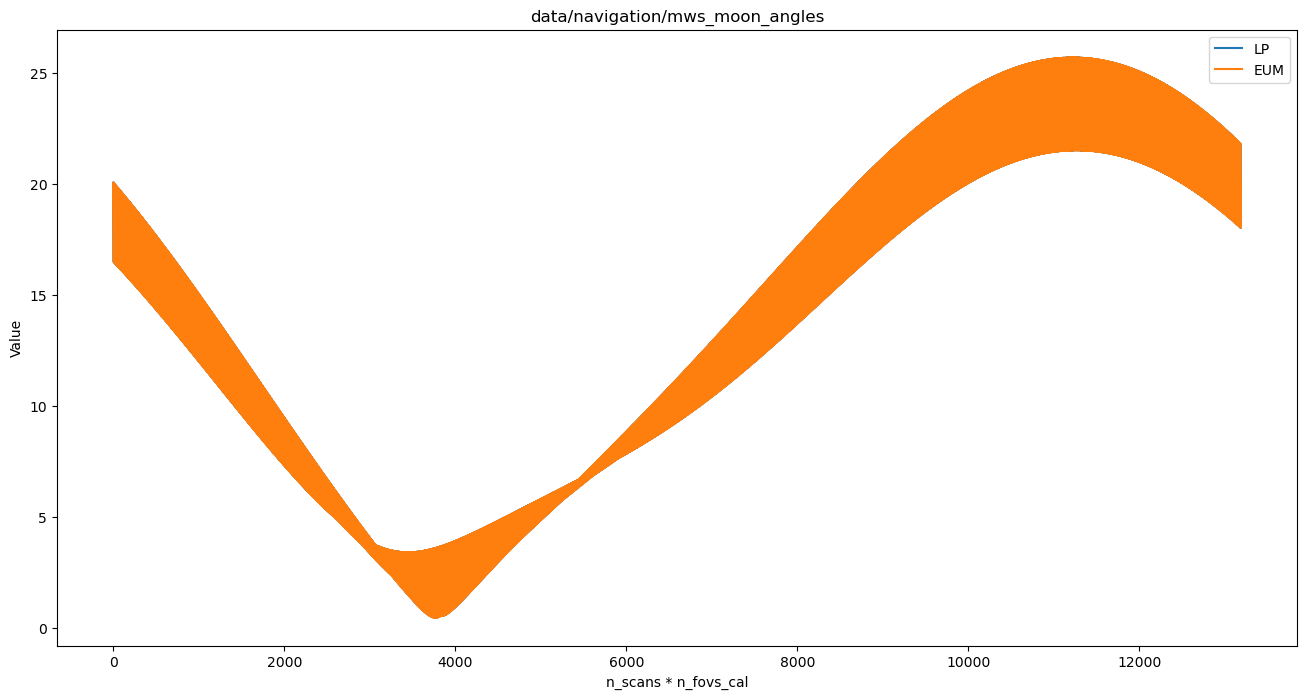

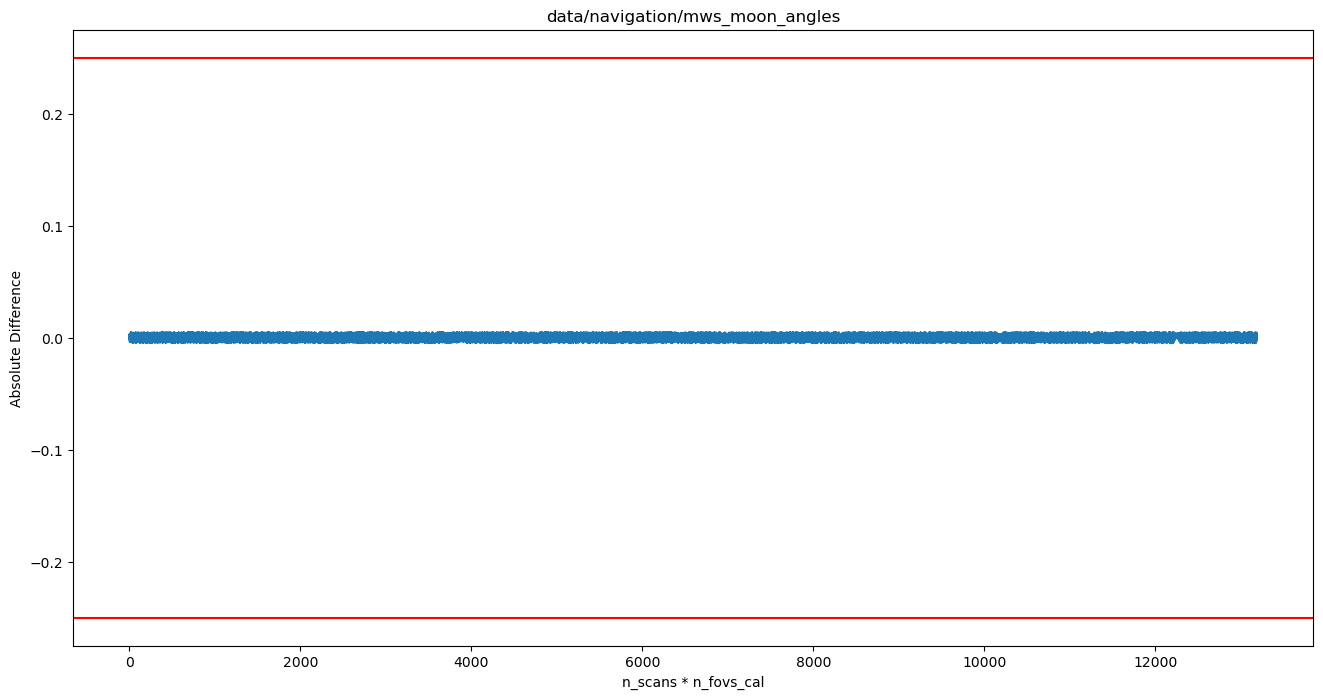

In [11]:
# Without Scale Factor
plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Value')
plt.title('data/navigation/mws_moon_angles')
plt.plot(var_2, label="LP")
plt.plot(var_1, label="EUM")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(16, 8))
plt.xlabel('n_scans * n_fovs_cal')
plt.ylabel('Absolute Difference')
plt.title('data/navigation/mws_moon_angles')
plt.plot(dif)
plt.axhline(y = 0.25, color = 'r', linestyle = '-')
plt.axhline(y = -0.25, color = 'r', linestyle = '-')
plt.show()

## 5.7. x_position

In [12]:
variable = "x_position"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for x_position:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for x_position:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 3
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 x_position(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [4065168.34]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 x_position()
    long_name: X position of the orbital state vector [EARTH+FIXED]
    units: m
    valid_min: -7200000.0
    valid_max: 7200000.0
    missing_value: -9000000.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 4065170.954751645
-------------------------------------------------------------------------------------------------------------------------------
Statistics for x_position:
Mean: -2.615e+00 
Minimum: 2.615e+00 
Maximum: 2.615e+00 
RSM: 2.615e+00
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref

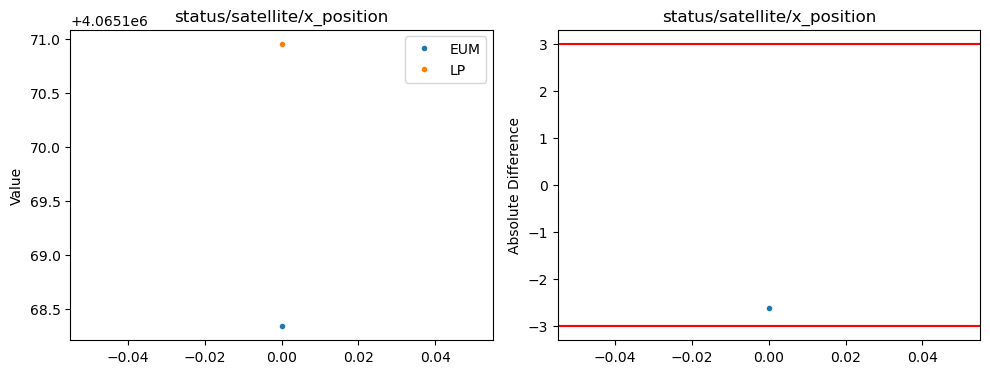

In [13]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/x_position')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -3, color = 'r', linestyle = '-')
axs[1].axhline(y = 3, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/x_position')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## 5.8. eccentricity

In [14]:
variable = "eccentricity"
mode = "EUM"
info_eum, var_eum = read_common_nc(eum_path, mode, variable)
mode = "LP"
info_LP, var_LP = read_common_nc(lp_path, mode, variable)
print(info_eum)
print("Value:", var_eum)
print("-------------------")
print(info_LP)
print("Value:", var_LP)
print("-"*127)
# Statistics
var_1 = var_eum.data.flatten()
var_2 = var_LP.data.flatten()
mean, minim, maxim, rsm, dif = stats(var_1, var_2)
print("Statistics for eccentricity:")
print("Mean:", mean, "\nMinimum:", minim, "\nMaximum:", maxim, "\nRSM:", rsm)
print("-"*127)

# NaN occurances & New Statistics
vmax = info_LP.getncattr("valid_max")
vmin = info_LP.getncattr("valid_min")
miss = info_LP.getncattr("missing_value")
# Apply Scale Factor
new_var_eum = var_eum.data
new_var_LP = var_LP.data
# Apply Masks
mask_eum = np.logical_or(new_var_eum < vmin, new_var_eum > vmax)
mask_LP = np.logical_or(new_var_LP < vmin, new_var_LP > vmax)
mask = np.logical_or(mask_eum, mask_LP)
mask_var_eum = np.where(mask, np.nan, new_var_eum)
mask_var_LP = np.where(mask, np.nan, new_var_LP)
# NaN values
print("Total NaN occurances:", np.sum(mask))
print("Test NaN occurances:", np.sum(mask_eum))
print("Ref NaN occurances:", np.sum(mask_LP))
print("-"*127)
mean, minim, maxim, rsm, diff = stats_nan(mask_var_eum, mask_var_LP)
print("NEW Statistics for eccentricity:")
print(" Mean:", mean, "\n Minimum:", minim, "\n Maximum:", maxim, "\n RSM:", rsm)
print("-"*127)

print("Discrepancies")
count = 0
thresh = 1.5 * 1e-5
abs_dif = abs(new_var_eum - new_var_LP)
if abs_dif > thresh:
    print(" Total Discrepancy outside tolerance!")
else:
    print(" No discrepancies found!")

<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity(dim1x)
path = /common
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used
Value: [0.00107538]
-------------------
<class 'netCDF4._netCDF4.Variable'>
float64 eccentricity()
    long_name: Eccentricity of the orbit at epoch time[TOD]
    valid_min: 0.0
    valid_max: 0.01
    missing_value: -900.0
path = /status/satellite
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
Value: 0.0010753814502138866
-------------------------------------------------------------------------------------------------------------------------------
Statistics for eccentricity:
Mean: -5.305e-10 
Minimum: 5.305e-10 
Maximum: 5.305e-10 
RSM: 5.305e-10
-------------------------------------------------------------------------------------------------------------------------------
Total NaN occurances: 0
Test NaN occurances: 0
Ref NaN occurances: 0
--------

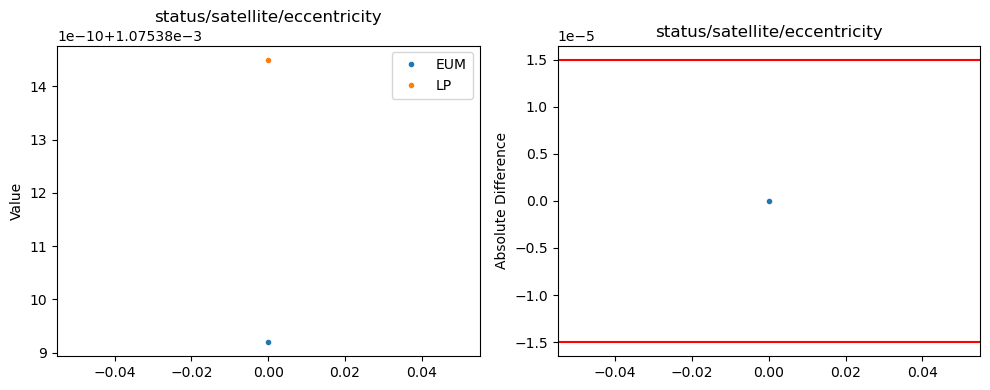

In [15]:
# Create a 1x2 grid for subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot in the first column
axs[0].plot(new_var_eum, ".", label="EUM")
axs[0].plot(new_var_LP, ".", label="LP")
axs[0].legend(loc="upper right")
axs[0].set_title('status/satellite/eccentricity')
axs[0].set_ylabel('Value')

# Plot the second subplot in the second column
axs[1].plot(dif, ".")
axs[1].axhline(y = -thresh, color = 'r', linestyle = '-')
axs[1].axhline(y = thresh, color = 'r', linestyle = '-')
axs[1].set_title('status/satellite/eccentricity')
axs[1].set_ylabel('Absolute Difference')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()